In [5]:
import os 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Make sure that we're in the root directory of the project 
# We can check it by verifying the existence of the `src` directory below
while 'src' not in os.listdir():
    os.chdir('..')
    
# Set the style of the plots
markers = ['o', 's', 'D', 'v', 'p', 'P', 'X', 'h', 'H', 'd']
colors_discrete = sns.color_palette('tab10')
colors_continuous = sns.color_palette('viridis')
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# Do not hide any columns
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', font_scale=1)

In [6]:
results_path = 'aaai_experiments/results_aaai/'

betarob_results_path = 'aaai_experiments/results_aaai/all/'
robx_results_path = 'aaai_experiments/results_aaai/robx/'
just_base_results_path = 'aaai_experiments/results_aaai/base/'
k_sweep_results_path = 'aaai_experiments/results_aaai/betarob_k_sweep/'
betarob_params_results_path = 'aaai_experiments/results_aaai/betarob_params/'
images_dir = f'{results_path}/images'
os.makedirs(images_dir, exist_ok=True)

In [3]:
import yaml

def process_results(directiory: str):
    results_list = []

    # When .yaml file is found, load all .csv files in {path}/results/
    if os.path.isfile(f'{directiory}/config.yml'):
        with open(f'{directiory}/config.yml') as file:
            try:
                config = yaml.load(file, Loader=yaml.FullLoader)
            except Exception as e:
                print(f'Error loading config file in {directiory}')
                print(e)
                return []
            
        # Load all .csv files in {path}/results/
        for file in os.listdir(f'{directiory}/results'):
            if file.endswith('.csv'):
                try:
                    df = pd.read_csv(f'{directiory}/results/{file}')
                    df['config'] = config
                    df['robust_cf_method'] = config['experiments_setup']['robust_cf_method']
                    results_list.append(df)
                except Exception as e:
                    print(f'Error loading {file} in {directiory}')
                    print(e)
                    
    # Else recursively call process_results on all subdirectories    
    else:
        if os.path.isdir(directiory):
            for subdirectory in os.listdir(directiory):
                results_list += process_results(f'{directiory}/{subdirectory}')
        else:
            print(f'No config file found in {directiory}')
    
    return results_list

def get_results_df(results_list):
    results_df = pd.concat(results_list)
    results_df = results_df.reset_index(drop=True)
    return results_df

In [4]:
betarce_df = pd.concat(process_results('results/july_test')).reset_index(drop=True)
betarce_df['base_cf_method'].value_counts()

dice    1499
gs       301
Name: base_cf_method, dtype: int64

In [5]:
just_base_df = pd.concat(process_results(just_base_results_path)).reset_index(drop=True)
just_base_df['base_cf_method'].value_counts(dropna=False)

face    89001
roar    89001
rbr     89001
dice    89001
gs      32400
Name: base_cf_method, dtype: int64

In [6]:
robx_df = pd.concat(process_results(robx_results_path)).reset_index(drop=True)
robx_df['base_cf_method'].value_counts()

gs      32400
face    32400
dice    32400
Name: base_cf_method, dtype: int64

In [7]:
ksweep_df = pd.concat(process_results(k_sweep_results_path)).reset_index(drop=True)
ksweep_df['base_cf_method'].value_counts()

gs      353112
dice    311312
Name: base_cf_method, dtype: int64

In [8]:
brce_params_df = pd.concat(process_results(betarob_params_results_path)).reset_index(drop=True)
brce_params_df['base_cf_method'].value_counts()

gs      220812
dice    196212
Name: base_cf_method, dtype: int64

In [9]:
betarce_df['this_is_generalization'] = betarce_df['experiment_generalization_type'] != betarce_df['experiment_type']
# raw_df['generalization_type'][raw_df['this_is_generalization'] == False] = 'Original'
betarce_df['generalization_type'] = betarce_df[['this_is_generalization', 'experiment_generalization_type']] \
    .apply(lambda x: 'g_' + x[1] if x[0] else 'Original', axis=1)
betarce_df['this_is_generalization'].value_counts(dropna=False)


True     571601
False    286100
Name: this_is_generalization, dtype: int64

In [10]:
betarce_df['delta_robustness'].value_counts()

0.7    285910
0.8    285900
0.9    285891
Name: delta_robustness, dtype: int64

In [11]:
betarce_df.columns

Index(['Unnamed: 0', 'base_cf_method', 'model_type_to_use', 'experiment_type',
       'dataset_name', 'just_base_cf', 'k_mlps_in_B', 'fold_i',
       'experiment_generalization_type', 'beta_confidence', 'delta_robustness',
       'model2_name', 'x_test_sample', 'y_test_sample', 'model1_pred_proba',
       'model1_pred_crisp', 'model2_pred_proba', 'model2_pred_crisp',
       'base_counterfactual', 'base_counterfactual_model1_pred_proba',
       'base_counterfactual_model1_pred_crisp',
       'base_counterfactual_model2_pred_proba',
       'base_counterfactual_model2_pred_crisp', 'base_counterfactual_validity',
       'base_counterfactual_proximityL1', 'base_counterfactual_proximityL2',
       'base_counterfactual_plausibility',
       'base_counterfactual_discriminative_power',
       'base_counterfactual_validity_model2', 'base_counterfactual_time',
       'robust_counterfactual', 'robust_counterfactual_model1_pred_proba',
       'robust_counterfactual_model1_pred_crisp',
       'robus

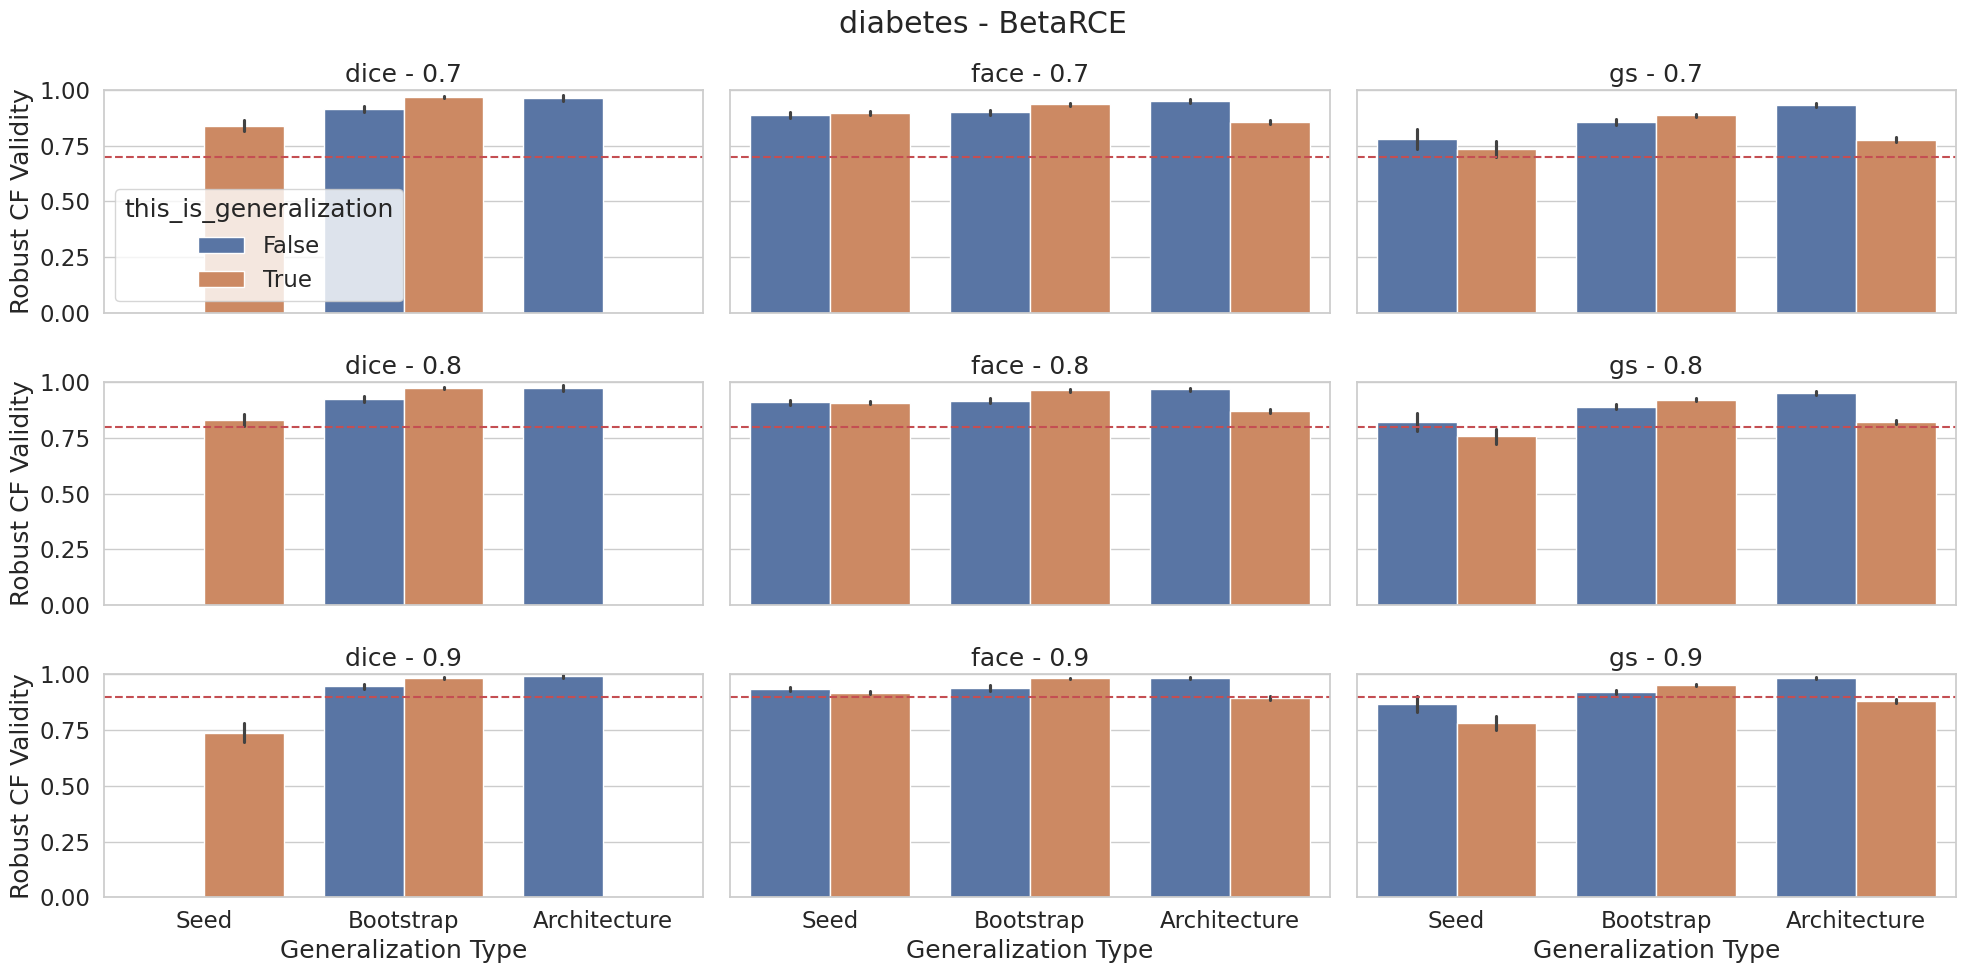

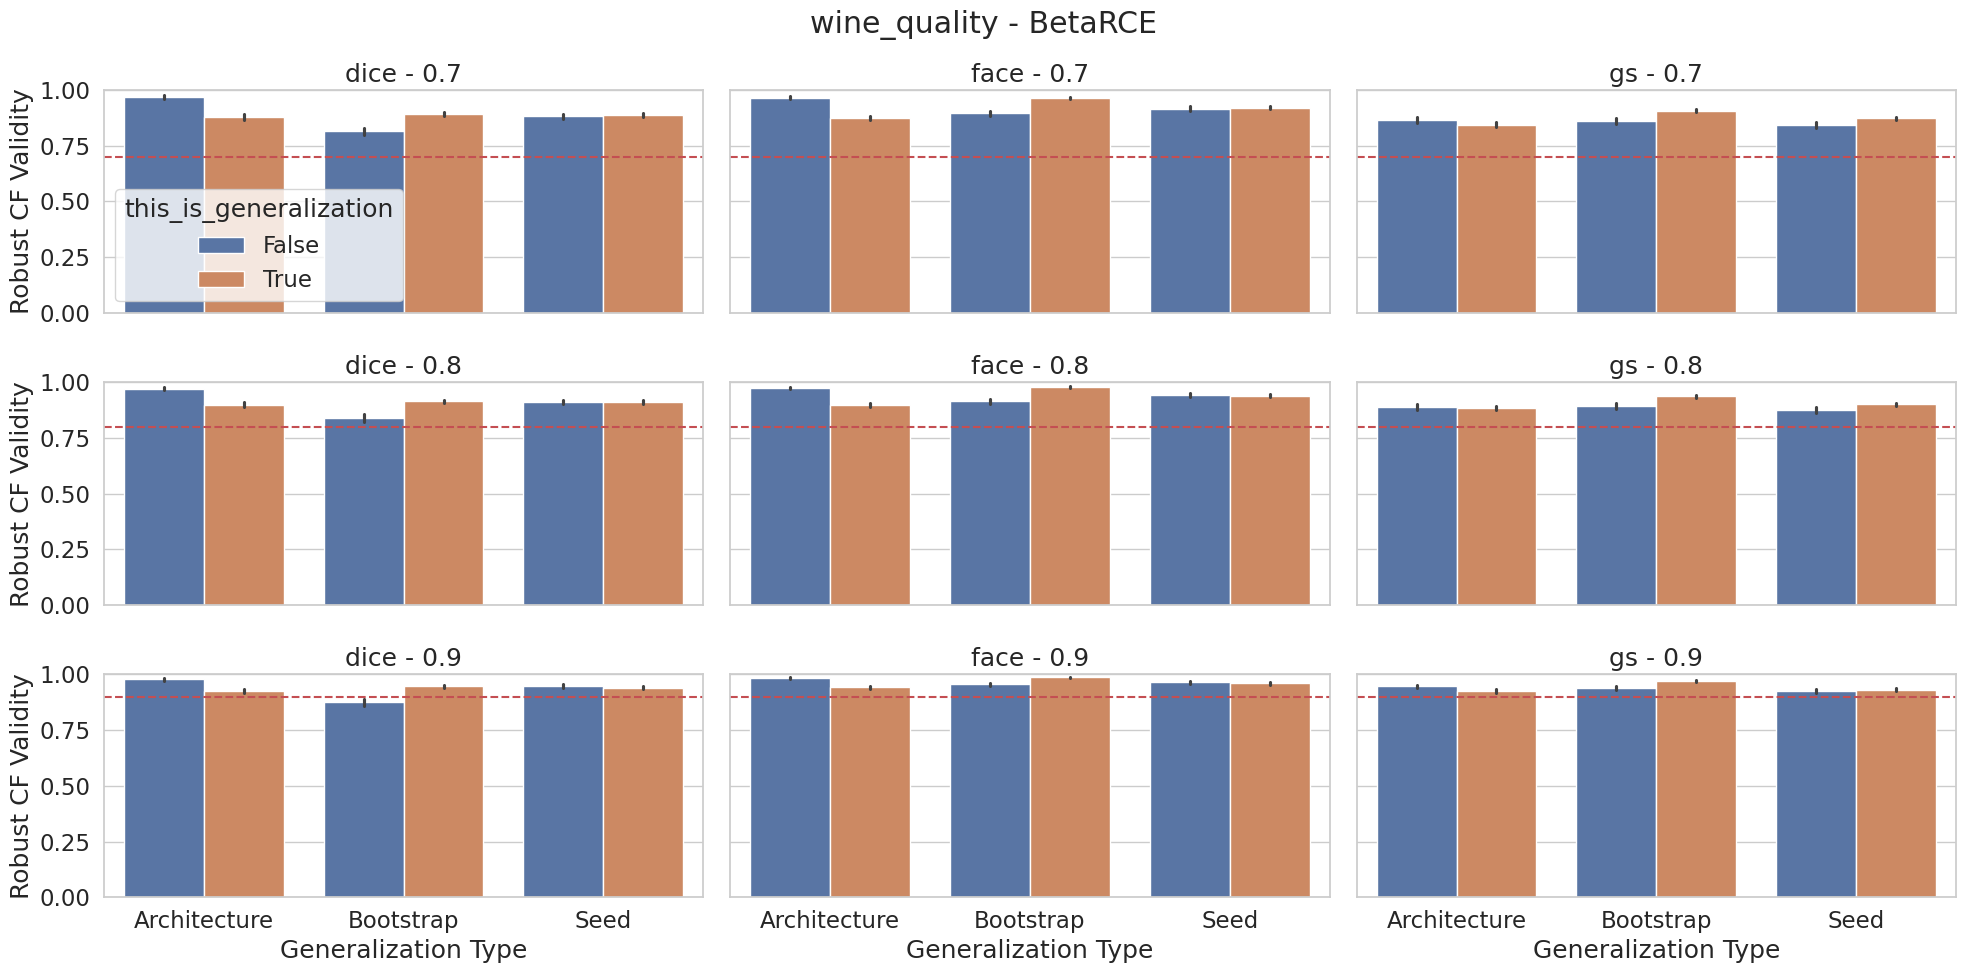

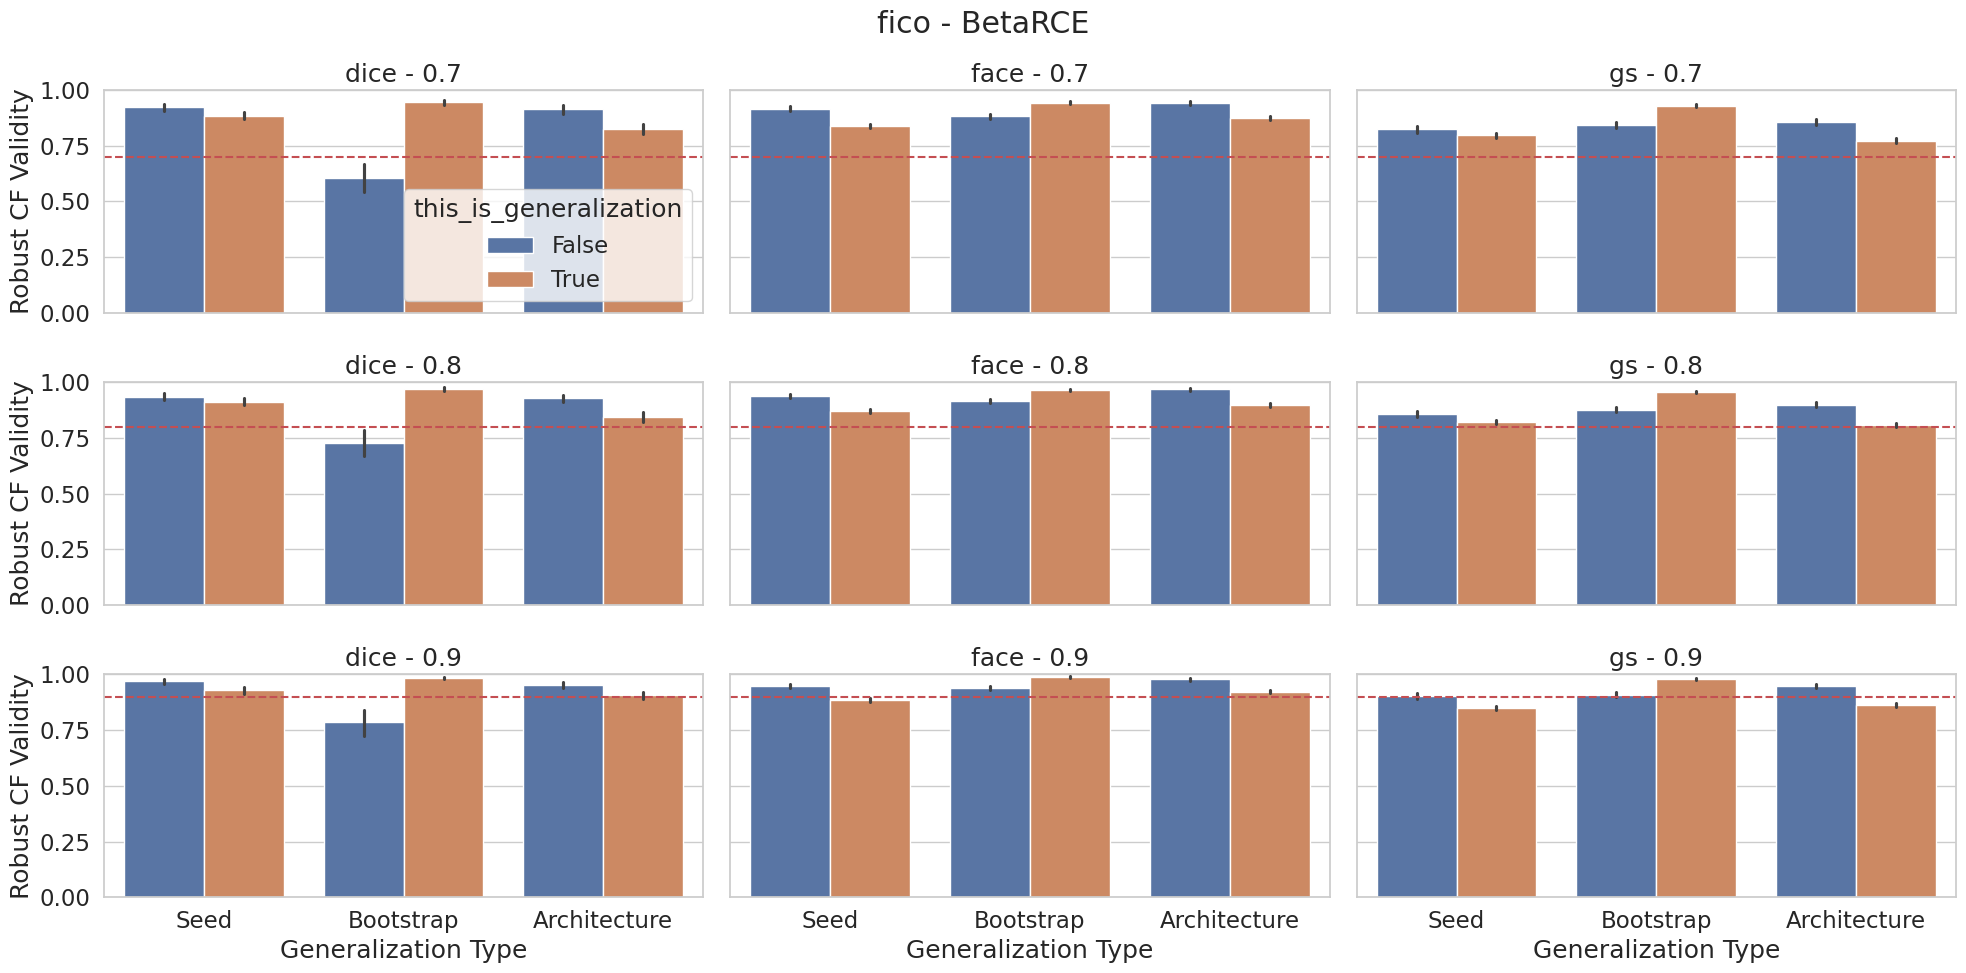

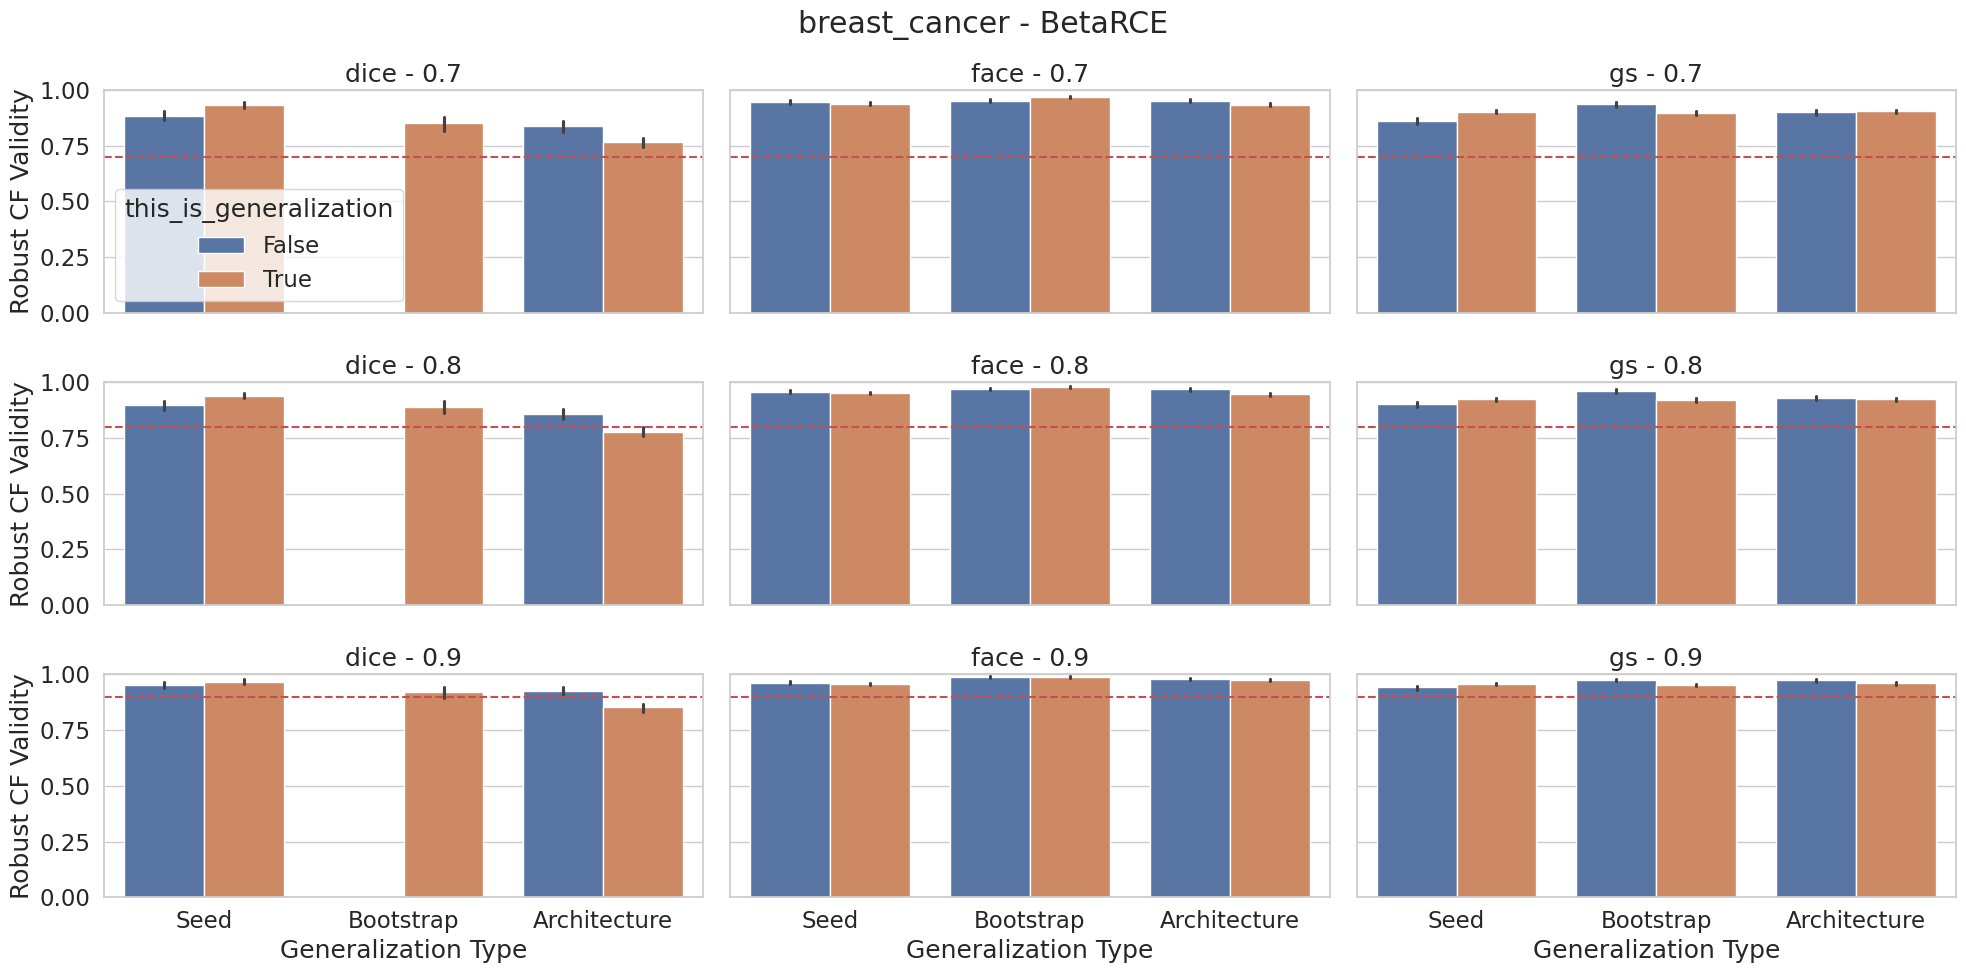

In [12]:
agg_by = ['experiment_type', 'experiment_generalization_type', 'this_is_generalization', 'base_cf_method', 'delta_robustness']
agg_df = betarce_df.groupby(agg_by).agg(
    n=('robust_counterfactual_validity_model2', 'count'),
    mean_robust_cf_validity=('robust_counterfactual_validity_model2', 'mean'),
    std_robust_cf_validity=('robust_counterfactual_validity_model2', 'std'),
    mean_base_cf_validity=('base_counterfactual_validity_model2', 'mean'),
    std_base_cf_validity=('base_counterfactual_validity_model2', 'std')
).reset_index()

sns.set_theme(style='whitegrid', font_scale=1.5)

cols = sorted(betarce_df['base_cf_method'].unique())
rows = sorted(betarce_df['delta_robustness'].unique())
x = 'experiment_type'
markers = 'this_is_generalization'
y = 'robust_counterfactual_validity_model2'
hue = 'this_is_generalization'


for dataset in betarce_df['dataset_name'].unique():

    dataset_filtered_df = betarce_df[betarce_df['dataset_name'] == dataset]

    fig, ax = plt.subplots(len(rows), len(cols), figsize=(20, 10), sharex=True, sharey=True)

    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            df = dataset_filtered_df[
                (dataset_filtered_df['base_cf_method'] == col) &
                (dataset_filtered_df['delta_robustness'] == row)
            ]
            sns.barplot(
                data=df,
                x=x,
                y=y,
                hue=hue,
                ax=ax[i, j],
                legend=True if i == 0 and j == 0 else False,
            )
            
            # Draw a horizontal line at delta_robustness 
            ax[i, j].axhline(row, color='r', linestyle='--')
            
            ax[i, j].set_title(f'{col} - {row}')
            ax[i, j].set_ylim(0, 1)
            ax[i, j].set_ylabel('Robust CF Validity')
            ax[i, j].set_xlabel('Generalization Type')
            
    plt.suptitle(f'{dataset} - BetaRCE')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [13]:
just_base_df[['base_cf_method', 'dataset_name']].value_counts().sort_index()

# Pivot table
agg_by = ['dataset_name', 'base_cf_method']
agg_df = just_base_df.groupby(agg_by).agg(
    n=('base_counterfactual_validity_model2', 'count'),
    validity=('base_counterfactual_validity', 'mean'),
    validity_std=('base_counterfactual_validity', 'std'),
    robustness=('base_counterfactual_validity_model2', 'mean'),
    robustness_std=('base_counterfactual_validity_model2', 'std'),
    proximityL1=('base_counterfactual_proximityL1', 'mean'),
    proximityL1_std=('base_counterfactual_proximityL1', 'std'),
).reset_index()
agg_df.round(2)

dataset_name base_cf_method      n  validity  validity_std  robustness  \
0   breast_cancer           dice  72900      1.00          0.00        0.66   
1   breast_cancer           face  27000      1.00          0.00        0.91   
2   breast_cancer             gs   8100      1.00          0.00        0.53   
3   breast_cancer            rbr  72900      0.38          0.49        0.36   
4   breast_cancer           roar  48600      0.39          0.49        0.39   
5        diabetes           face  11520      1.00          0.00        0.86   
6        diabetes             gs   8100      1.00          0.00        0.57   
7            fico           face  16200      1.00          0.00        0.77   
8            fico             gs   8100      1.00          0.00        0.59   
9    wine_quality           dice  16101      1.00          0.00        0.76   
10   wine_quality           face  24171      1.00          0.00        0.76   
11   wine_quality             gs   8100      1.00          0.00        0.57   
12   wine_quality            rbr  16101      0.78          0.42        0.78   
13   wine_quality           roar  40401      0.74          0.44        0.72   

    robustness_std  proximityL1  proximityL1_std  
0             0.47         1.61             0.90  
1             0.28         3.43             1.39  
2             0.50         3.06             1.83  
3             0.48         2.66             1.28  
4             0.49         9.27             9.79  
5             0.35         0.85             0.32  
6             0.50         0.55             0.39  
7             0.42         2.23             0.66  
8             0.49         2.10             1.49  
9             0.43         0.72             0.43  
10            0.43         0.53             0.25  
11            0.49         0.30             0.24  
12            0.42         0.52             0.22  
13            0.45         9.32             8.42

In [14]:
robust_params_map = {
    'robx': ['beta_confidence', 'delta_robustness'],
    'betarob': ['beta_confidence', 'delta_robustness'],
}
base_params_map = { 
    'dice': ['proximity_weight', 'diversity_weight', 'sparsity_weight'],
    'face': ['mode', 'fraction'],
    'roar': ['delta_max', 'lr', 'norm'],
    'rbr': ['perturb_radius', 'delta_plus', 'sigma'],
    'gs': ['max_iter', 'n_search_samples', 'p_norm', 'step', 'target_proba'],
}

just_base_df['sigma'].value_counts(dropna=False)

NaN    299403
1.0     29700
0.5     29700
1.5     29601
Name: sigma, dtype: int64

In [15]:
just_base_df['base_cf_hp_name'] = [None] * len(just_base_df)

for base_method, params in base_params_map.items():
    for row in just_base_df.itertuples():
        if row.base_cf_method == base_method:
            hp_name = base_method + '-'.join([f'{param}={getattr(row, param)}' for param in params])
            just_base_df.at[row.Index, 'base_cf_hp_name'] = hp_name
    
just_base_df['base_cf_hp_name'].value_counts(dropna=False)

just_base_df[['base_cf_hp_name', 'dataset_name']].value_counts().sort_index()

base_cf_hp_name                                                       dataset_name 
diceproximity_weight=0.05-diversity_weight=0.05-sparsity_weight=0.05  breast_cancer    2700
                                                                      wine_quality     2700
diceproximity_weight=0.05-diversity_weight=0.05-sparsity_weight=0.1   breast_cancer    2700
                                                                      wine_quality     2700
diceproximity_weight=0.05-diversity_weight=0.05-sparsity_weight=0.2   breast_cancer    2700
                                                                                       ... 
roardelta_max=0.1-lr=0.05-norm=1.0                                    breast_cancer    2700
                                                                      wine_quality     2601
roardelta_max=0.1-lr=0.05-norm=2.0                                    breast_cancer    2700
roardelta_max=0.1-lr=0.1-norm=1.0                                     breast_cancer    2

In [16]:
# Pivot table
agg_by = ['dataset_name', 'base_cf_method', 'base_cf_hp_name']
base_agg_df = just_base_df.groupby(agg_by).agg(
    n=('base_counterfactual_validity_model2', 'count'),
    vailidity=('base_counterfactual_validity', 'mean'),
    validity_std=('base_counterfactual_validity', 'std'),
    robustness=('base_counterfactual_validity_model2', 'mean'),
    robustness_std=('base_counterfactual_validity_model2', 'std'),
    proximityL1=('base_counterfactual_proximityL1', 'mean'),
    proximityL1_std=('base_counterfactual_proximityL1', 'std'),
    proximityL2=('base_counterfactual_proximityL2', 'mean'),
    proximityL2_std=('base_counterfactual_proximityL2', 'std'),
    plausibility=('base_counterfactual_plausibility', 'mean'),
    plausibility_std=('base_counterfactual_plausibility', 'std'),
    dpow=('base_counterfactual_discriminative_power', 'mean'),
    dpow_std=('base_counterfactual_discriminative_power', 'std'),
).reset_index()

# Select top 1 mean_base_cf_validity out base_cf_method 
base_agg_df = base_agg_df.sort_values('robustness', ascending=False).groupby(['dataset_name', 'base_cf_method']).head(1).sort_values('dataset_name')

base_agg_df.round(2)

dataset_name base_cf_method  \
27   breast_cancer           face   
21   breast_cancer           dice   
74   breast_cancer           roar   
33   breast_cancer             gs   
44   breast_cancer            rbr   
79        diabetes           face   
85        diabetes             gs   
91            fico           face   
92            fico             gs   
106   wine_quality            rbr   
93    wine_quality           dice   
113   wine_quality           roar   
102   wine_quality           face   
105   wine_quality             gs   

                                       base_cf_hp_name     n  vailidity  \
27                       facemode=epsilon-fraction=0.1  5400       1.00   
21   diceproximity_weight=0.2-diversity_weight=0.1-...  2700       1.00   
74                  roardelta_max=0.1-lr=0.01-norm=2.0  2700       0.62   
33   gsmax_iter=100.0-n_search_samples=100.0-p_norm...  8100       1.00   
44      rbrperturb_radius=0.2-delta_plus=0.0-sigma=1.0  2700       0.40   
79                       facemode=epsilon-fraction=0.1  2670       1.00   
85   gsmax_iter=100.0-n_search_samples=100.0-p_norm...  8100       1.00   
91                           facemode=knn-fraction=0.5  2700       1.00   
92   gsmax_iter=100.0-n_search_samples=100.0-p_norm...  8100       1.00   
106     rbrperturb_radius=0.1-delta_plus=0.0-sigma=0.5  2700       0.87   
93   diceproximity_weight=0.05-diversity_weight=0.0...  2700       1.00   
113                roardelta_max=0.01-lr=0.01-norm=2.0  2700       0.81   
102                          facemode=knn-fraction=0.1  5400       1.00   
105  gsmax_iter=100.0-n_search_samples=100.0-p_norm...  8100       1.00   

     validity_std  robustness  robustness_std  proximityL1  proximityL1_std  \
27           0.00        0.93            0.25         3.78             1.44   
21           0.00        0.66            0.47         1.61             0.90   
74           0.48        0.62            0.48         8.11             2.70   
33           0.00        0.53            0.50         3.06             1.83   
44           0.49        0.41            0.49         2.71             1.28   
79           0.00        0.92            0.27         0.99             0.37   
85           0.00        0.57            0.50         0.55             0.39   
91           0.00        0.83            0.37         2.12             0.70   
92           0.00        0.59            0.49         2.10             1.49   
106          0.34        0.86            0.34         0.52             0.21   
93           0.00        0.84            0.36         0.70             0.43   
113          0.39        0.80            0.40         6.96             2.29   
102          0.00        0.80            0.40         0.56             0.26   
105          0.00        0.57            0.49         0.30             0.24   

     proximityL2  proximityL2_std  plausibility  plausibility_std  dpow  \
27          0.86             0.33          0.40              0.11  0.72   
21          1.00             0.34          1.04              0.31  0.26   
74          1.67             0.52          0.83              0.15  1.00   
33          0.70             0.41          0.86              0.37  0.22   
44          0.63             0.29          0.54              0.20  0.65   
79          0.45             0.17          0.25              0.05  0.55   
85          0.24             0.17          0.34              0.12  0.44   
91          0.62             0.19          0.44              0.09  0.51   
92          0.54             0.38          0.70              0.23  0.44   
106         0.20             0.09          0.17              0.05  0.67   
93          0.57             0.29          0.45              0.24  0.61   
113         2.21             0.73          1.96              0.71  0.93   
102         0.23             0.11          0.13              0.05  0.59   
105         0.11             0.09          0.19              0.08  0.44   

     dpow_st

In [17]:
betarce_df['robust_cf_hp_name'] = [None] * len(betarce_df)

for robust_cf_method, params in robust_params_map.items():
    for row in betarce_df.itertuples():
        if row.robust_cf_method == robust_cf_method:
            hp_name = robust_cf_method + '-'.join([f'{param}={getattr(row, param)}' for param in params])
            betarce_df.at[row.Index, 'robust_cf_hp_name'] = hp_name

betarce_df['robust_cf_hp_name'].value_counts(dropna=False)

betarce_df[['robust_cf_hp_name', 'dataset_name']].value_counts().sort_index()

robust_cf_hp_name                                 dataset_name 
betarobbeta_confidence=0.95-delta_robustness=0.7  breast_cancer    72900
                                                  diabetes         67241
                                                  fico             72900
                                                  wine_quality     72869
betarobbeta_confidence=0.95-delta_robustness=0.8  breast_cancer    72900
                                                  diabetes         67230
                                                  fico             72900
                                                  wine_quality     72870
betarobbeta_confidence=0.95-delta_robustness=0.9  breast_cancer    72900
                                                  diabetes         67230
                                                  fico             72900
                                                  wine_quality     72861
dtype: int64

In [18]:
# Pivot table
robust_agg_by = ['dataset_name', 'base_cf_method', 'experiment_type', 'experiment_generalization_type', 'robust_cf_method', 'robust_cf_hp_name', 'delta_robustness', 'beta_confidence']
robust_agg_df = betarce_df.groupby(robust_agg_by).agg(
    n=('base_counterfactual_validity_model2', 'count'),
    vailidity=('base_counterfactual_validity', 'mean'),
    validity_std=('base_counterfactual_validity', 'std'),
    robustness=('robust_counterfactual_validity_model2', 'mean'),
    robustness_std=('robust_counterfactual_validity_model2', 'std'),
    lower_bound_beta=('lower_bound_beta', 'mean'),
    lower_bound_beta_std=('lower_bound_beta', 'std'),
    upper_bound_beta=('upper_bound_beta', 'mean'),
    upper_bound_beta_std=('upper_bound_beta', 'std'),
    proximityL1=('robust_counterfactual_proximityL1', 'mean'),
    proximityL1_std=('robust_counterfactual_proximityL1', 'std'),
    proximityL2=('robust_counterfactual_proximityL2', 'mean'),
    proximityL2_std=('robust_counterfactual_proximityL2', 'std'),
    plausibility=('robust_counterfactual_plausibility', 'mean'),
    plausibility_std=('robust_counterfactual_plausibility', 'std'),
    dpow=('robust_counterfactual_discriminative_power', 'mean'),
    dpow_std=('robust_counterfactual_discriminative_power', 'std'),
).reset_index()

# Select top 1 
robust_agg_df = robust_agg_df.sort_values('robustness', ascending=False) \
    .groupby(['dataset_name', 'base_cf_method', 'robust_cf_method']) \
    .head(1000000) \
    .sort_values('dataset_name')
robust_agg_df.round(2)

dataset_name base_cf_method experiment_type  \
76   breast_cancer             gs            Seed   
25   breast_cancer           dice            Seed   
26   breast_cancer           dice            Seed   
27   breast_cancer           face    Architecture   
39   breast_cancer           face       Bootstrap   
..             ...            ...             ...   
252   wine_quality           dice       Bootstrap   
264   wine_quality           dice            Seed   
319   wine_quality             gs            Seed   
321   wine_quality             gs            Seed   
278   wine_quality           face    Architecture   

    experiment_generalization_type robust_cf_method  \
76                       Bootstrap          betarob   
25                            Seed          betarob   
26                            Seed          betarob   
27                    Architecture          betarob   
39                       Bootstrap          betarob   
..                             ...              ...   
252                   Architecture          betarob   
264                      Bootstrap          betarob   
319                      Bootstrap          betarob   
321                           Seed          betarob   
278                           Seed          betarob   

                                    robust_cf_hp_name  delta_robustness  \
76   betarobbeta_confidence=0.95-delta_robustness=0.8               0.8   
25   betarobbeta_confidence=0.95-delta_robustness=0.8               0.8   
26   betarobbeta_confidence=0.95-delta_robustness=0.9               0.9   
27   betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
39   betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
..                                                ...               ...   
252  betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
264  betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
319  betarobbeta_confidence=0.95-delta_robustness=0.8               0.8   
321  betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
278  betarobbeta_confidence=0.95-delta_robustness=0.9               0.9   

     beta_confidence     n  vailidity  validity_std  robustness  \
76              0.95  2700        1.0           0.0        0.92   
25              0.95   900        1.0           0.0        0.90   
26              0.95   900        1.0           0.0        0.95   
27              0.95  2700        1.0           0.0        0.95   
39              0.95  2700        1.0           0.0        0.95   
..               ...   ...        ...           ...         ...   
252             0.95  2700        1.0           0.0        0.90   
264             0.95  1800        1.0           0.0        0.86   
319             0.95  2700        1.0           0.0        0.86   
321             0.95  2700        1.0           0.0        0.85   
278             0.95  2700        1.0           0.0        0.96   

     robustness_std  lower_bound_beta  lower_bound_beta_std  upper_bound_beta  \
76             0.27              0.86                  0.04              0.99   
25             0.31              0.85                  0.04              0.99   
26             0.22              0.93                  0.00              1.00   
27             0.21              0.84                  0.08              0.98   
39             0.21              0.81                  0.08              0.98   
..              ...               ...                   ...               ...   
252            0.30              0.81                  0.08              0.98   
264            0.35              0.82                  0.08              0.98   
319            0.35              0.86                  0.05              0.99   
321            0.36              0.80                  0.07              0.98   
278            0.20              0.93                  0.00              1.00   

     upper_bound_beta_std  pr

In [19]:
robx_df['robust_cf_hp_name'] = [None] * len(robx_df)

for robust_cf_method, params in robust_params_map.items():
    for row in robx_df.itertuples():
        if row.robust_cf_method == robust_cf_method:
            hp_name = robust_cf_method + '-'.join([f'{param}={getattr(row, param)}' for param in params])
            robx_df.at[row.Index, 'robust_cf_hp_name'] = hp_name

robx_df['robust_cf_hp_name'].value_counts(dropna=False)

robx_df[['robust_cf_hp_name', 'dataset_name']].value_counts().sort_index()

robust_cf_hp_name                              dataset_name 
robxbeta_confidence=0.7-delta_robustness=0.01  breast_cancer    24300
                                               diabetes         24300
                                               fico             24300
                                               wine_quality     24300
dtype: int64

In [20]:
# Pivot table
robx_agg_by = ['dataset_name', 'base_cf_method', 'experiment_type','robust_cf_method', 'robust_cf_hp_name', 'delta_robustness', 'beta_confidence']
robx_agg_df = robx_df.groupby(robust_agg_by).agg(
    n=('base_counterfactual_validity_model2', 'count'),
    vailidity=('base_counterfactual_validity', 'mean'),
    validity_std=('base_counterfactual_validity', 'std'),
    robustness=('robust_counterfactual_validity_model2', 'mean'),
    robustness_std=('robust_counterfactual_validity_model2', 'std'),
    proximityL1=('robust_counterfactual_proximityL1', 'mean'),
    proximityL1_std=('robust_counterfactual_proximityL1', 'std'),
    proximityL2=('robust_counterfactual_proximityL2', 'mean'),
    proximityL2_std=('robust_counterfactual_proximityL2', 'std'),
    plausibility=('robust_counterfactual_plausibility', 'mean'),
    plausibility_std=('robust_counterfactual_plausibility', 'std'),
    dpow=('robust_counterfactual_discriminative_power', 'mean'),
    dpow_std=('robust_counterfactual_discriminative_power', 'std'),
).reset_index()

# Select top 1 
robx_agg_df = robx_agg_df.sort_values('robustness', ascending=False) \
    .groupby(['dataset_name', 'base_cf_method', 'robust_cf_method']) \
    .head(1000000) \
    .sort_values(['dataset_name', 'base_cf_method', 'robust_cf_method'])
robx_agg_df.round(2)

dataset_name base_cf_method experiment_type  \
0   breast_cancer           dice    Architecture   
1   breast_cancer           dice       Bootstrap   
2   breast_cancer           dice            Seed   
3   breast_cancer           face    Architecture   
5   breast_cancer           face            Seed   
4   breast_cancer           face       Bootstrap   
6   breast_cancer             gs    Architecture   
7   breast_cancer             gs       Bootstrap   
8   breast_cancer             gs            Seed   
9        diabetes           dice    Architecture   
11       diabetes           dice            Seed   
10       diabetes           dice       Bootstrap   
12       diabetes           face    Architecture   
14       diabetes           face            Seed   
13       diabetes           face       Bootstrap   
17       diabetes             gs            Seed   
16       diabetes             gs       Bootstrap   
15       diabetes             gs    Architecture   
18           fico           dice    Architecture   
20           fico           dice            Seed   
19           fico           dice       Bootstrap   
21           fico           face    Architecture   
23           fico           face            Seed   
22           fico           face       Bootstrap   
24           fico             gs    Architecture   
26           fico             gs            Seed   
25           fico             gs       Bootstrap   
27   wine_quality           dice    Architecture   
29   wine_quality           dice            Seed   
28   wine_quality           dice       Bootstrap   
30   wine_quality           face    Architecture   
32   wine_quality           face            Seed   
31   wine_quality           face       Bootstrap   
33   wine_quality             gs    Architecture   
35   wine_quality             gs            Seed   
34   wine_quality             gs       Bootstrap   

   experiment_generalization_type robust_cf_method  \
0                    Architecture             robx   
1                       Bootstrap             robx   
2                            Seed             robx   
3                    Architecture             robx   
5                            Seed             robx   
4                       Bootstrap             robx   
6                    Architecture             robx   
7                       Bootstrap             robx   
8                            Seed             robx   
9                    Architecture             robx   
11                           Seed             robx   
10                      Bootstrap             robx   
12                   Architecture             robx   
14                           Seed             robx   
13                      Bootstrap             robx   
17                           Seed             robx   
16                      Bootstrap             robx   
15                   Architecture             robx   
18                   Architecture             robx   
20                           Seed             robx   
19                      Bootstrap             robx   
21                   Architecture             robx   
23                           Seed             robx   
22                      Bootstrap             robx   
24                   Architecture             robx   
26                           Seed             robx   
25                      Bootstrap             robx   
27                   Architecture             robx   
29                           Seed             robx   
28                      Bootstrap             robx   
30                   Architecture             robx   
32                           Seed             robx   
31                      Bootstrap             robx   
33                   Architecture             robx   
35                           Seed             robx   
34                      Bootstrap             robx   

                                robust_cf_hp_name  delta_robustness  \
0   robxbe

In [21]:
# datasets = betarce_df['dataset_name'].unique()
# base_methods = betarce_df['base_cf_method'].unique()
# base_experiment_types = betarce_df['experiment_type'].unique()

# base_methods_jsut_base = just_base_df['base_cf_method'].unique()
# robx_methods = robx_df['robust_cf_method'].unique()


# colors = {l:c for l, c in zip([*base_experiment_types, *base_methods_jsut_base, *robx_methods], colors_discrete)}


# Z_SCORE = 1.96


# for i, dataset in enumerate(datasets):
#     fig, ax = plt.subplots(len(base_methods), len(base_experiment_types), figsize=(20, 15), sharex=True, sharey=True)
    
#     for j, base_method in enumerate(base_methods):
#         for k, experiment_type in enumerate(base_experiment_types):
#             df = robust_agg_df[
#                 (robust_agg_df['dataset_name'] == dataset) &
#                 (robust_agg_df['base_cf_method'] == base_method) &
#                 (robust_agg_df['experiment_type'] == experiment_type)
#             ]
            
#             # sort df by delta robustness
#             df = df.sort_values('delta_robustness')
            
#             for ex_gen_type in df['experiment_generalization_type'].unique():
#                 df_ex_gen_type = df[df['experiment_generalization_type'] == ex_gen_type]
#                 # Plot robustness vs delta_robustness
#                 # ax[j, k].plot(
#                 #     df_ex_gen_type['delta_robustness'],
#                 #     df_ex_gen_type['robustness'],
#                 #     label=ex_gen_type if ex_gen_type != experiment_type else 'Original',
#                 #     color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
#                 #     marker=markers[j],
#                 #     linewidth=3,
#                 # )
#                 ax[j, k].errorbar(
#                     df_ex_gen_type['delta_robustness'],
#                     df_ex_gen_type['robustness'],
#                     label=ex_gen_type if ex_gen_type != experiment_type else 'Original',
#                     color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
#                     linewidth=3,
#                 )
#                 # Add CI around the mean
#                 ax[j, k].fill_between(
#                     df_ex_gen_type['delta_robustness'],
#                     df_ex_gen_type['robustness'] - Z_SCORE * df_ex_gen_type['robustness_std'] / np.sqrt(df_ex_gen_type['n']),
#                     df_ex_gen_type['robustness'] + Z_SCORE * df_ex_gen_type['robustness_std'] / np.sqrt(df_ex_gen_type['n']),
#                     color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
#                     alpha=0.2
#                 )
                
#             #  x = y line
#             min_Delta = df['delta_robustness'].min()
#             max_Delta = df['delta_robustness'].max()
#             ax[j, k].plot([min_Delta, max_Delta], [min_Delta, max_Delta], 'k--', label='y=x')
            
            
#             # Add just_base_df
#             for ll, jst_base_method in enumerate(base_agg_df['base_cf_method'].unique()):
#                 df = base_agg_df[
#                     (base_agg_df['dataset_name'] == dataset) &
#                     (base_agg_df['base_cf_method'] == jst_base_method) 
#                 ]
                
#                 if len(df) > 0:
#                     # Plot horizontally the robustness of a base method
#                     ax[j, k].axhline(df['robustness'].values[0], 
#                         color=colors[jst_base_method], 
#                         linestyle=linestyles[ll],
#                         label=f'{jst_base_method} - Base',
#                         linewidth=2,
#                     )
                        
#                     # Add CI around the mean
#                     ax[j, k].fill_between(
#                         [min_Delta, max_Delta],
#                         df['robustness'].values[0] - Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
#                         df['robustness'].values[0] + Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
#                         color=colors[jst_base_method],
#                         alpha=0.2
#                     )
            
#             # Add robx
#             for ll, robx_method in enumerate(robx_agg_df['robust_cf_method'].unique()):
#                 df = robx_agg_df[
#                     (robx_agg_df['dataset_name'] == dataset) &
#                     (robx_agg_df['base_cf_method'] == base_method) &
#                     (robx_agg_df['experiment_type'] == experiment_type) &
#                     (robx_agg_df['robust_cf_method'] == robx_method)
#                 ]
                
#                 if len(df) > 0:
#                     # Plot horizontally the robustness of a base method
#                     ax[j, k].axhline(df['robustness'].values[0], 
#                         color=colors[robx_method], 
#                         linestyle=linestyles[3],
#                         label=f'{robx_method} - RobX',
#                         linewidth=2,
#                     )
                        
#                     # Add CI around the mean
#                     ax[j, k].fill_between(
#                         [min_Delta, max_Delta],
#                         df['robustness'].values[0] - Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
#                         df['robustness'].values[0] + Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
#                         color=colors[robx_method],
#                         alpha=0.2
#                     )
            
#             ax[j, k].set_title(f'{base_method} - {experiment_type}', fontsize=10)
            
#             ax[j, k].set_ylabel('Emp. Robustness', fontsize=10)
#             ax[j, k].set_xlabel('Delta', fontsize=10)
            
#             # Add legend to the below of the plot
#             ax[j, k].legend(loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10)
            
#     plt.suptitle(f'BetaRCE -- {dataset}', fontsize=15, y=1)
#     plt.tight_layout()
#     plt.show()



In [22]:
robust_agg_df

dataset_name base_cf_method experiment_type  \
76   breast_cancer             gs            Seed   
25   breast_cancer           dice            Seed   
26   breast_cancer           dice            Seed   
27   breast_cancer           face    Architecture   
39   breast_cancer           face       Bootstrap   
..             ...            ...             ...   
252   wine_quality           dice       Bootstrap   
264   wine_quality           dice            Seed   
319   wine_quality             gs            Seed   
321   wine_quality             gs            Seed   
278   wine_quality           face    Architecture   

    experiment_generalization_type robust_cf_method  \
76                       Bootstrap          betarob   
25                            Seed          betarob   
26                            Seed          betarob   
27                    Architecture          betarob   
39                       Bootstrap          betarob   
..                             ...              ...   
252                   Architecture          betarob   
264                      Bootstrap          betarob   
319                      Bootstrap          betarob   
321                           Seed          betarob   
278                           Seed          betarob   

                                    robust_cf_hp_name  delta_robustness  \
76   betarobbeta_confidence=0.95-delta_robustness=0.8               0.8   
25   betarobbeta_confidence=0.95-delta_robustness=0.8               0.8   
26   betarobbeta_confidence=0.95-delta_robustness=0.9               0.9   
27   betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
39   betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
..                                                ...               ...   
252  betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
264  betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
319  betarobbeta_confidence=0.95-delta_robustness=0.8               0.8   
321  betarobbeta_confidence=0.95-delta_robustness=0.7               0.7   
278  betarobbeta_confidence=0.95-delta_robustness=0.9               0.9   

     beta_confidence     n  vailidity  validity_std  robustness  \
76              0.95  2700        1.0           0.0    0.918519   
25              0.95   900        1.0           0.0    0.895556   
26              0.95   900        1.0           0.0    0.951111   
27              0.95  2700        1.0           0.0    0.952222   
39              0.95  2700        1.0           0.0    0.952593   
..               ...   ...        ...           ...         ...   
252             0.95  2700        1.0           0.0    0.897778   
264             0.95  1800        1.0           0.0    0.860000   
319             0.95  2700        1.0           0.0    0.860370   
321             0.95  2700        1.0           0.0    0.845185   
278             0.95  2700        1.0           0.0    0.960370   

     robustness_std  lower_bound_beta  lower_bound_beta_std  upper_bound_beta  \
76         0.273624          0.855369              0.044455          0.992857   
25         0.306006          0.849858              0.042789          0.992146   
26         0.215756          0.925072              0.000000          0.999985   
27         0.213335          0.838503              0.082368          0.983877   
39         0.212548          0.808981              0.077731          0.977920   
..              ...               ...                   ...               ...   
252        0.302996          0.809914              0.076634          0.978375   
264        0.347083          0.817343              0.079318          0.979751   
319        0.346667          0.856620              0.045668          0.992907   
321        0.361795          0.798767              0.066617          0.977016   
278        0.195124          0.925072              0.000000          0.999985   

     upper_bound_beta_std  pr

/tmp/ipykernel_57256/2397461146.py:137: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1),


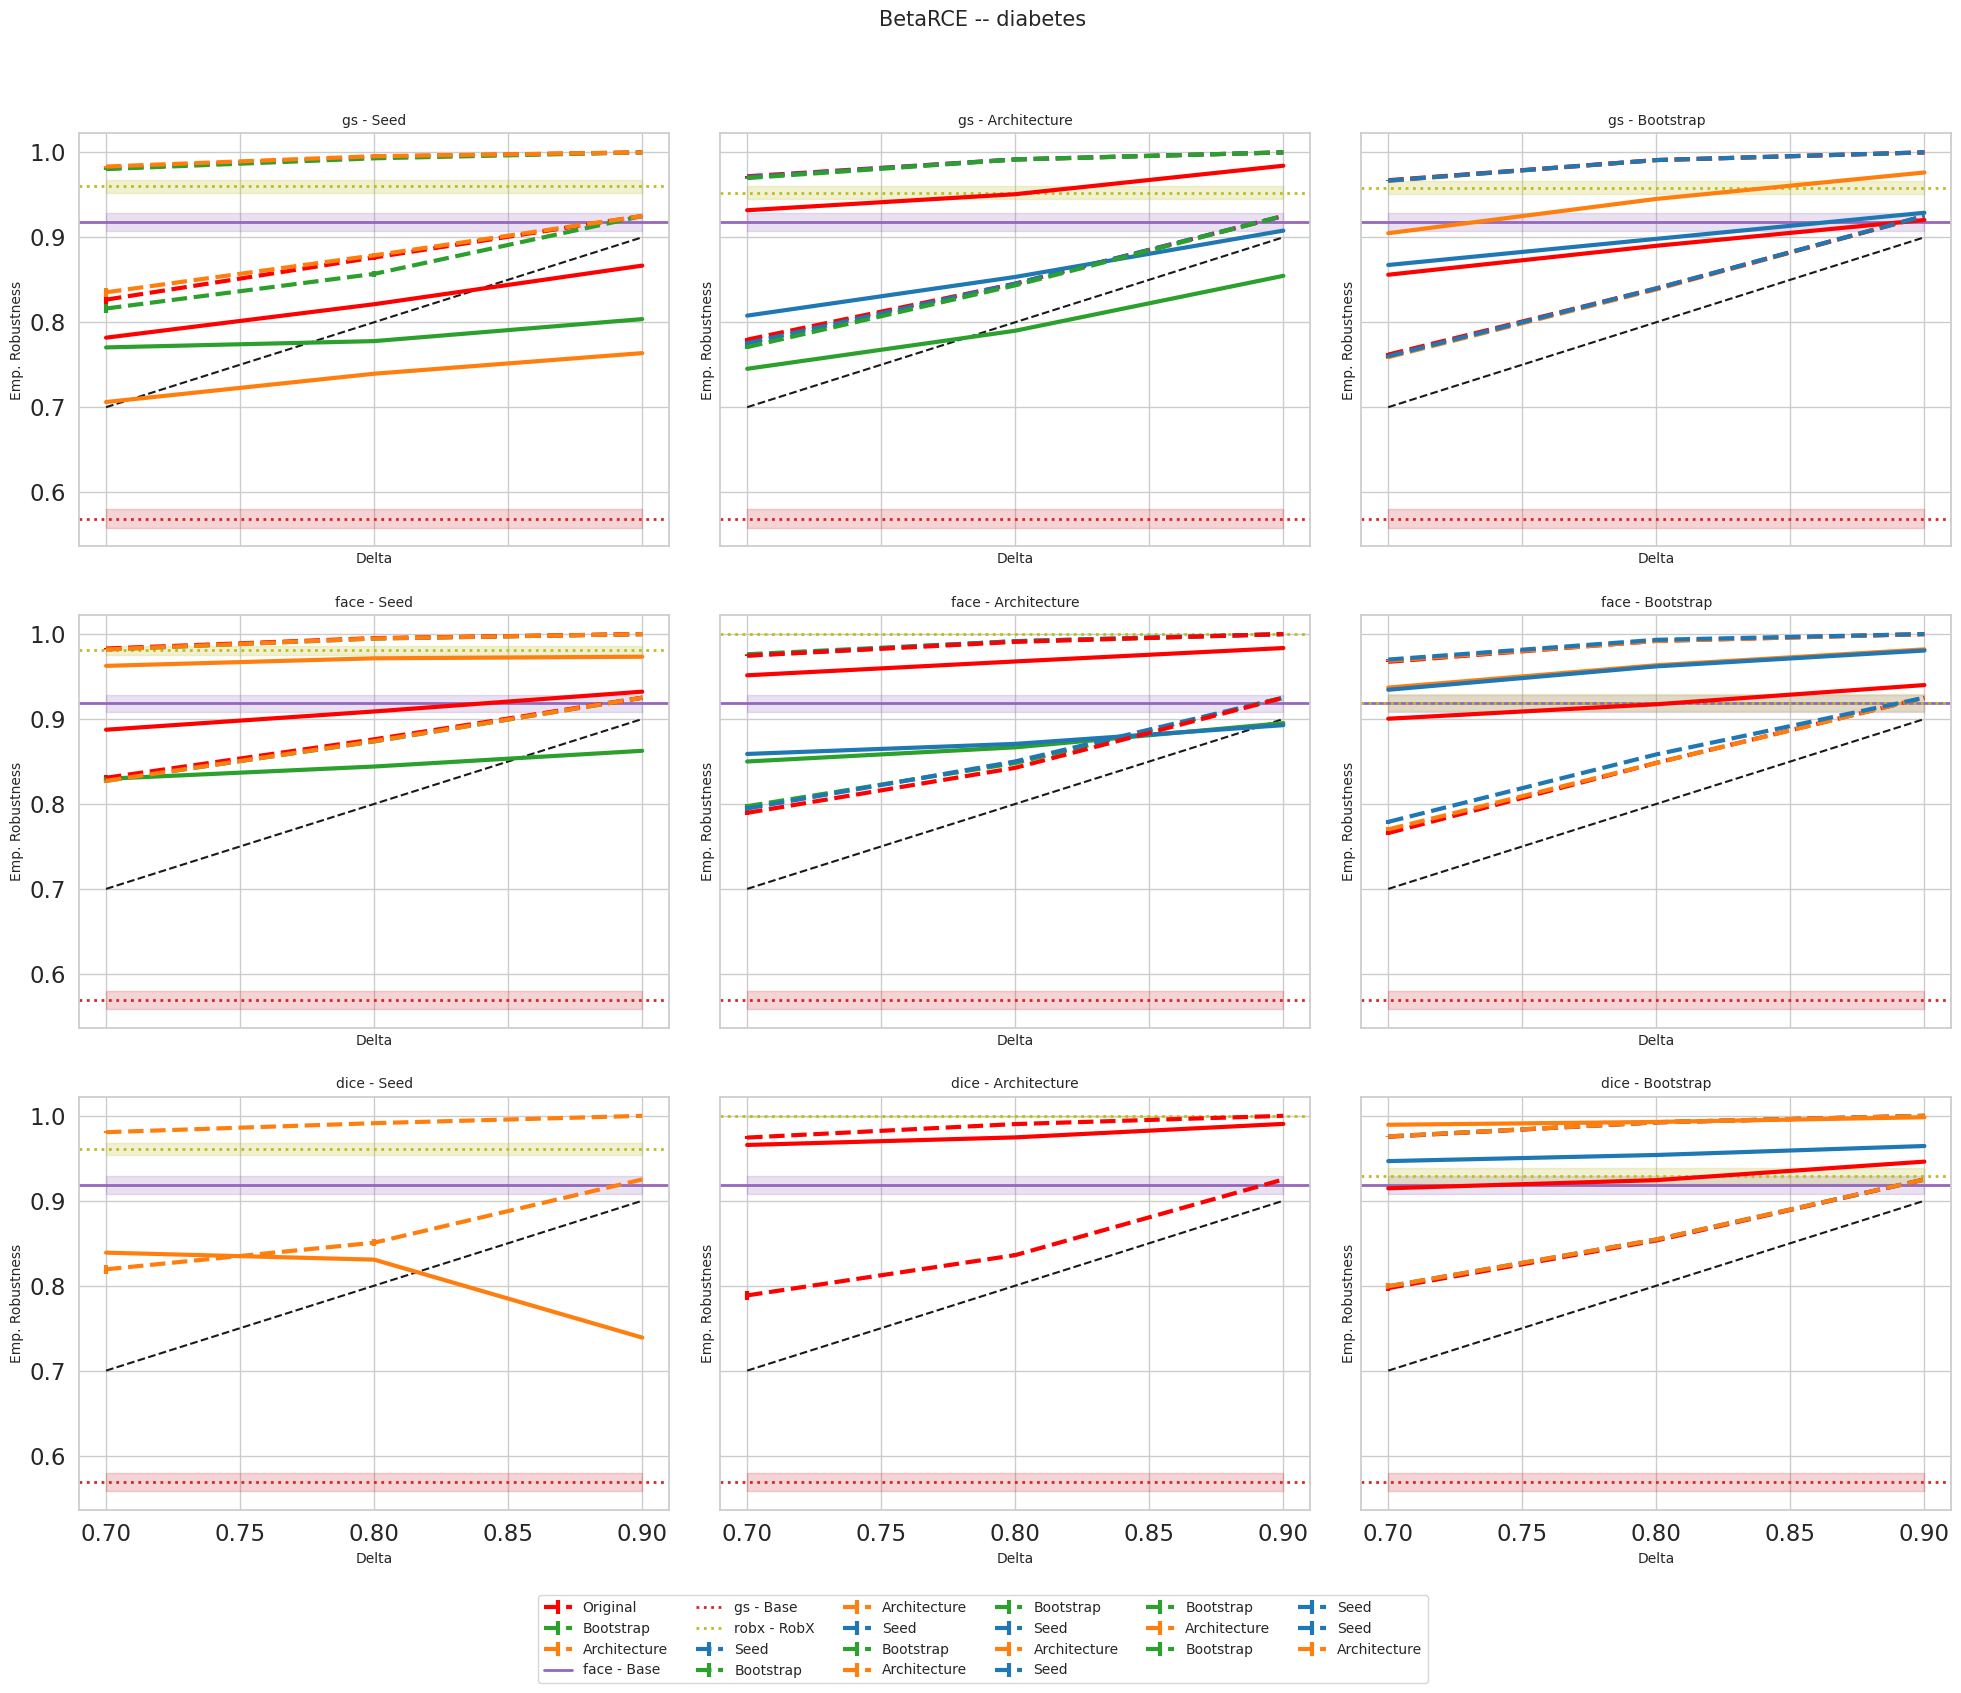

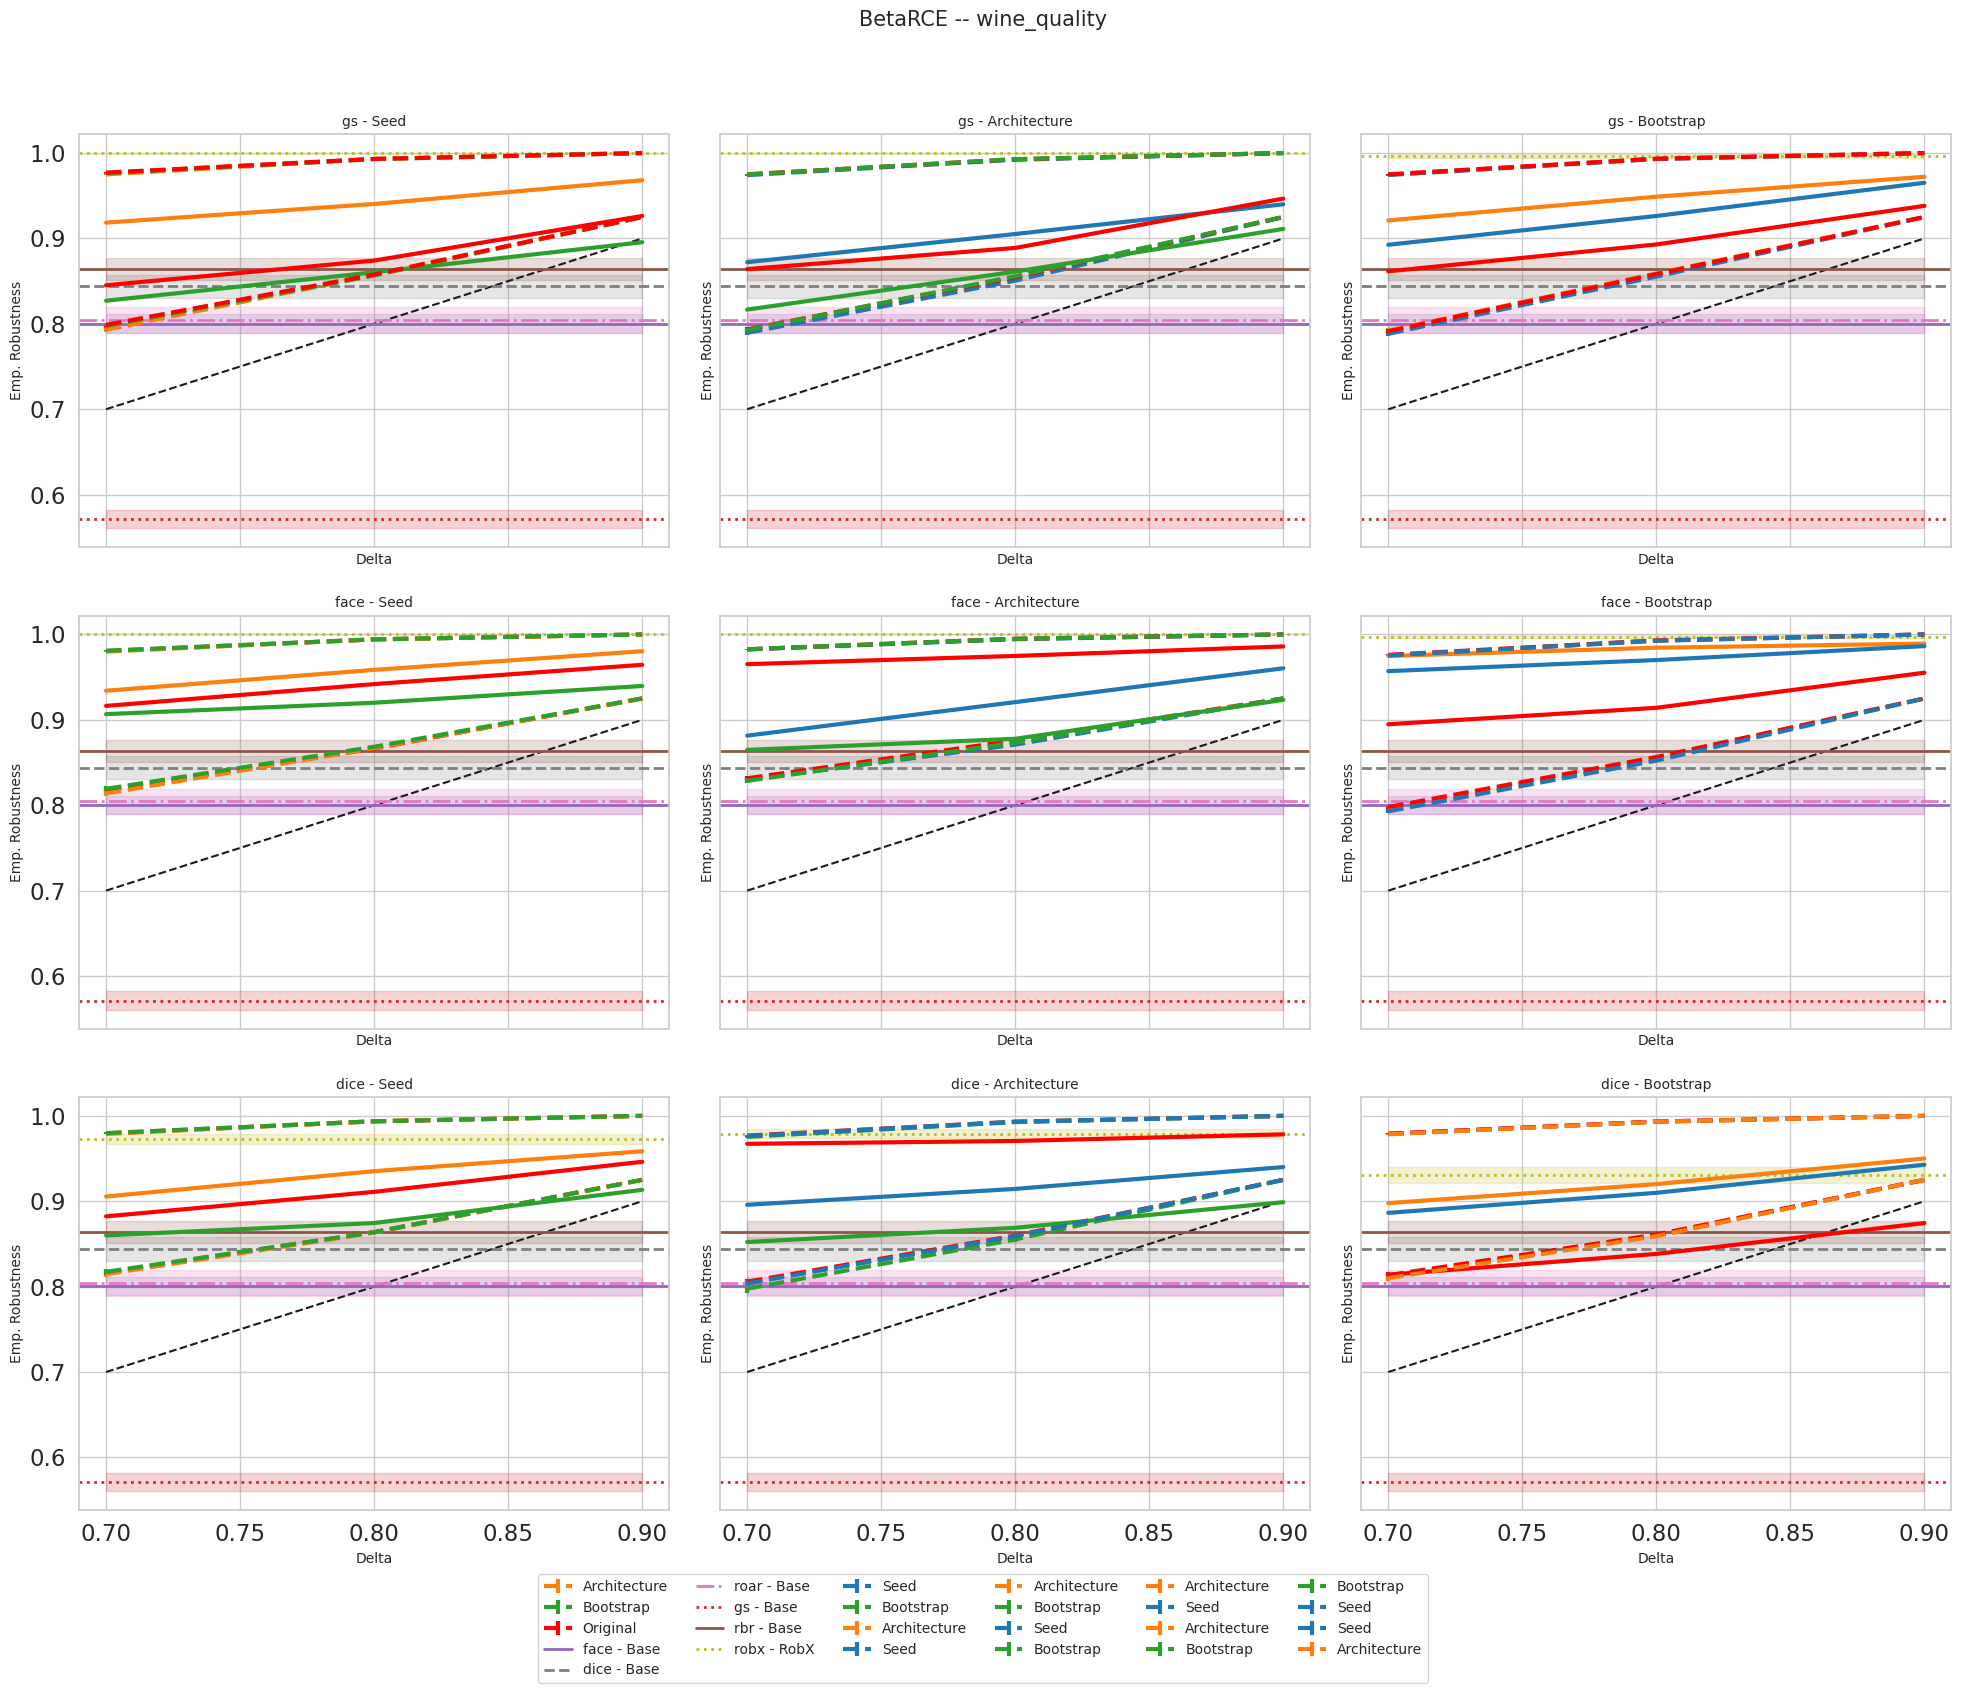

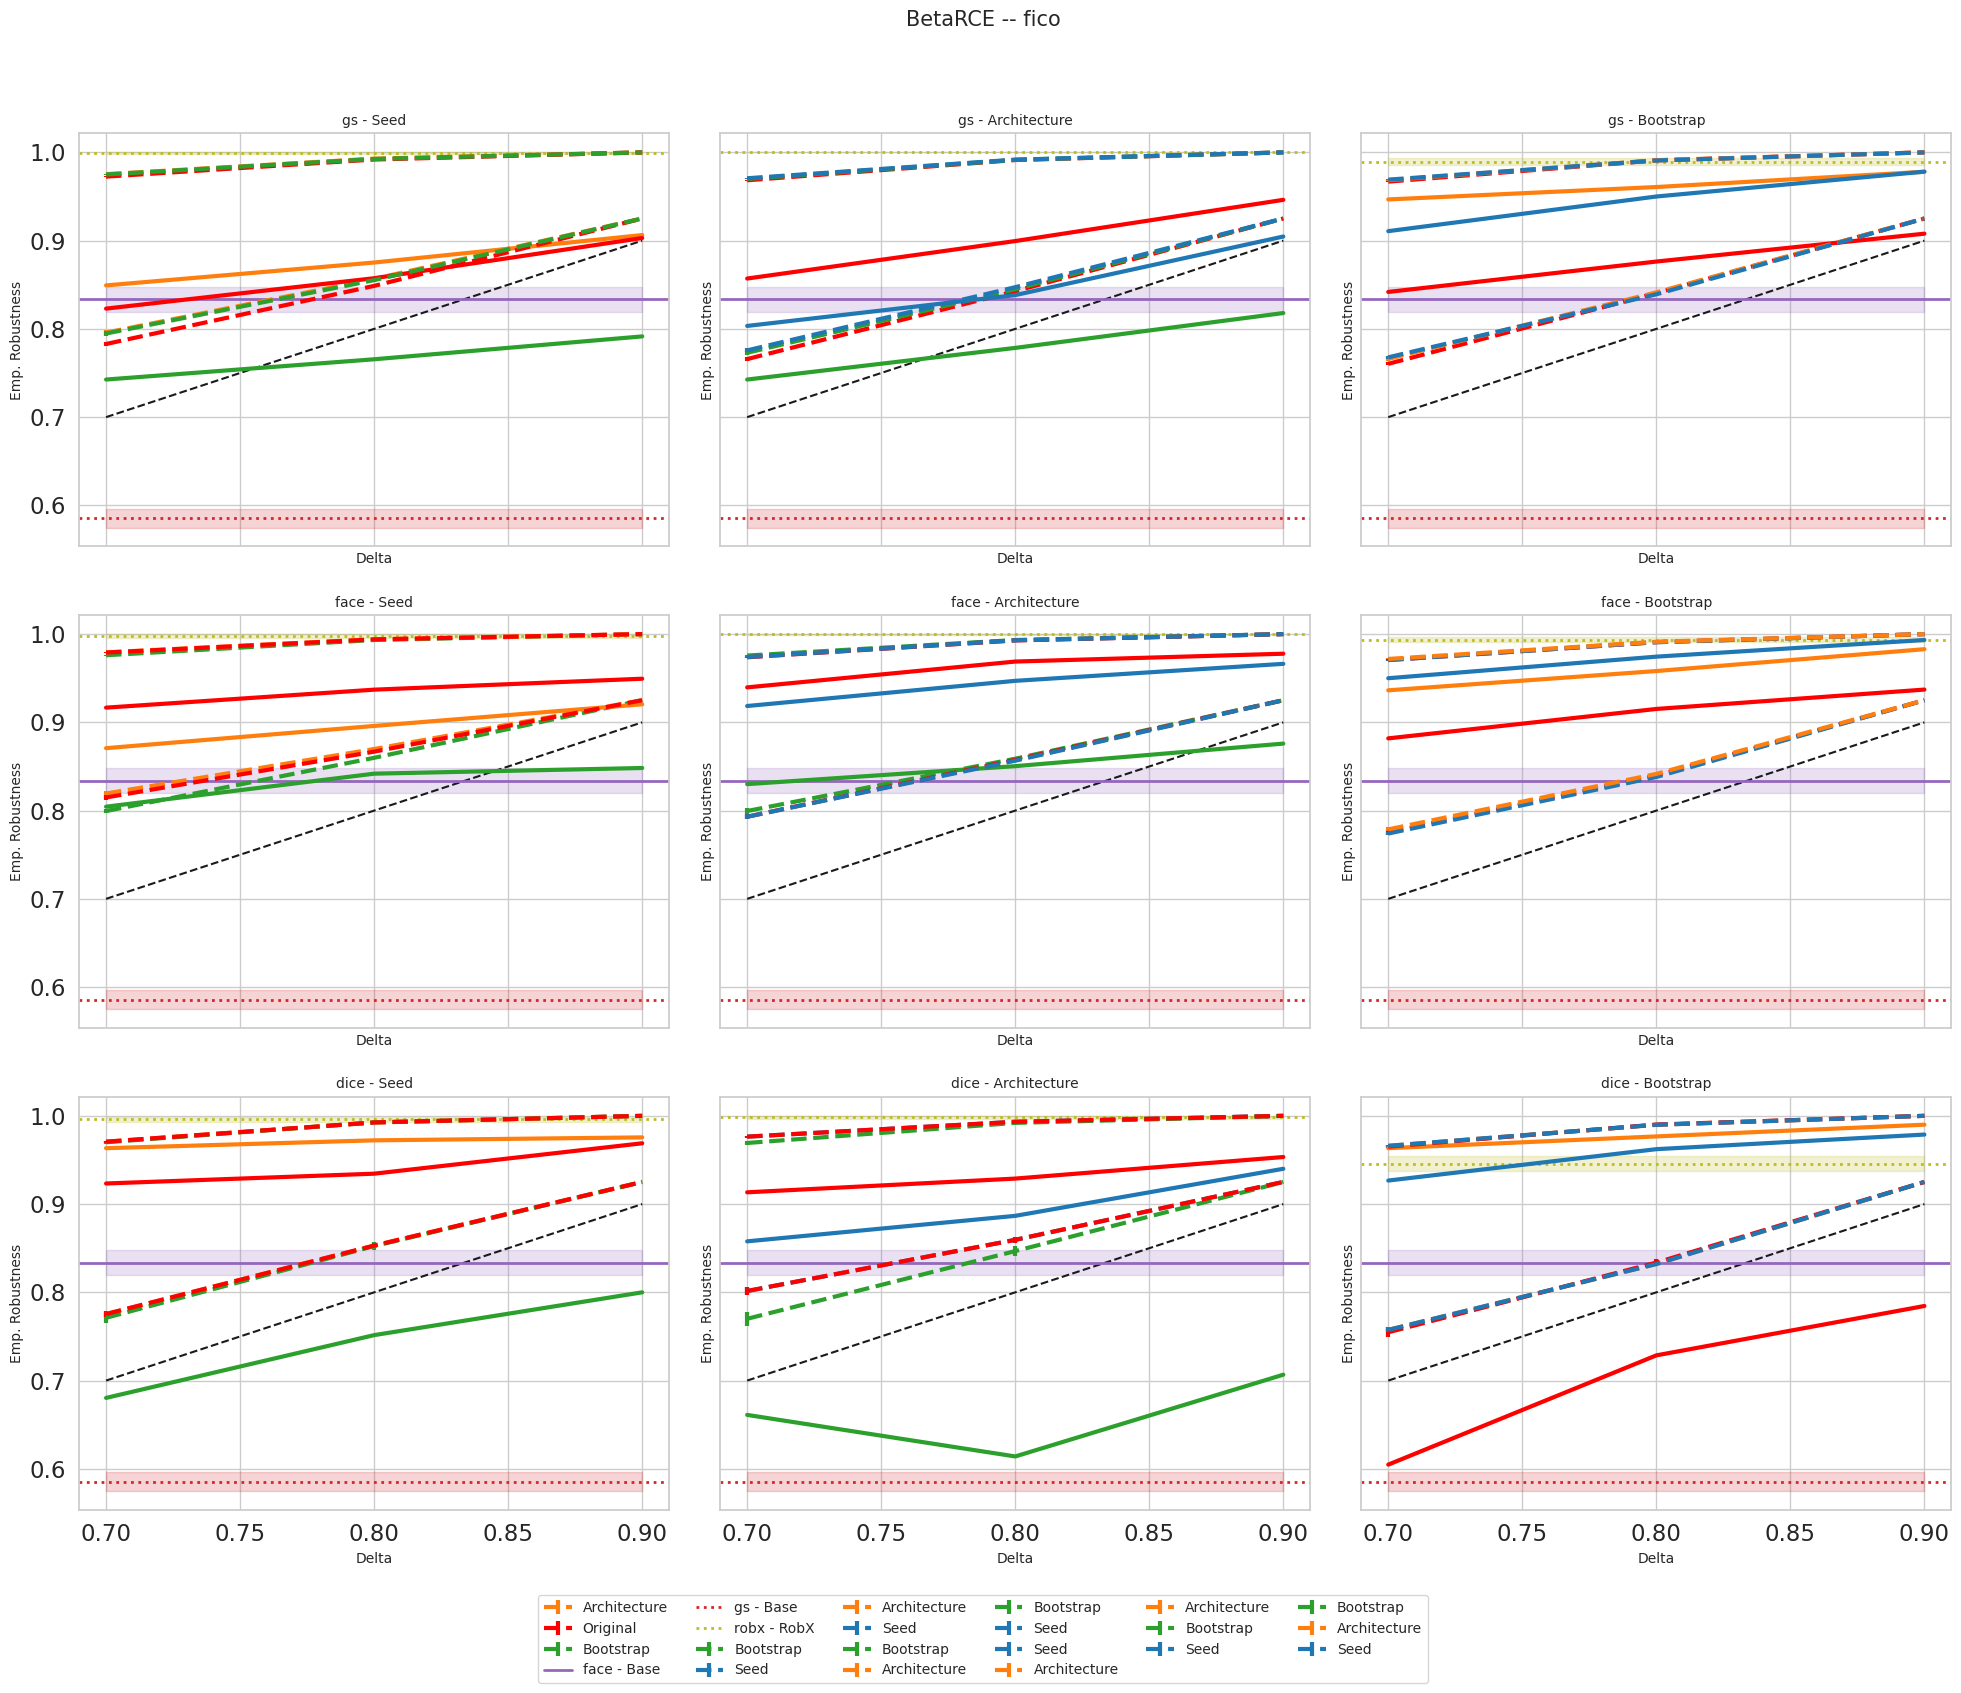

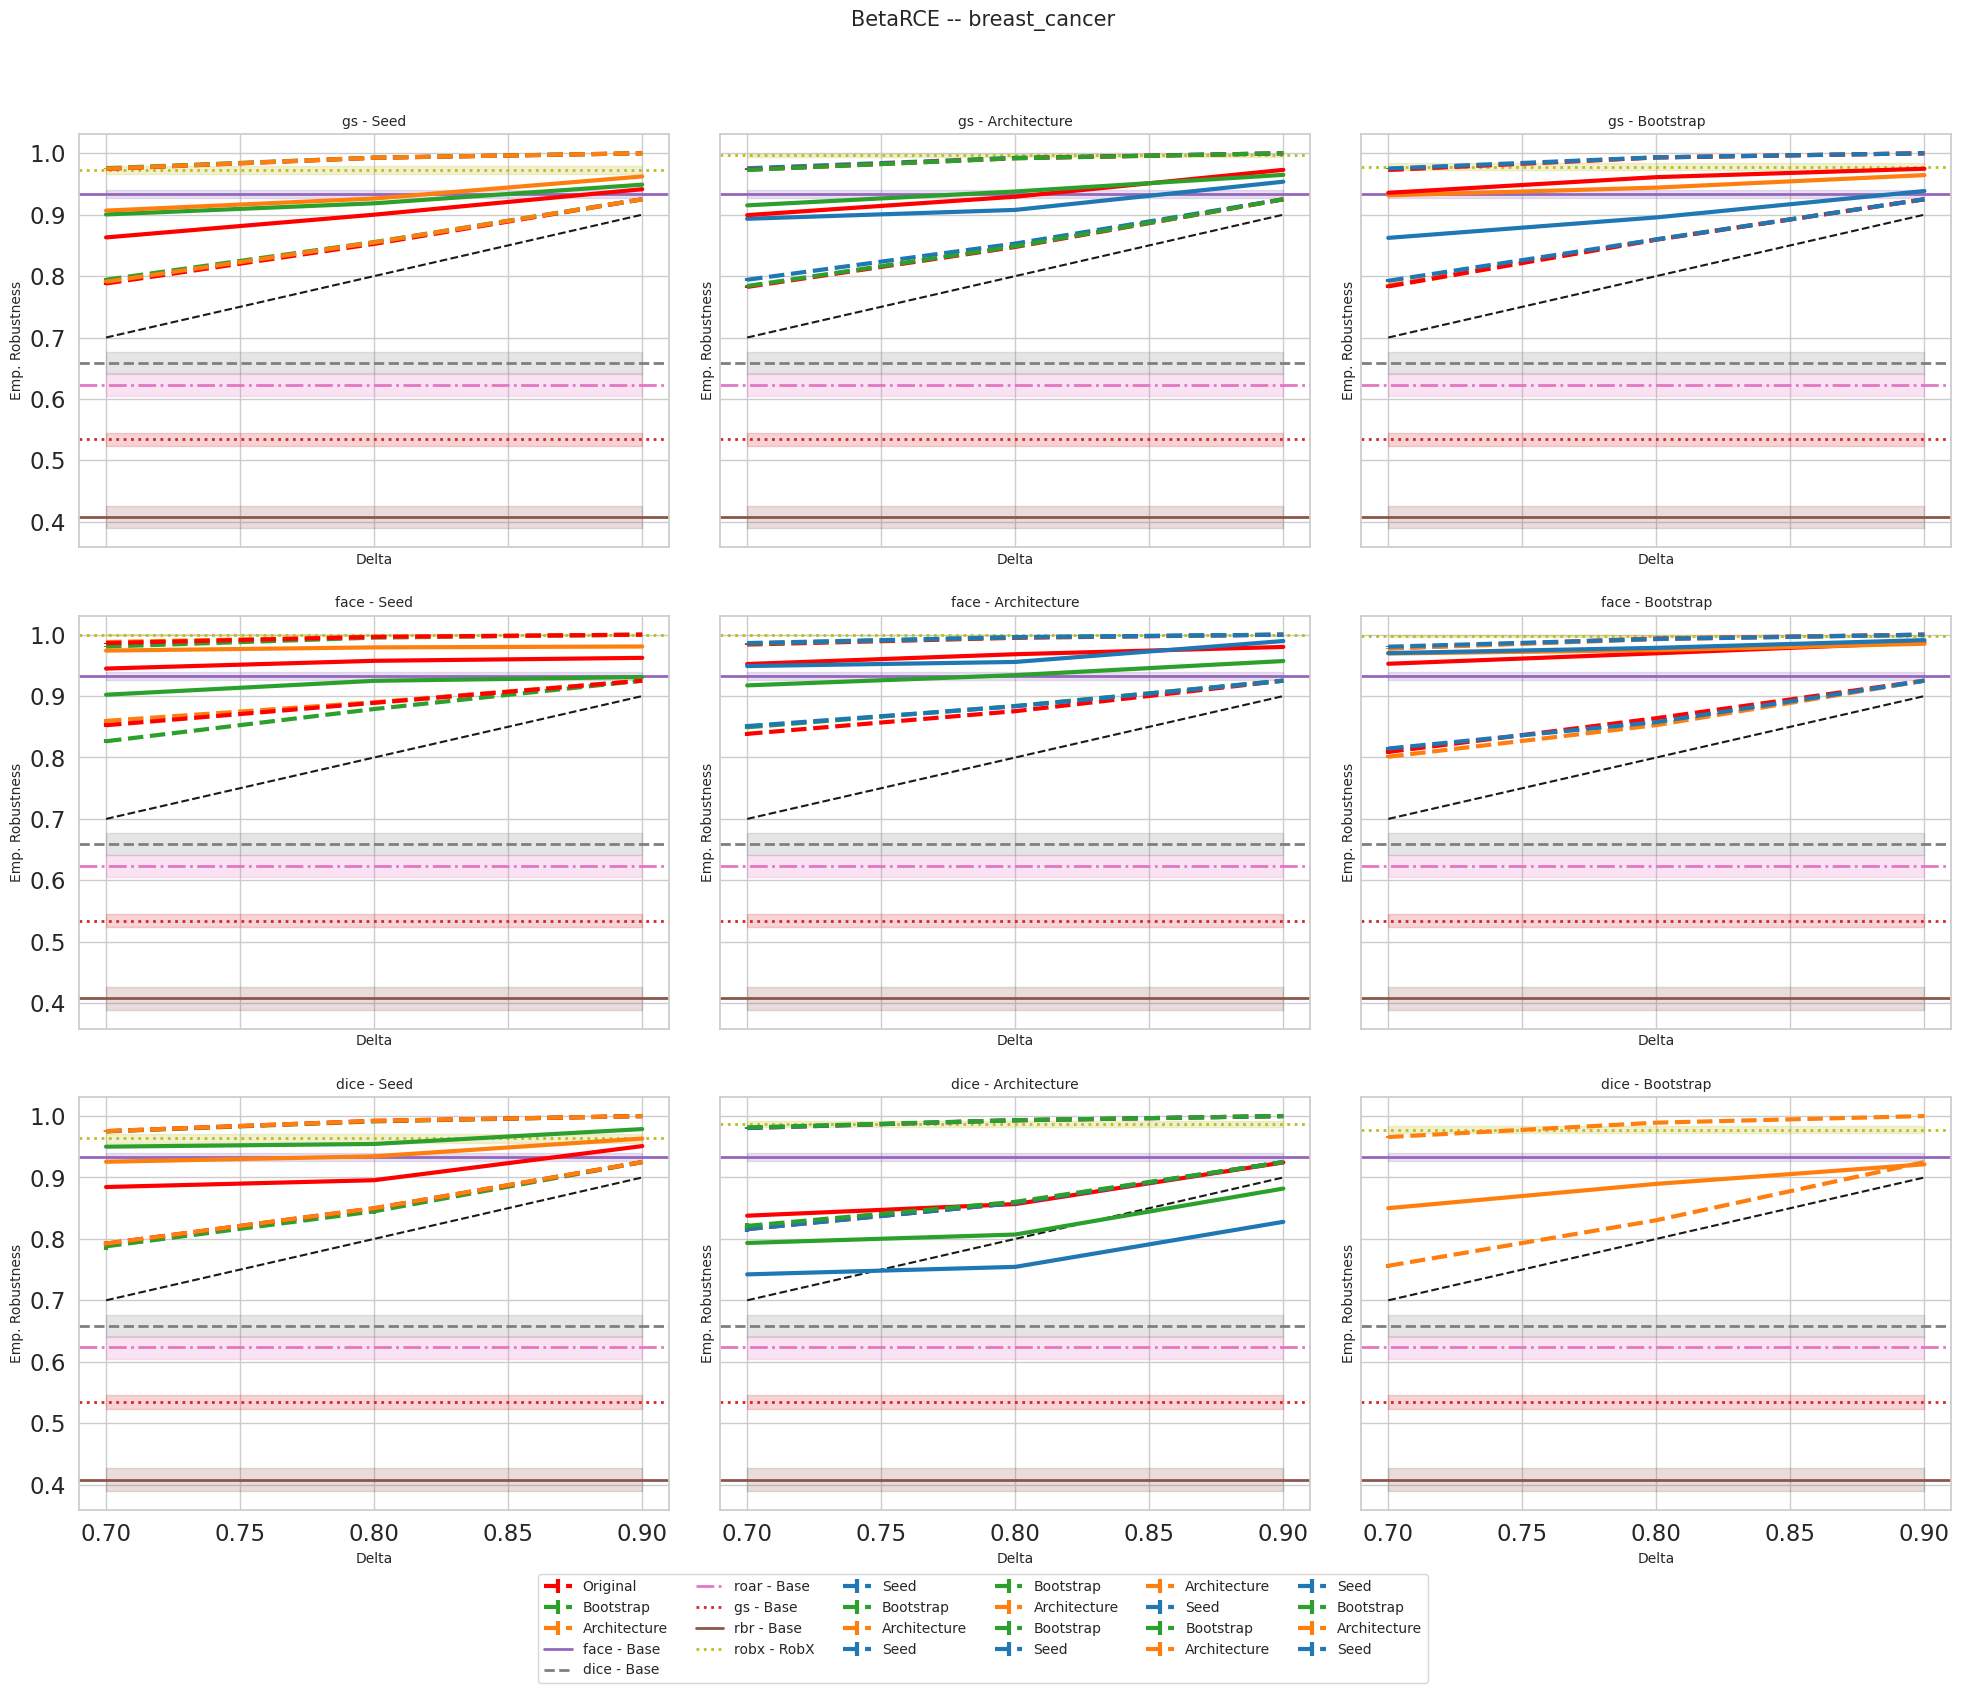

In [23]:
datasets = betarce_df['dataset_name'].unique()
base_methods = betarce_df['base_cf_method'].unique()
base_experiment_types = betarce_df['experiment_type'].unique()

base_methods_jsut_base = just_base_df['base_cf_method'].unique()
robx_methods = robx_df['robust_cf_method'].unique()

colors = {l:c for l, c in zip([*base_experiment_types, *base_methods_jsut_base, *robx_methods], colors_discrete)}

Z_SCORE = 1.96

for i, dataset in enumerate(datasets):
    fig, ax = plt.subplots(len(base_methods), len(base_experiment_types), figsize=(20, 15), sharex=True, sharey=True)
    
    # Create a list to store all legend handles and labels
    all_handles = []
    all_labels = []
    
    for j, base_method in enumerate(base_methods):
        for k, experiment_type in enumerate(base_experiment_types):
            df = robust_agg_df[
                (robust_agg_df['dataset_name'] == dataset) &
                (robust_agg_df['base_cf_method'] == base_method) &
                (robust_agg_df['experiment_type'] == experiment_type)
            ]
            
            df = df.sort_values('delta_robustness')
            
            for ex_gen_type in df['experiment_generalization_type'].unique():
                df_ex_gen_type = df[df['experiment_generalization_type'] == ex_gen_type]
                line = ax[j, k].errorbar(
                    df_ex_gen_type['delta_robustness'],
                    df_ex_gen_type['robustness'],
                    # yerr=Z_SCORE * df_ex_gen_type['robustness_std'] / np.sqrt(df_ex_gen_type['n']),
                    color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
                    linewidth=3,
                )
                
                # Lower bound beta
                line = ax[j, k].errorbar(
                    df_ex_gen_type['delta_robustness'],
                    df_ex_gen_type['lower_bound_beta'],
                    yerr=Z_SCORE * df_ex_gen_type['lower_bound_beta_std'] / np.sqrt(df_ex_gen_type['n']),
                    color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
                    linestyle='--',
                    linewidth=3,
                )
                
                # Upper bound beta
                line = ax[j, k].errorbar(
                    df_ex_gen_type['delta_robustness'],
                    df_ex_gen_type['upper_bound_beta'],
                    yerr=Z_SCORE * df_ex_gen_type['upper_bound_beta_std'] / np.sqrt(df_ex_gen_type['n']),
                    color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
                    linestyle='--',
                    linewidth=3,
                )
                
                # ax[j, k].fill_between(
                #     df_ex_gen_type['delta_robustness'],
                #     df_ex_gen_type['robustness'] - Z_SCORE * df_ex_gen_type['robustness_std'] / np.sqrt(df_ex_gen_type['n']),
                #     df_ex_gen_type['robustness'] + Z_SCORE * df_ex_gen_type['robustness_std'] / np.sqrt(df_ex_gen_type['n']),
                #     color=colors[ex_gen_type] if ex_gen_type != experiment_type else 'red',
                #     alpha=0.2
                # )
                
                # Add to legend only once
                if ex_gen_type if ex_gen_type != experiment_type else 'Original' not in all_labels:
                    all_handles.append(line)
                    all_labels.append(ex_gen_type if ex_gen_type != experiment_type else 'Original')
                
            min_Delta = df['delta_robustness'].min()
            max_Delta = df['delta_robustness'].max()
            line = ax[j, k].plot([min_Delta, max_Delta], [min_Delta, max_Delta], 'k--')
            
            if ('y=x' not in all_labels):
                all_handles.append(line)
                all_labels.append('y=x')
            
            for ll, jst_base_method in enumerate(base_agg_df['base_cf_method'].unique()):
                df = base_agg_df[
                    (base_agg_df['dataset_name'] == dataset) &
                    (base_agg_df['base_cf_method'] == jst_base_method) 
                ]
                
                if len(df) > 0:
                    line = ax[j, k].axhline(df['robustness'].values[0], 
                        color=colors[jst_base_method], 
                        linestyle=linestyles[ll],
                        linewidth=2,
                    )
                    ax[j, k].fill_between(
                        [min_Delta, max_Delta],
                        df['robustness'].values[0] - Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
                        df['robustness'].values[0] + Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
                        color=colors[jst_base_method],
                        alpha=0.2
                    )
                    
                    if f'{jst_base_method} - Base' not in all_labels:
                        all_handles.append(line)
                        all_labels.append(f'{jst_base_method} - Base')
            
            for ll, robx_method in enumerate(robx_agg_df['robust_cf_method'].unique()):
                df = robx_agg_df[
                    (robx_agg_df['dataset_name'] == dataset) &
                    (robx_agg_df['base_cf_method'] == base_method) &
                    (robx_agg_df['experiment_type'] == experiment_type) &
                    (robx_agg_df['robust_cf_method'] == robx_method)
                ]
                
                if len(df) > 0:
                    line = ax[j, k].axhline(df['robustness'].values[0], 
                        color=colors[robx_method], 
                        linestyle=linestyles[3],
                        linewidth=2,
                    )
                    ax[j, k].fill_between(
                        [min_Delta, max_Delta],
                        df['robustness'].values[0] - Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
                        df['robustness'].values[0] + Z_SCORE * df['robustness_std'].values[0] / np.sqrt(df['n'].values[0]),
                        color=colors[robx_method],
                        alpha=0.2
                    )
                    
                    if f'{robx_method} - RobX' not in all_labels:
                        all_handles.append(line)
                        all_labels.append(f'{robx_method} - RobX')
            
            ax[j, k].set_title(f'{base_method} - {experiment_type}', fontsize=10)
            ax[j, k].set_ylabel('Emp. Robustness', fontsize=10)
            ax[j, k].set_xlabel('Delta', fontsize=10)
    
    plt.suptitle(f'BetaRCE -- {dataset}', fontsize=15, y=1.02)
    
    # Create a single legend for the entire figure
    fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
               ncol=min(len(all_labels), 6), fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.02)  # Adjust bottom to make room for the legend
    plt.show()

In [28]:

def create_summary_table(dataset, base_method, experiment_type):
    # Filter the data
    df = robust_agg_df[
        (robust_agg_df['dataset_name'] == dataset) &
        (robust_agg_df['base_cf_method'] == base_method) &
        (robust_agg_df['experiment_type'] == experiment_type)
    ]
    
    # Create a summary DataFrame
    summary = []
    
    # Add BetaRCE results
    for ex_gen_type in df['experiment_generalization_type'].unique():
        df_ex_gen_type = df[df['experiment_generalization_type'] == ex_gen_type]
        summary.append({
            'Method': f'BetaRCE ({ex_gen_type})',
            'Robustness': f"{df_ex_gen_type['robustness'].mean():.3f} ± {Z_SCORE * df_ex_gen_type['robustness_std'].mean() / np.sqrt(df_ex_gen_type['n'].mean()):.3f}",
            'Lower Bound Beta': f"{df_ex_gen_type['lower_bound_beta'].mean():.3f} ± {Z_SCORE * df_ex_gen_type['lower_bound_beta_std'].mean() / np.sqrt(df_ex_gen_type['n'].mean()):.3f}",
            'Upper Bound Beta': f"{df_ex_gen_type['upper_bound_beta'].mean():.3f} ± {Z_SCORE * df_ex_gen_type['upper_bound_beta_std'].mean() / np.sqrt(df_ex_gen_type['n'].mean()):.3f}",
        })
    
    # Add base method results
    base_df = base_agg_df[
        (base_agg_df['dataset_name'] == dataset) &
        (base_agg_df['base_cf_method'] == base_method)
    ]
    if len(base_df) > 0:
        summary.append({
            'Method': f'{base_method} - Base',
            'Robustness': f"{base_df['robustness'].values[0]:.3f} ± {Z_SCORE * base_df['robustness_std'].values[0] / np.sqrt(base_df['n'].values[0]):.3f}",
            'Lower Bound Beta': 'N/A',
            'Upper Bound Beta': 'N/A',
        })
    
    # Add RobX results
    for robx_method in robx_agg_df['robust_cf_method'].unique():
        robx_df = robx_agg_df[
            (robx_agg_df['dataset_name'] == dataset) &
            (robx_agg_df['base_cf_method'] == base_method) &
            (robx_agg_df['experiment_type'] == experiment_type) &
            (robx_agg_df['robust_cf_method'] == robx_method)
        ]
        if len(robx_df) > 0:
            summary.append({
                'Method': f'{robx_method} - RobX',
                'Robustness': f"{robx_df['robustness'].values[0]:.3f} ± {Z_SCORE * robx_df['robustness_std'].values[0] / np.sqrt(robx_df['n'].values[0]):.3f}",
                'Lower Bound Beta': 'N/A',
                'Upper Bound Beta': 'N/A',
            })
    
    # Create the summary DataFrame
    summary_df = pd.DataFrame(summary)
    
    return summary_df

# Create tables for each combination
for dataset in datasets:
    for base_method in base_methods:
        for experiment_type in base_experiment_types:
            summary_df = create_summary_table(dataset, base_method, experiment_type)
            print(f"\nSummary for {dataset} - {base_method} - {experiment_type}")
            print(summary_df.to_string(index=False))
            print("\n")


Summary for breast_cancer - dice - Seed
                Method    Robustness Lower Bound Beta Upper Bound Beta
        BetaRCE (Seed) 0.910 ± 0.018    0.856 ± 0.002    0.989 ± 0.000
   BetaRCE (Bootstrap) 0.961 ± 0.020    0.853 ± 0.004    0.989 ± 0.001
BetaRCE (Architecture) 0.941 ± 0.015    0.856 ± 0.002    0.989 ± 0.000
           dice - Base 0.659 ± 0.018              N/A              N/A
           robx - RobX 0.964 ± 0.007              N/A              N/A



Summary for breast_cancer - dice - Architecture
                Method    Robustness Lower Bound Beta Upper Bound Beta
   BetaRCE (Bootstrap) 0.827 ± 0.027    0.869 ± 0.003    0.992 ± 0.001
BetaRCE (Architecture) 0.873 ± 0.021    0.867 ± 0.003    0.991 ± 0.001
        BetaRCE (Seed) 0.775 ± 0.027    0.867 ± 0.003    0.991 ± 0.001
           dice - Base 0.659 ± 0.018              N/A              N/A
           robx - RobX 0.987 ± 0.004              N/A              N/A



Summary for breast_cancer - dice - Bootstrap
        

In [24]:
ksweep_agg_by = ['dataset_name', 'base_cf_method', 'experiment_type', 'k_mlps_in_B']
ksweep_agg_df = ksweep_df.groupby(ksweep_agg_by).agg(
    n=('base_counterfactual_validity_model2', 'count'),
    vailidity=('base_counterfactual_validity', 'mean'),
    validity_std=('base_counterfactual_validity', 'std'),
    robustness=('robust_counterfactual_validity_model2', 'mean'),
    robustness_std=('robust_counterfactual_validity_model2', 'std'),
    proximityL1=('robust_counterfactual_proximityL1', 'mean'),
    proximityL1_std=('robust_counterfactual_proximityL1', 'std'),
    proximityL2=('robust_counterfactual_proximityL2', 'mean'),
    proximityL2_std=('robust_counterfactual_proximityL2', 'std'),
    plausibility=('robust_counterfactual_plausibility', 'mean'),
    plausibility_std=('robust_counterfactual_plausibility', 'std'),
    dpow=('robust_counterfactual_discriminative_power', 'mean'),
    dpow_std=('robust_counterfactual_discriminative_power', 'std'),
).reset_index()

ksweep_agg_df.round(2)

dataset_name base_cf_method experiment_type  k_mlps_in_B     n  \
0    breast_cancer           dice    Architecture            8  4500   
1    breast_cancer           dice    Architecture           12  4500   
2    breast_cancer           dice    Architecture           16  4500   
3    breast_cancer           dice    Architecture           20  1201   
4    breast_cancer           dice       Bootstrap            8  4500   
..             ...            ...             ...          ...   ...   
153   wine_quality             gs            Seed           24  4500   
154   wine_quality             gs            Seed           28  4500   
155   wine_quality             gs            Seed           32  4500   
156   wine_quality             gs            Seed           36  4500   
157   wine_quality             gs            Seed           40  2101   

     vailidity  validity_std  robustness  robustness_std  proximityL1  \
0          1.0           0.0         NaN             NaN          NaN   
1          1.0           0.0         NaN             NaN          NaN   
2          1.0           0.0         NaN             NaN          NaN   
3          1.0           0.0        1.00            0.07         3.80   
4          1.0           0.0         NaN             NaN          NaN   
..         ...           ...         ...             ...          ...   
153        1.0           0.0        0.95            0.22         0.67   
154        1.0           0.0        0.96            0.20         0.74   
155        1.0           0.0        0.92            0.27         0.62   
156        1.0           0.0        0.95            0.21         0.64   
157        1.0           0.0        0.94            0.25         0.62   

     proximityL1_std  proximityL2  proximityL2_std  plausibility  \
0                NaN          NaN              NaN           NaN   
1                NaN          NaN              NaN           NaN   
2                NaN          NaN              NaN           NaN   
3               3.07         1.15             0.64          1.13   
4                NaN          NaN              NaN           NaN   
..               ...          ...              ...           ...   
153             0.40         0.25             0.14          0.25   
154             0.51         0.27             0.19          0.26   
155             0.43         0.23             0.16          0.23   
156             0.46         0.24             0.17          0.24   
157             0.34         0.23             0.13          0.25   

     plausibility_std  dpow  dpow_std  
0                 NaN   NaN       NaN  
1                 NaN   NaN       NaN  
2                 NaN   NaN       NaN  
3                0.58  0.42      0.25  
4                 NaN   NaN       NaN  
..                ...   ...       ...  
153              0.12  0.59      0.19  
154              0.14  0.62      0.18  
155              0.13  0.59      0.17  
156              0.13  0.60      0.17  
157              0.12  0.58      0.17  

[158 rows x 17 columns]

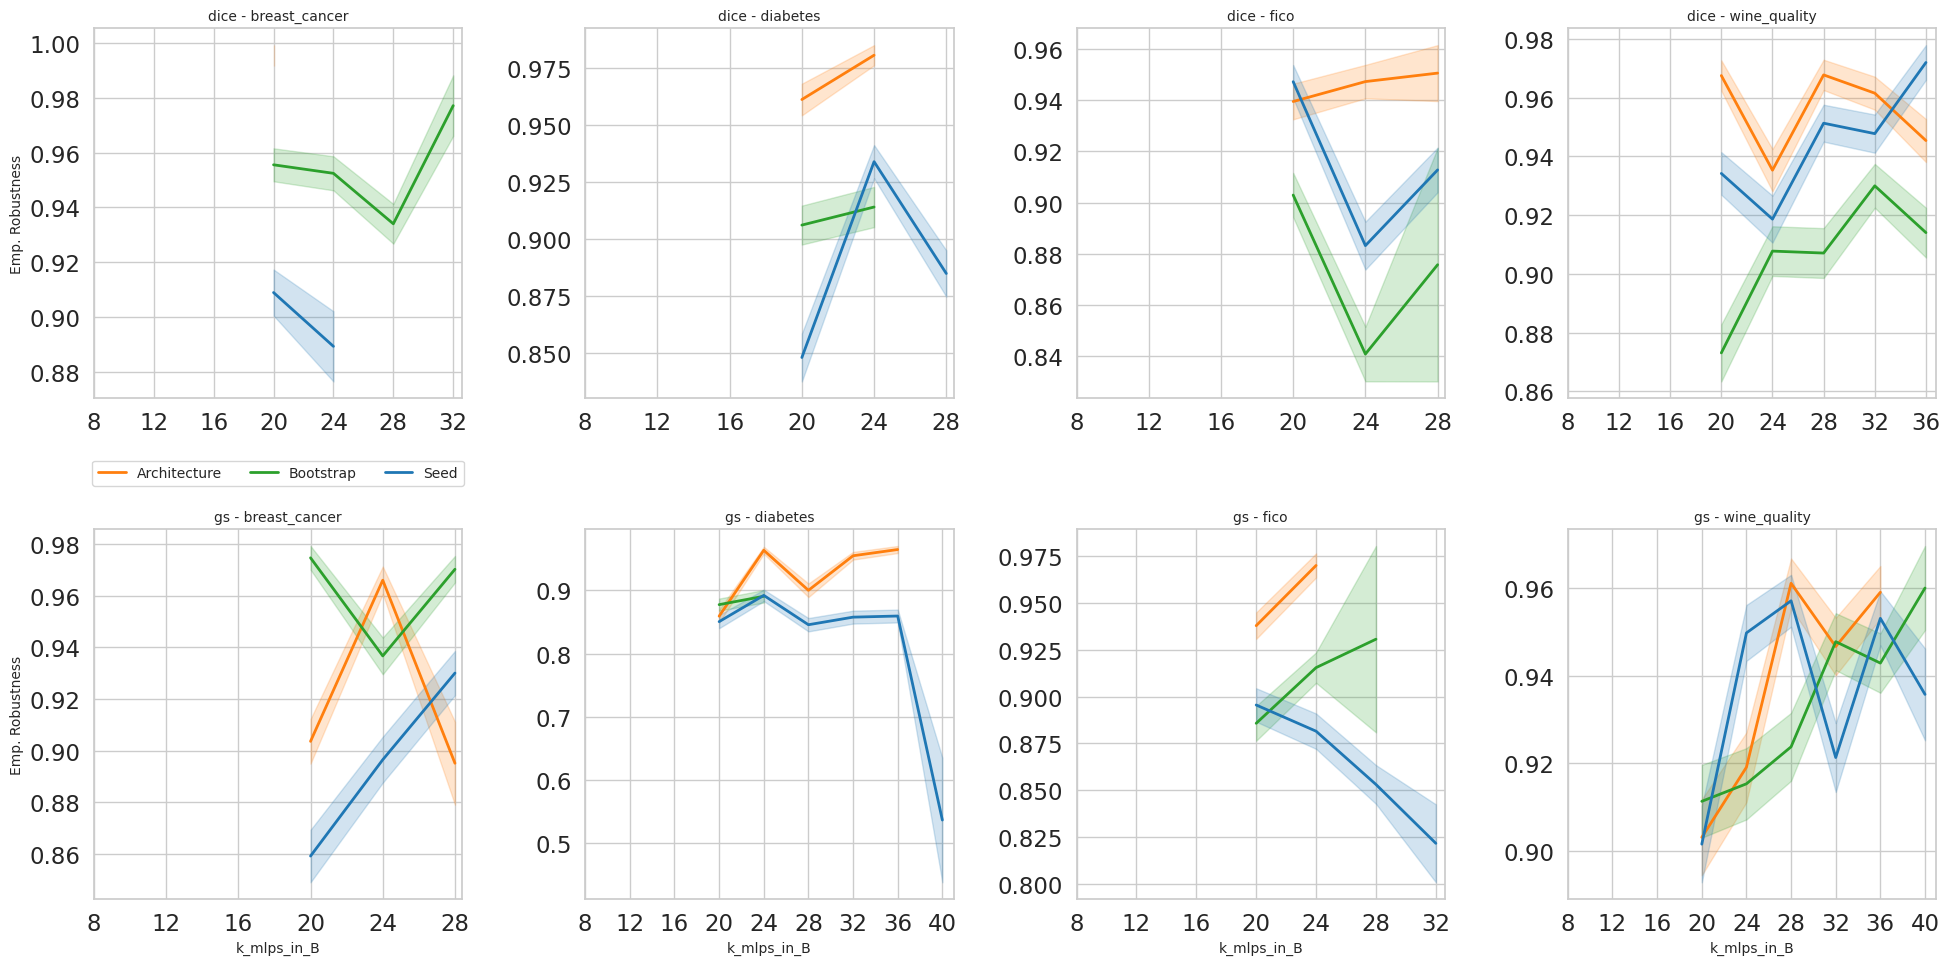

In [25]:
# Determine the number of unique base methods and datasets
base_methods = ksweep_agg_df['base_cf_method'].unique()
datasets = ksweep_agg_df['dataset_name'].unique()
n_rows = len(base_methods)
n_cols = len(datasets)

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), squeeze=False)

for i, base_method in enumerate(base_methods):
    for j, dataset in enumerate(datasets):
        ax = axs[i, j]
        df = ksweep_agg_df[
            (ksweep_agg_df['dataset_name'] == dataset) &
            (ksweep_agg_df['base_cf_method'] == base_method)
        ]
        for experiment_type in df['experiment_type'].unique():
            df_ex = df[df['experiment_type'] == experiment_type]
            ax.errorbar(
                df_ex['k_mlps_in_B'],
                df_ex['robustness'],
                label=experiment_type,
                color=colors[experiment_type],
                linewidth=2,
            )
            ax.fill_between(
                df_ex['k_mlps_in_B'],
                df_ex['robustness'] - Z_SCORE * df_ex['robustness_std'] / np.sqrt(df_ex['n']),
                df_ex['robustness'] + Z_SCORE * df_ex['robustness_std'] / np.sqrt(df_ex['n']),
                color=colors[experiment_type],
                alpha=0.2
            )
        
        ax.set_xticks(sorted(df['k_mlps_in_B'].unique()))
        ax.set_title(f'{base_method} - {dataset}', fontsize=10)
        if j == 0:  # Only set ylabel for the leftmost column
            ax.set_ylabel('Emp. Robustness', fontsize=10)
        if i == n_rows - 1:  # Only set xlabel for the bottom row
            ax.set_xlabel('k_mlps_in_B', fontsize=10)
        
        # Set legend only for the first subplot
        if i == 0 and j == 0:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10)

plt.tight_layout()
plt.show()

In [26]:
brce_params_df_agg_by = ['dataset_name', 'base_cf_method', 'experiment_type', 'delta_robustness', 'beta_confidence']
brce_params_agg_df = brce_params_df.groupby(brce_params_df_agg_by).agg(
    n=('base_counterfactual_validity_model2', 'count'),
    vailidity=('base_counterfactual_validity', 'mean'),
    validity_std=('base_counterfactual_validity', 'std'),
    robustness=('robust_counterfactual_validity_model2', 'mean'),
    robustness_std=('robust_counterfactual_validity_model2', 'std'),
    proximityL1=('robust_counterfactual_proximityL1', 'mean'),
    proximityL1_std=('robust_counterfactual_proximityL1', 'std'),
    proximityL2=('robust_counterfactual_proximityL2', 'mean'),
    proximityL2_std=('robust_counterfactual_proximityL2', 'std'),
    plausibility=('robust_counterfactual_plausibility', 'mean'),
    plausibility_std=('robust_counterfactual_plausibility', 'std'),
    dpow=('robust_counterfactual_discriminative_power', 'mean'),
    dpow_std=('robust_counterfactual_discriminative_power', 'std'),
).reset_index()

brce_params_agg_df.round(2)

dataset_name base_cf_method experiment_type  delta_robustness  \
0    breast_cancer           dice    Architecture               0.6   
1    breast_cancer           dice    Architecture               0.6   
2    breast_cancer           dice    Architecture               0.6   
3    breast_cancer           dice    Architecture               0.6   
4    breast_cancer           dice    Architecture               0.7   
..             ...            ...             ...               ...   
379   wine_quality             gs            Seed               0.8   
380   wine_quality             gs            Seed               0.9   
381   wine_quality             gs            Seed               0.9   
382   wine_quality             gs            Seed               0.9   
383   wine_quality             gs            Seed               0.9   

     beta_confidence     n  vailidity  validity_std  robustness  \
0                0.6   360        1.0           0.0        0.93   
1                0.7   360        1.0           0.0        0.94   
2                0.8   360        1.0           0.0        0.94   
3                0.9   360        1.0           0.0        0.94   
4                0.6   360        1.0           0.0        0.95   
..               ...   ...        ...           ...         ...   
379              0.9  1681        1.0           0.0        0.92   
380              0.6  1710        1.0           0.0        0.93   
381              0.7  1710        1.0           0.0        0.94   
382              0.8  1710        1.0           0.0        0.93   
383              0.9  1680        1.0           0.0        0.95   

     robustness_std  proximityL1  proximityL1_std  proximityL2  \
0              0.25         2.61             1.18         1.07   
1              0.24         2.68             1.24         1.08   
2              0.24         2.69             1.22         1.08   
3              0.24         2.78             1.29         1.09   
4              0.22         2.96             1.36         1.11   
..              ...          ...              ...          ...   
379            0.27         0.52             0.32         0.19   
380            0.25         0.54             0.32         0.20   
381            0.25         0.54             0.32         0.20   
382            0.25         0.55             0.33         0.20   
383            0.21         0.60             0.36         0.22   

     proximityL2_std  plausibility  plausibility_std  dpow  dpow_std  
0               0.27          1.09              0.27  0.37      0.26  
1               0.27          1.09              0.27  0.38      0.25  
2               0.27          1.09              0.27  0.37      0.25  
3               0.27          1.10              0.28  0.38      0.25  
4               0.27          1.11              0.29  0.40      0.25  
..               ...           ...               ...   ...       ...  
379             0.12          0.23              0.12  0.53      0.19  
380             0.12          0.24              0.13  0.54      0.18  
381             0.12          0.23              0.12  0.54      0.19  
382             0.12          0.24              0.13  0.54      0.19  
383             0.13          0.24              0.13  0.56      0.18  

[384 rows x 18 columns]

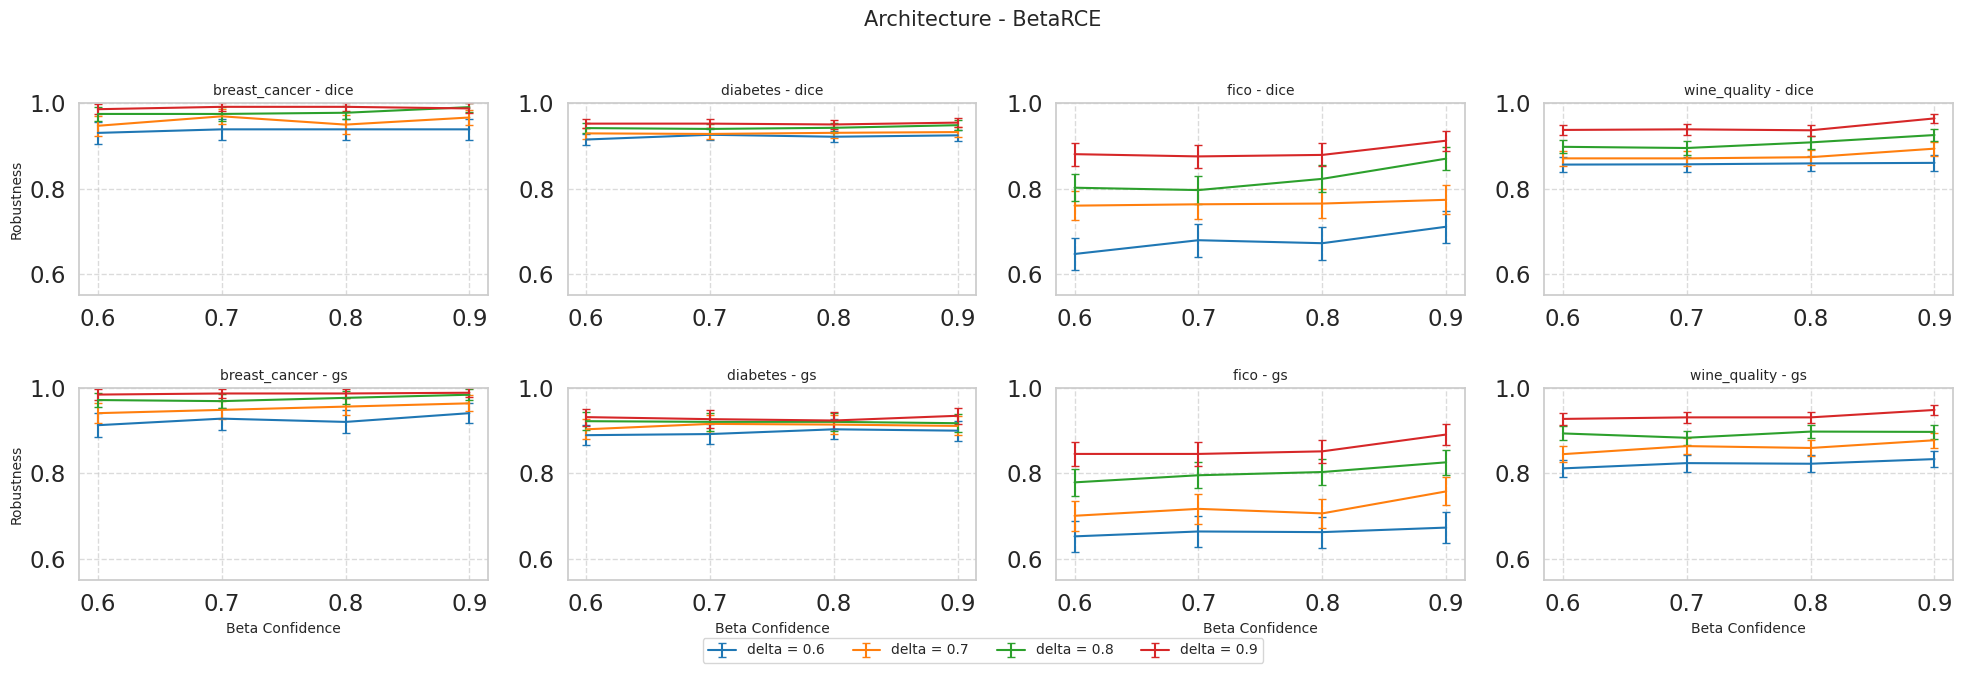

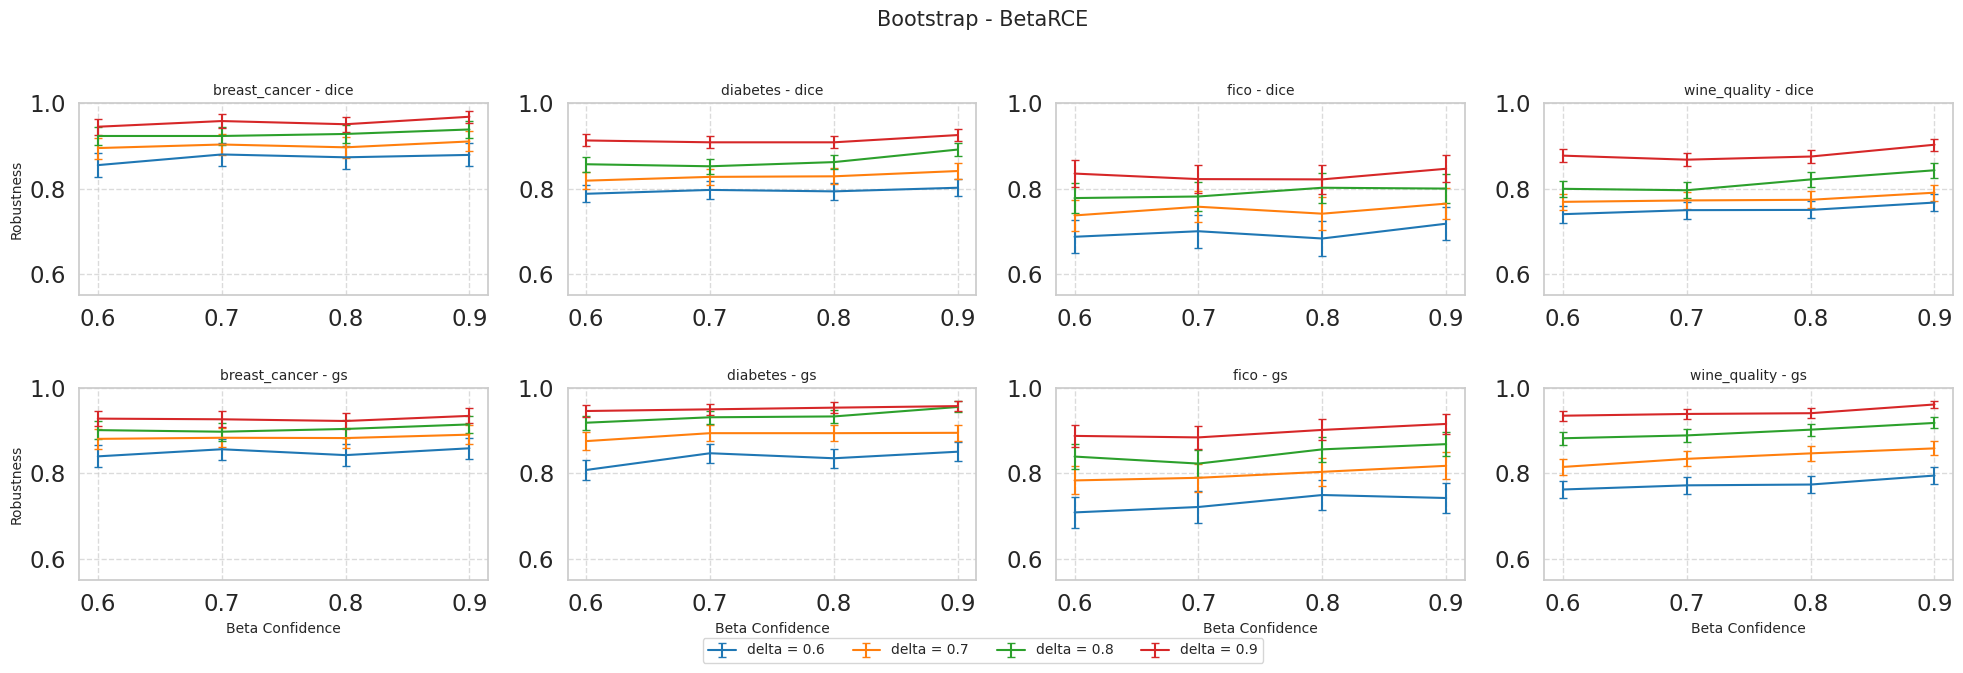

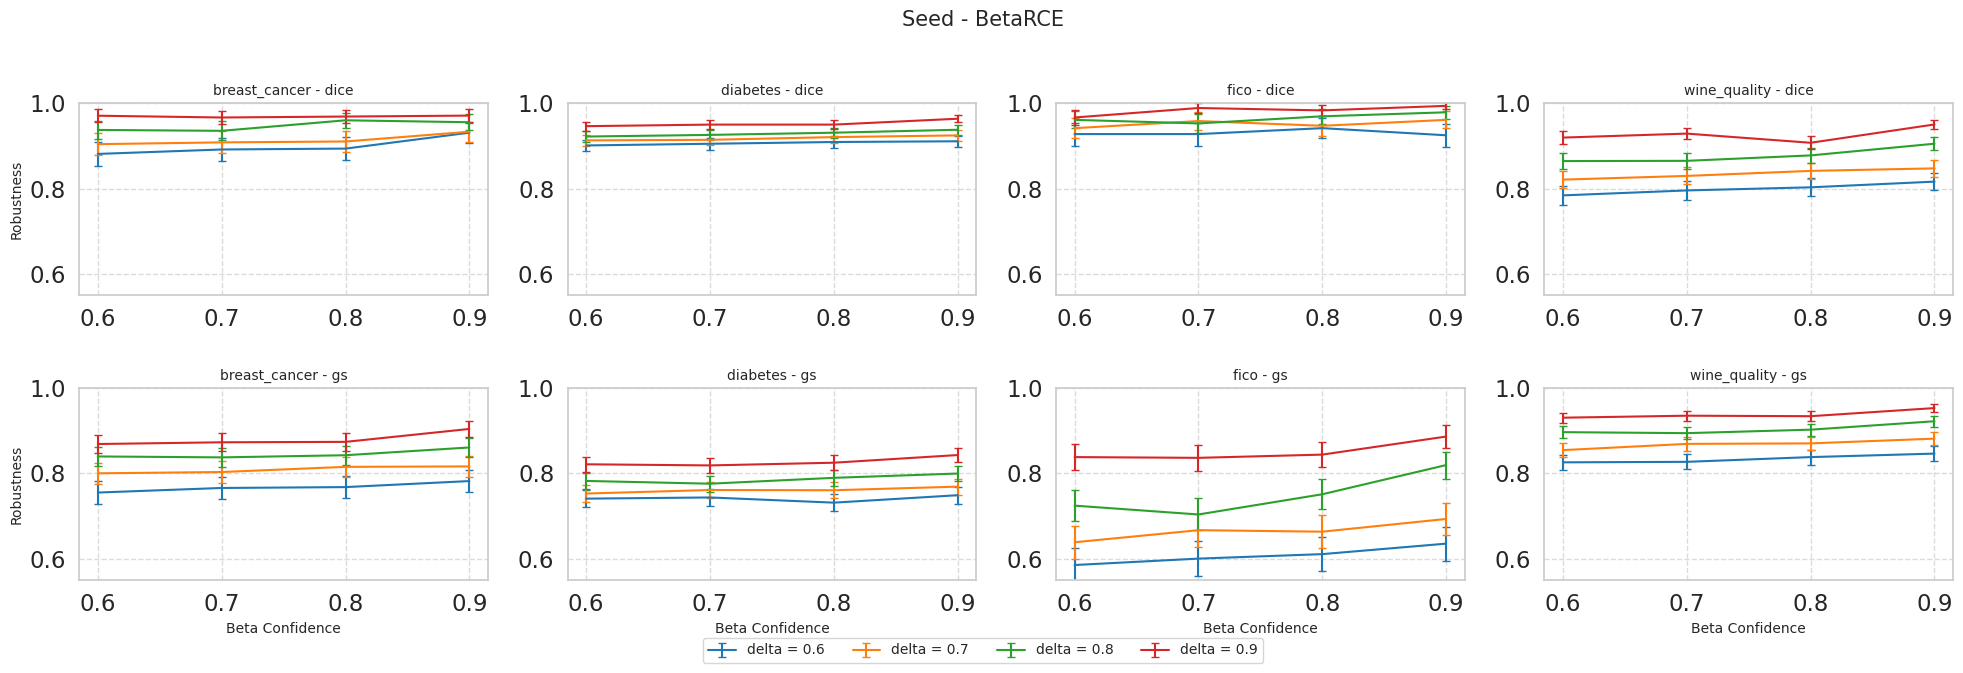

In [27]:
# Get unique values
datasets = brce_params_agg_df['dataset_name'].unique()
base_methods = brce_params_agg_df['base_cf_method'].unique()
experiment_types = brce_params_agg_df['experiment_type'].unique()
delta_robustness_values = sorted(brce_params_agg_df['delta_robustness'].unique())

# Set up the plot
n_rows = len(base_methods)
n_cols = len(datasets)

colors = {l:c for l, c in zip(delta_robustness_values, colors_discrete)}

for exp_type in experiment_types:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows), squeeze=False)
    for i, base_method in enumerate(base_methods):
        for j, dataset in enumerate(datasets):
            ax = axs[i, j]
            for k, delta_rob in enumerate(delta_robustness_values):
                df_subset = brce_params_agg_df[
                    (brce_params_agg_df['dataset_name'] == dataset) &
                    (brce_params_agg_df['base_cf_method'] == base_method) &
                    (brce_params_agg_df['experiment_type'] == exp_type) &
                    (brce_params_agg_df['delta_robustness'] == delta_rob)
                ]
                
                if not df_subset.empty:
                    ax.errorbar(
                        df_subset['beta_confidence'],
                        df_subset['robustness'],
                        yerr=Z_SCORE * df_subset['robustness_std'] / np.sqrt(df_subset['n']),
                        label=f"delta = {delta_rob}",
                        color=colors[delta_rob],
                        capsize=3
                    )

            ax.set_xticks(sorted(df_subset['beta_confidence'].unique()))
            ax.set_title(f'{dataset} - {base_method}', fontsize=10)
            if j == 0:  # Only set ylabel for the leftmost column
                ax.set_ylabel('Robustness', fontsize=10)
            if i == n_rows - 1:  # Only set xlabel for the bottom row
                ax.set_xlabel('Beta Confidence', fontsize=10)
            
            ax.set_ylim(0.55, 1)  # Assuming robustness is between 0 and 1
            ax.grid(True, linestyle='--', alpha=0.7)

    # Create a single legend for the entire figure
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(experiment_types)*len(delta_robustness_values), bbox_to_anchor=(0.5, -0.1), fontsize=10)

    plt.suptitle(f'{exp_type} - BetaRCE', fontsize=15, y=1)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)  # Adjust to make room for the legend
    plt.show()

In [32]:
raw_df = betarce_df[betarce_df['this_is_generalization'] == False].copy()

In [33]:
raw_df[raw_df['base_cf_method'] == 'face']['base_counterfactual_validity_model2'].value_counts()

1.0    75143
0.0    22057
Name: base_counterfactual_validity_model2, dtype: int64

<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[1] Does higher Beta lead to better empirical robustness?</div>

32    97200
Name: k_mlps_in_B, dtype: int64


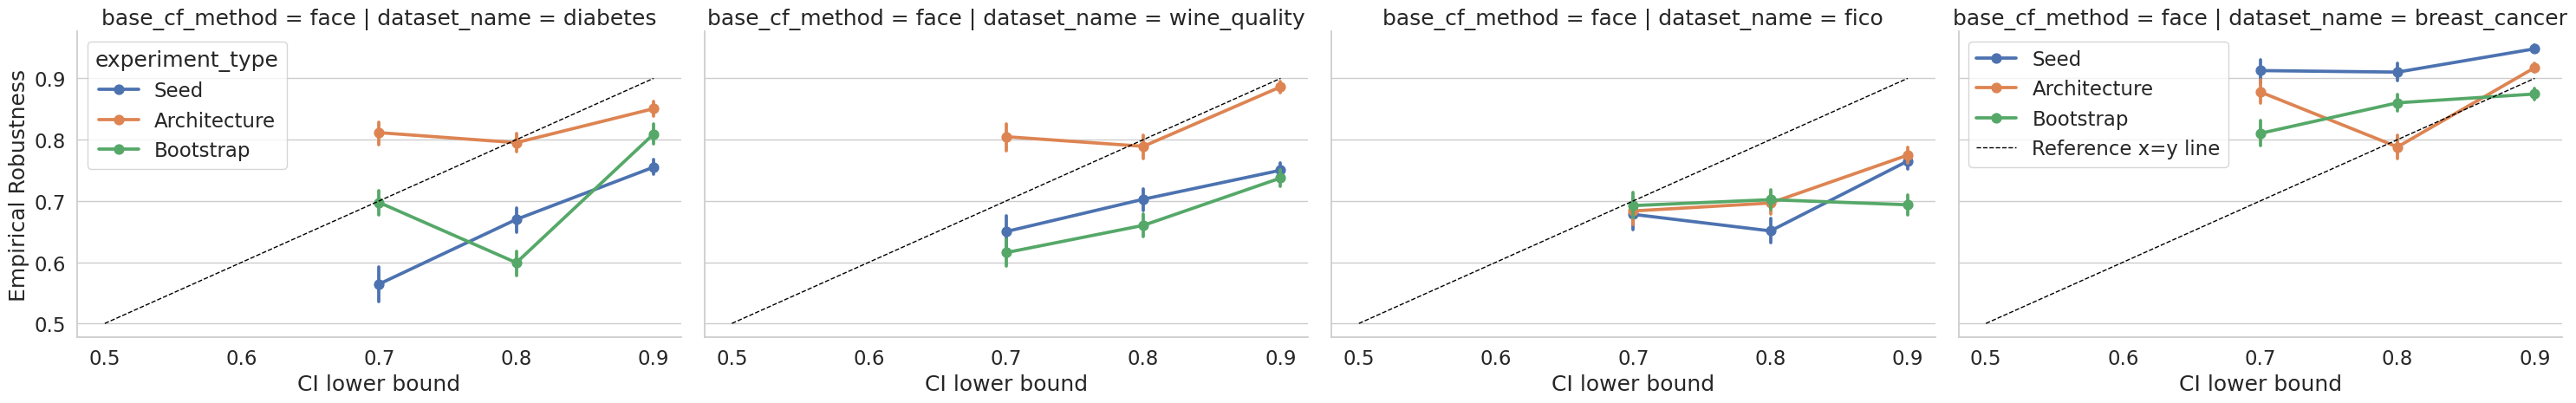

In [34]:
# Split by expeirment type (hue) and dataset (col)
# x-axis: lower bound discretized
# y-axis: average empirical robustness

_tmp_df = raw_df[raw_df['base_cf_method'] == 'face'].copy()
lb_threshs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
_tmp_df['CI lower bound'] = pd.cut(_tmp_df['lower_bound_beta'], bins=lb_threshs, labels=lb_threshs[:-1])
_tmp_df['CI midpoint'] = (_tmp_df['lower_bound_beta'] + _tmp_df['upper_bound_beta']) / 2
_tmp_df['CI midpoint'] = pd.cut(_tmp_df['CI midpoint'], bins=lb_threshs, labels=lb_threshs[:-1])
_tmp_df['Empirical Robustness'] = _tmp_df['base_counterfactual_validity_model2'].astype(float)

# Drop rows with NaN values in 'Empirical Robustness'
_tmp_df = _tmp_df.dropna(subset=['Empirical Robustness'])

# Print counts for each k_mlps_in_B
print(_tmp_df['k_mlps_in_B'].value_counts())

g = sns.catplot(data=_tmp_df, 
            x='CI lower bound',
            y='Empirical Robustness',
            hue='experiment_type', 
            col='dataset_name', 
            row='base_cf_method',
            kind='point', 
            # palette=colors_discrete, 
            # markers=markers, 
            height=5, 
            aspect=1.5,
            legend_out=False,
)
for ax in g.axes.flat:
    ax.plot(list(range(5)), lb_threshs[:-1], color='black', linestyle='--', linewidth=1, label='Reference x=y line')

plt.legend()
plt.savefig(f'{images_dir}/1_robustness_vs_ci_lower_bound.png', dpi=300, bbox_inches='tight')

In [37]:
nn_gs_df = raw_df[(raw_df['model_type_to_use'] == 'neural_network') & (raw_df['base_cf_method'] == 'gs')]
nn_dice_df = raw_df[(raw_df['model_type_to_use'] == 'neural_network') & (raw_df['base_cf_method'] == 'dice')]
nn_face_df = raw_df[(raw_df['model_type_to_use'] == 'neural_network') & (raw_df['base_cf_method'] == 'face')]
nn_df = raw_df[raw_df['model_type_to_use'] == 'neural_network']
dt_gs_df = raw_df[(raw_df['model_type_to_use'] == 'DecisionTree') & (raw_df['base_cf_method'] == 'GrowingSpheres')]
dt_dice_df = raw_df[(raw_df['model_type_to_use'] == 'DecisionTree') & (raw_df['base_cf_method'] == 'Dice')]
dt_df = raw_df[raw_df['model_type_to_use'] == 'DecisionTree']

print(f'Lengths of the dataframes: NN GS: {len(nn_gs_df)}, NN Dice: {len(nn_dice_df)}, NN Face: {len(nn_face_df)}, NN: {len(nn_df)}, DT GS: {len(dt_gs_df)}, DT Dice: {len(dt_dice_df)}, DT: {len(dt_df)}')

Lengths of the dataframes: NN GS: 91800, NN Dice: 97100, NN Face: 97200, NN: 286100, DT GS: 0, DT Dice: 0, DT: 0


<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[2] Is the empirical validity δ-Robust?</div>

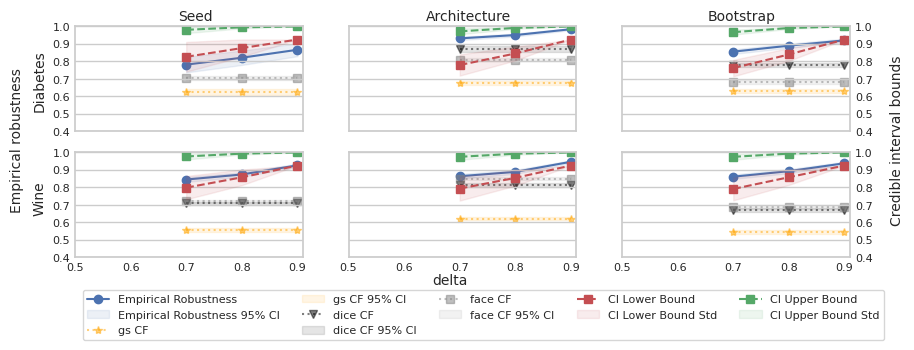

In [42]:
# Use only matplotlib 
# x-axis: delta_robsutness
# y-axis: empirical robustness
# twin y-axis: CI lower and upper bounds
# row: dataset
# col: experiment type

_tmp_df = nn_df.copy()
method='gs'

# datasets = ['wine_quality', 'diabetes', 'fico', 'breast_cancer']
# rename_Datasets = ['Wine', 'Diabetes', 'Heloc', 'Br. Cancer']

datasets = ['diabetes', 'wine_quality']
rename_Datasets = ['Diabetes', 'Wine']
_tmp_df['dataset_name'] = _tmp_df['dataset_name'].replace(dict(zip(datasets, rename_Datasets)))
datasets = rename_Datasets

experiment_types = _tmp_df['experiment_type'].unique()
delta_robustness = _tmp_df['delta_robustness'].unique().tolist()
delta_robustness.sort()
# Set fontsize to 11
rows = max(2, len(datasets))
cols = max(2, len(experiment_types))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 3), sharex=True, sharey=True)



for i, dataset in enumerate(datasets):
    for j, experiment_type in enumerate(experiment_types):
        _df_fil = _tmp_df[(_tmp_df['dataset_name'] == dataset) & (_tmp_df['experiment_type'] == experiment_type)]
        _df = _df_fil[_df_fil['base_cf_method'] == method]
        
        data = _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].mean()
        
        ax = axes[i, j]
        ax.plot(delta_robustness, data, marker='o', linestyle='-', color='b', label='Empirical Robustness')
        emprob_ci = 1.96 * _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].std() / np.sqrt(_df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].count())
        ax.fill_between(delta_robustness, data - emprob_ci, data + emprob_ci, color='b', alpha=0.1, label='Empirical Robustness 95% CI')
        
        # ax.set_title(f'{dataset} \n{experiment_type}')
        
        
        data_lower = _df.groupby('delta_robustness')['lower_bound_beta'].mean()
        data_upper = _df.groupby('delta_robustness')['upper_bound_beta'].mean()
        
        ax2 = ax.twinx()
        
        ax2.plot(delta_robustness, data_lower, marker='s', linestyle='--', color='r', label='CI Lower Bound')
        # add yerr for lower bound
        lb_std = _df.groupby('delta_robustness')['lower_bound_beta'].std()
        ax2.fill_between(delta_robustness, data_lower - lb_std, data_lower + lb_std, color='r', alpha=0.1, label='CI Lower Bound Std')
        
        ax2.plot(delta_robustness, data_upper, marker='s', linestyle='--', color='g', label='CI Upper Bound')
        # add yerr
        ub_std = _df.groupby('delta_robustness')['upper_bound_beta'].std()
        ax2.fill_between(delta_robustness, data_upper - ub_std, data_upper + ub_std, color='g', alpha=0.1, label='CI Upper Bound Std')
        
        #Plot baseline
        linestyles = [':', ':', ':']
        markers = ['*', 'v', 's']
        for k, (m, color) in enumerate(zip(['gs', 'dice', 'face'], ['orange', 'black', 'gray'])):
            __df = _df_fil[_df_fil['base_cf_method'] == m]
            base = __df['base_counterfactual_validity_model2'].mean()
            base_std = __df['base_counterfactual_validity_model2'].std()
            base_ci = 1.96 * base_std / np.sqrt(__df['base_counterfactual_validity_model2'].count())
            ax.plot(delta_robustness, [base] * len(delta_robustness), color=color, linestyle=linestyles[k], label=f'{m} CF', marker=markers[k], alpha=0.5)
            ax.fill_between(delta_robustness, base - base_ci, base + base_ci, color=color, alpha=0.1, label=f'{m} CF 95% CI')
        
        l = 0.4
        ax.set_ylim(l, 1)
        ax2.set_ylim(l, 1)
        ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9])
        ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax2.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
            
        # Decrease font size of the labels
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax2.tick_params(axis='both', which='major', labelsize=10)
        
        # Turn off label ticks for ax2 on the plots that are not on the right
        if j != len(experiment_types) - 1:
            ax2.set_yticklabels([])
            
        # Remove the outline of the plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        
        ax.tick_params(axis=u'both', which=u'both',length=0)
        ax2.tick_params(axis=u'both', which=u'both',length=0)
        
        # Change ticks fontsize
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax2.tick_params(axis='both', which='major', labelsize=8)
        
        # Remove grid
        ax.grid(False)
        
        handles, labels = ax.get_legend_handles_labels()    
        handles_2, labels_2 = ax2.get_legend_handles_labels()
        
        handles_combined = handles + handles_2
        labels_combined = labels + labels_2
        
fig.text(0.5, 0.02, 'delta', ha='center', fontsize=10)
fig.text(0.06, 0.5, 'Empirical robustness', va='center', rotation='vertical', fontsize=10)  
fig.text(0.94, 0.5, 'Credible interval bounds', va='center', rotation='vertical', fontsize=10)
# Create one legend for the entire figure
fig.legend(handles_combined, labels_combined,  bbox_to_anchor=(0.94, 0.02), ncol=5, fontsize=8)

# Set titles for the rows with the dataset names
for ax, row in zip(axes[:,0], datasets):
    rowlen = len(row)
    fig.text(ax.get_position().x0 - 0.035 , ax.get_position().y0 + 0.6 * (1/rowlen), row, ha='center', rotation='vertical', fontsize=10)

# Set titles for the columns
for ax, col in zip(axes[0], experiment_types):
    fig.text(ax.get_position().x0 + 0.12 , ax.get_position().y1 + 0.02, col, ha='center', fontsize=10)

           
plt.savefig(f'{images_dir}/2_empirical_robustness_ci_bounds_paper.png', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()


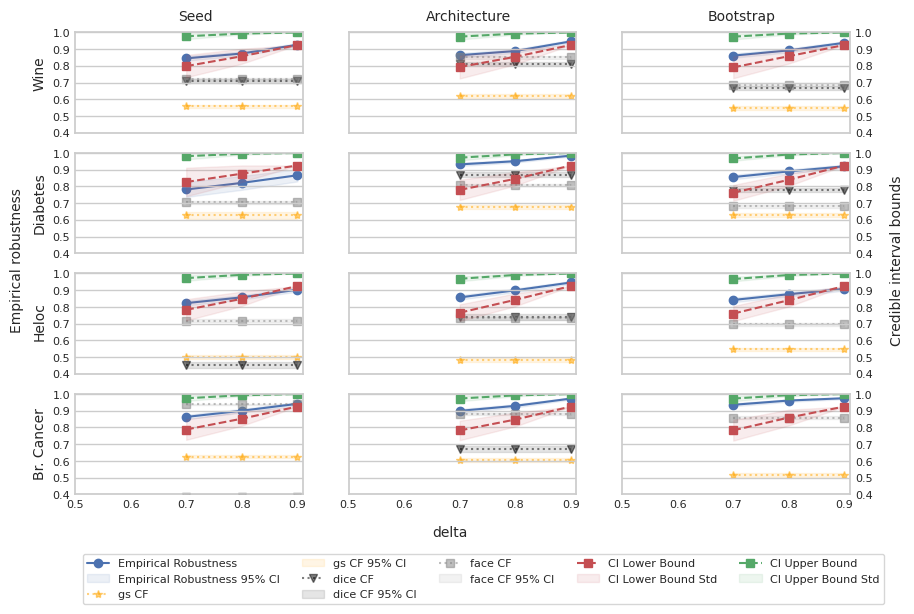

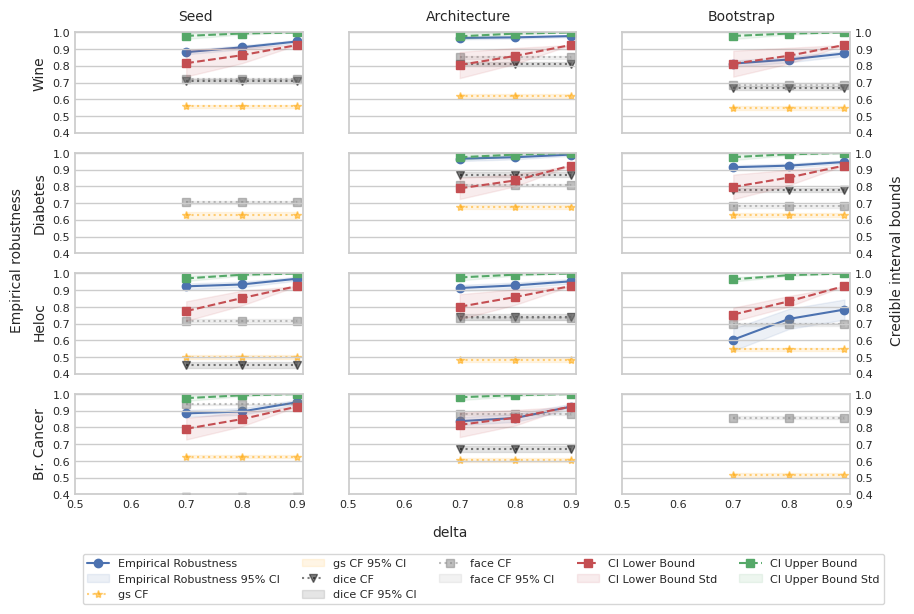

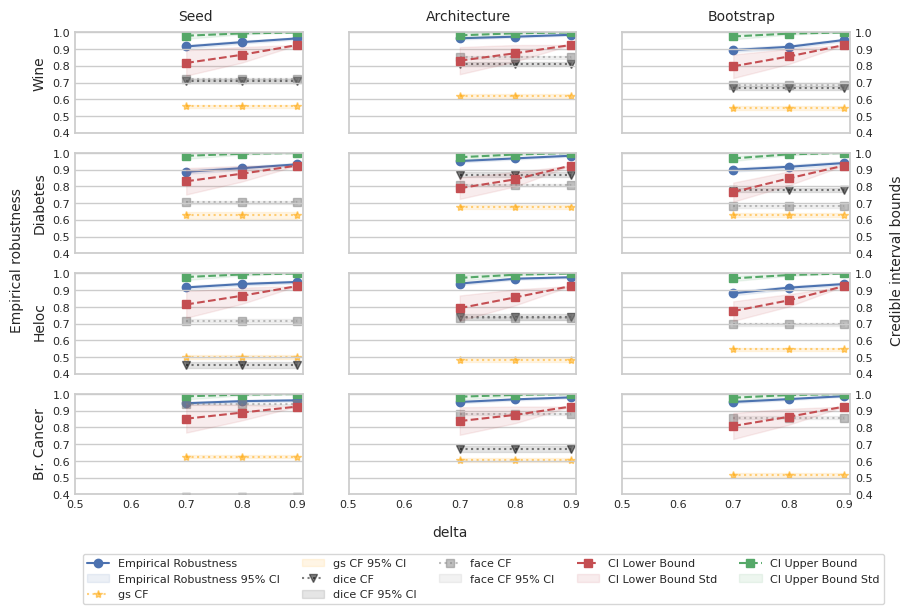

In [43]:
# Use only matplotlib 
# x-axis: delta_robsutness
# y-axis: empirical robustness
# twin y-axis: CI lower and upper bounds
# row: dataset
# col: experiment type

_tmp_df = nn_df.copy()

datasets = ['wine_quality', 'diabetes', 'fico', 'breast_cancer']
rename_Datasets = ['Wine', 'Diabetes', 'Heloc', 'Br. Cancer']

_tmp_df['dataset_name'] = _tmp_df['dataset_name'].replace(dict(zip(datasets, rename_Datasets)))
datasets = rename_Datasets

experiment_types = _tmp_df['experiment_type'].unique()
delta_robustness = _tmp_df['delta_robustness'].unique().tolist()
delta_robustness.sort()
# Set fontsize to 11
rows = max(2, len(datasets))
cols = max(2, len(experiment_types))


for method in ['gs', 'dice', 'face']:
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 6), sharex=True, sharey=True)
    
    for i, dataset in enumerate(datasets):
        for j, experiment_type in enumerate(experiment_types):
            _df_fil = _tmp_df[(_tmp_df['dataset_name'] == dataset) & (_tmp_df['experiment_type'] == experiment_type)]
            _df = _df_fil[_df_fil['base_cf_method'] == method]
            
            data = _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].mean()
            
            ax = axes[i, j]
            ax.plot(delta_robustness, data, marker='o', linestyle='-', color='b', label='Empirical Robustness')
            emprob_ci = 1.96 * _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].std() / np.sqrt(_df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].count())
            ax.fill_between(delta_robustness, data - emprob_ci, data + emprob_ci, color='b', alpha=0.1, label='Empirical Robustness 95% CI')
            
            # ax.set_title(f'{dataset} \n{experiment_type}')
            
            
            data_lower = _df.groupby('delta_robustness')['lower_bound_beta'].mean()
            data_upper = _df.groupby('delta_robustness')['upper_bound_beta'].mean()
            
            ax2 = ax.twinx()
            
            ax2.plot(delta_robustness, data_lower, marker='s', linestyle='--', color='r', label='CI Lower Bound')
            # add yerr for lower bound
            lb_std = _df.groupby('delta_robustness')['lower_bound_beta'].std()
            ax2.fill_between(delta_robustness, data_lower - lb_std, data_lower + lb_std, color='r', alpha=0.1, label='CI Lower Bound Std')
            
            ax2.plot(delta_robustness, data_upper, marker='s', linestyle='--', color='g', label='CI Upper Bound')
            # add yerr
            ub_std = _df.groupby('delta_robustness')['upper_bound_beta'].std()
            ax2.fill_between(delta_robustness, data_upper - ub_std, data_upper + ub_std, color='g', alpha=0.1, label='CI Upper Bound Std')
            
            #Plot baseline
            linestyles = [':', ':', ':']
            markers = ['*', 'v', 's']
            for k, (m, color) in enumerate(zip(['gs', 'dice', 'face'], ['orange', 'black', 'gray'])):
                __df = _df_fil[_df_fil['base_cf_method'] == m]
                base = __df['base_counterfactual_validity_model2'].mean()
                base_std = __df['base_counterfactual_validity_model2'].std()
                base_ci = 1.96 * base_std / np.sqrt(__df['base_counterfactual_validity_model2'].count())
                ax.plot(delta_robustness, [base] * len(delta_robustness), color=color, linestyle=linestyles[k], label=f'{m} CF', marker=markers[k], alpha=0.5)
                ax.fill_between(delta_robustness, base - base_ci, base + base_ci, color=color, alpha=0.1, label=f'{m} CF 95% CI')
            
            l = 0.4
            ax.set_ylim(l, 1)
            ax2.set_ylim(l, 1)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9])
            ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
            ax2.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
                
            # Decrease font size of the labels
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax2.tick_params(axis='both', which='major', labelsize=10)
            
            # Turn off label ticks for ax2 on the plots that are not on the right
            if j != len(experiment_types) - 1:
                ax2.set_yticklabels([])
                
            # Remove the outline of the plot
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
            
            ax.tick_params(axis=u'both', which=u'both',length=0)
            ax2.tick_params(axis=u'both', which=u'both',length=0)
            
            # Change ticks fontsize
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax2.tick_params(axis='both', which='major', labelsize=8)
            
            # Remove grid
            ax.grid(False)
            
            handles, labels = ax.get_legend_handles_labels()    
            handles_2, labels_2 = ax2.get_legend_handles_labels()
            
            handles_combined = handles + handles_2
            labels_combined = labels + labels_2
            
    fig.text(0.5, 0.04, 'delta', ha='center', fontsize=10)
    fig.text(0.06, 0.5, 'Empirical robustness', va='center', rotation='vertical', fontsize=10)  
    fig.text(0.94, 0.5, 'Credible interval bounds', va='center', rotation='vertical', fontsize=10)
    # Create one legend for the entire figure
    fig.legend(handles_combined, labels_combined,  bbox_to_anchor=(0.94, 0.02), ncol=5, fontsize=8)

    # Set titles for the rows with the dataset names
    for ax, row in zip(axes[:,0], datasets):
        rowlen = len(row)
        fig.text(ax.get_position().x0 - 0.035 , ax.get_position().y0 + 0.3 * (1/rowlen), row, ha='center', rotation='vertical', fontsize=10)

    # Set titles for the columns
    for ax, col in zip(axes[0], experiment_types):
        fig.text(ax.get_position().x0 + 0.12 , ax.get_position().y1 + 0.02, col, ha='center', fontsize=10)

            
    plt.savefig(f'{images_dir}/2_empirical_robustness_ci_bounds_{method}.png', dpi=300, bbox_inches='tight')

    # plt.tight_layout()
    plt.show()
    plt.close()
  

<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[3] Comparision to RobX</div>

In [44]:

robx_raw_df = robx_df.copy()

In [45]:
robx_raw_df.head(3)

Unnamed: 0 base_cf_method model_type_to_use experiment_type dataset_name  \
0           0             gs    neural_network            Seed     diabetes   
1           1             gs    neural_network            Seed     diabetes   
2           2             gs    neural_network            Seed     diabetes   

   just_base_cf  k_mlps_in_B  fold_i experiment_generalization_type  \
0         False           32       1                           Seed   
1         False           32       1                           Seed   
2         False           32       1                           Seed   

   beta_confidence  delta_robustness model2_name  \
0              0.7              0.01   Model2_11   
1              0.7              0.01   Model2_12   
2              0.7              0.01   Model2_13   

                                       x_test_sample  y_test_sample  \
0  [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
1  [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
2  [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   

   model1_pred_proba  model1_pred_crisp  model2_pred_proba  model2_pred_crisp  \
0           0.081147                  0           0.156689                  0   
1           0.081147                  0           0.116735                  0   
2           0.081147                  0           0.093705                  0   

                                 base_counterfactual  \
0  [0.09121719 0.53353763 0.64541465 0.37307183 0...   
1  [0.09121719 0.53353763 0.64541465 0.37307183 0...   
2  [0.09121719 0.53353763 0.64541465 0.37307183 0...   

   base_counterfactual_model1_pred_proba  \
0                               0.507313   
1                               0.507313   
2                               0.507313   

   base_counterfactual_model1_pred_crisp  \
0                                      1   
1                                      1   
2                                      1   

   base_counterfactual_model2_pred_proba  \
0                               0.467516   
1                               0.374178   
2                               0.346704   

   base_counterfactual_model2_pred_crisp  base_counterfactual_validity  \
0                                      0                             1   
1                                      0                             1   
2                                      0                             1   

   base_counterfactual_proximityL1  base_counterfactual_proximityL2  \
0                         0.473878                         0.202357   
1                         0.473878                         0.202357   
2                         0.473878                         0.202357   

   base_counterfactual_plausibility  base_counterfactual_discriminative_power  \
0                          0.247819                                  0.066667   
1                          0.247819                                  0.066667   
2                          0.247819                                  0.066667   

   base_counterfactual_validity_model2  base_counterfactual_time  \
0                                    0                  0.003649   
1                                    0                  0.003649   
2                                    0                  0.003649   

                               robust_counterfactual  \
0  [0.13777179 0.63534392 0.68039002 0.37367183 0...   
1  [0.32122024 0.79720364 0.66379583 0.05039647 0...   
2  [0.13720675 0.63410829 0.67996552 0.37366455 0...   

   robust_counterfactual_model1_pred_proba  \
0                                 0.819976   
1                                 0.854244   
2                                 0.819534   

   robust_counterfactual_model1_pred_crisp  \
0                                        1   
1                                        1   
2                                        1   

   robust_counterfactual_model2_pred_proba  \
0    

In [56]:
robx_raw_df.rename(columns={'beta_confidence': 'tau', 'delta_robustness': 'variance'}, inplace=True)
robx_raw_df

Unnamed: 0 base_cf_method model_type_to_use experiment_type  \
0               0             gs    neural_network            Seed   
1               1             gs    neural_network            Seed   
2               2             gs    neural_network            Seed   
3               3             gs    neural_network            Seed   
4               4             gs    neural_network            Seed   
...           ...            ...               ...             ...   
97195          95           dice    neural_network    Architecture   
97196          96           dice    neural_network    Architecture   
97197          97           dice    neural_network    Architecture   
97198          98           dice    neural_network    Architecture   
97199          99           dice    neural_network    Architecture   

        dataset_name  just_base_cf  k_mlps_in_B  fold_i  \
0           diabetes         False           32       1   
1           diabetes         False           32       1   
2           diabetes         False           32       1   
3           diabetes         False           32       1   
4           diabetes         False           32       1   
...              ...           ...          ...     ...   
97195  breast_cancer         False           32       1   
97196  breast_cancer         False           32       1   
97197  breast_cancer         False           32       1   
97198  breast_cancer         False           32       1   
97199  breast_cancer         False           32       1   

      experiment_generalization_type  tau  variance model2_name  \
0                               Seed  0.7      0.01   Model2_11   
1                               Seed  0.7      0.01   Model2_12   
2                               Seed  0.7      0.01   Model2_13   
3                               Seed  0.7      0.01   Model2_14   
4                               Seed  0.7      0.01   Model2_15   
...                              ...  ...       ...         ...   
97195                   Architecture  0.7      0.01    Model2_6   
97196                   Architecture  0.7      0.01    Model2_7   
97197                   Architecture  0.7      0.01    Model2_8   
97198                   Architecture  0.7      0.01    Model2_9   
97199                   Architecture  0.7      0.01   Model2_10   

                                           x_test_sample  y_test_sample  \
0      [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
1      [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
2      [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
3      [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
4      [0.14285714 0.45454545 0.59649123 0.42424242 0...              1   
...                                                  ...            ...   
97195  [0.31515926 0.22421373 0.30004837 0.1816755  0...              0   
97196  [0.31515926 0.22421373 0.30004837 0.1816755  0...              0   
97197  [0.31515926 0.22421373 0.30004837 0.1816755  0...              0   
97198  [0.31515926 0.22421373 0.30004837 0.1816755  0...              0   
97199  [0.31515926 0.22421373 0.30004837 0.1816755  0...              0   

       model1_pred_proba  model1_pred_crisp  model2_pred_proba  \
0               0.081147                  0           0.156689   
1               0.081147                  0           0.116735   
2               0.081147                  0           0.093705   
3               0.081147                  0           0.117994   
4               0.081147                  0           0.109127   
...                  ...                ...                ...   
97195           0.000273                  0           0.000250   
97196           0.000273                  0           0.000127   
97197           0.000273                  0           0.000056   
97198           0.000273                  0           0.000027   
97199           0.000273 

In [63]:
robx_nn_gs_df = robx_raw_df[(robx_raw_df['model_type_to_use'] == 'neural_network') & (robx_raw_df['base_cf_method'] == 'gs')]
robx_nn_dice_df = robx_raw_df[(robx_raw_df['model_type_to_use'] == 'neural_network') & (robx_raw_df['base_cf_method'] == 'dice')]
robx_nn_face_df = robx_raw_df[(robx_raw_df['model_type_to_use'] == 'neural_network') & (robx_raw_df['base_cf_method'] == 'face')]
robx_nn_df = robx_raw_df[robx_raw_df['model_type_to_use'] == 'neural_network']
robx_dt_gs_df = robx_raw_df[(robx_raw_df['model_type_to_use'] == 'DecisionTree') & (robx_raw_df['base_cf_method'] == 'gs')]
robx_dt_dice_df = robx_raw_df[(robx_raw_df['model_type_to_use'] == 'DecisionTree') & (robx_raw_df['base_cf_method'] == 'dice')]
robx_dt_df = robx_raw_df[robx_raw_df['model_type_to_use'] == 'DecisionTree']

print(f'Lengths of the dataframes: NN GS: {len(robx_nn_gs_df)}, NN Dice: {len(robx_nn_dice_df)}, NN Face: {len(robx_nn_face_df)}, NN: {len(robx_nn_df)}, DT GS: {len(robx_dt_gs_df)}, DT Dice: {len(robx_dt_dice_df)}, DT: {len(robx_dt_df)}')

Lengths of the dataframes: NN GS: 32400, NN Dice: 32400, NN Face: 32400, NN: 97200, DT GS: 0, DT Dice: 0, DT: 0


In [77]:
_robx_df = robx_nn_gs_df.copy()
_betarob_df = nn_gs_df.copy()
_method_df = just_base_df.copy()

columns_to_keep = [
    'dataset_name',
    'experiment_type',
    'method_name',
    'robust_counterfactual_validity_model2',
    'robust_counterfactual_L1_distance_from_base_cf',
    'robust_counterfactual_proximityL1',
    'robust_counterfactual_proximityL2',
    'robust_counterfactual_plausibility',
    'robust_counterfactual_discriminative_power',
    'robust_counterfactual_time'
]

columns_to_keep_bs = [
    'dataset_name',
    'experiment_type',
    'method_name',
    'base_counterfactual_validity_model2',
    'robust_counterfactual_L1_distance_from_base_cf',
    'base_counterfactual_proximityL1',
    'base_counterfactual_proximityL2',
    'base_counterfactual_plausibility',
    'base_counterfactual_discriminative_power',
    'base_counterfactual_time'
]

rename_names = [
    'Dataset',
    'Experiment Type',
    'Method',
    'Empirical Robustness',
    'Distance to Base',
    'Proximity L1',
    'Proximity L2',
    'Plausibility',
    'Discriminative Power',
    'Time (s)'

]

# Process the dataframes
_robx_df['method_name'] = 'RobX' + '(' + _robx_df['tau'].astype(str) + ',' + _robx_df['variance'].astype(str) + ')'
_robx_df = _robx_df[columns_to_keep].rename(columns=dict(zip(columns_to_keep, rename_names)))

_betarob_df['method_name'] = 'BetaRCE' + '(' + _betarob_df['delta_robustness'].astype(str) + ',' + _betarob_df['beta_confidence'].astype(str) + ')'
_betarob_df = _betarob_df[columns_to_keep].rename(columns=dict(zip(columns_to_keep, rename_names)))

_method_df['method_name'] = _method_df['base_cf_method']
_method_df = _method_df[columns_to_keep_bs].rename(columns=dict(zip(columns_to_keep_bs, rename_names)))
                                            
datasets = _robx_df['Dataset'].unique()
experiment_types = _robx_df['Experiment Type'].unique()

In [78]:
_method_df

Dataset Experiment Type Method  Empirical Robustness  \
0       breast_cancer       Bootstrap     gs                   0.0   
1       breast_cancer       Bootstrap     gs                   1.0   
2       breast_cancer       Bootstrap     gs                   1.0   
3       breast_cancer       Bootstrap     gs                   1.0   
4       breast_cancer       Bootstrap     gs                   0.0   
...               ...             ...    ...                   ...   
388399  breast_cancer    Architecture   dice                   1.0   
388400  breast_cancer    Architecture   dice                   1.0   
388401  breast_cancer    Architecture   dice                   1.0   
388402  breast_cancer    Architecture   dice                   1.0   
388403  breast_cancer    Architecture   dice                   1.0   

        Distance to Base  Proximity L1  Proximity L2  Plausibility  \
0                    NaN      4.275615      0.948034      0.934933   
1                    NaN      4.275615      0.948034      0.934933   
2                    NaN      4.275615      0.948034      0.934933   
3                    NaN      4.275615      0.948034      0.934933   
4                    NaN      4.275615      0.948034      0.934933   
...                  ...           ...           ...           ...   
388399               NaN      1.753179      1.244808      1.355827   
388400               NaN      1.753179      1.244808      1.355827   
388401               NaN      1.753179      1.244808      1.355827   
388402               NaN      1.753179      1.244808      1.355827   
388403               NaN      1.753179      1.244808      1.355827   

        Discriminative Power  Time (s)  
0                        0.2  0.019339  
1                        0.2  0.019339  
2                        0.2  0.019339  
3                        0.2  0.019339  
4                        0.2  0.019339  
...                      ...       ...  
388399                   0.0  0.219855  
388400                   0.0  0.219855  
388401                   0.0  0.219855  
388402                   0.0  0.219855  
388403                   0.0  0.219855  

[388404 rows x 10 columns]

In [79]:
metrics = [
    'Distance to Base', 
    'Proximity L1', 
    'Proximity L2', 
    'Plausibility', 
    'Discriminative Power', 
    'Time (s)'
]

groupby = ['Dataset', 'Experiment Type', 'Method']
groupby_metrics = ['Dataset', 'Method']
# keep_robx = ['RobX(0.5,0.01)', 'RobX(0.5,0.1)', 'RobX(0.7,0.01)', 'RobX(0.7,0.1)']
# baselines = ['GrowingSpheres', 'Dice']
# keepRCE = ['BetaRCE(0.6,0.95)', 'BetaRCE(0.7,0.95)', 'BetaRCE(0.8,0.95)', 'BetaRCE(0.9,0.95)']


# -- ROBX --
robx_grouped = _robx_df.groupby(groupby).mean(numeric_only=False)
# robx_grouped = robx_grouped[robx_grouped.index.get_level_values('Method')]

print(robx_grouped) 


# Empirical
robx_grouped_emp = robx_grouped.unstack(level=-2)['Empirical Robustness']
# Metrics
robx_grouped_method = robx_grouped.groupby(groupby_metrics)[metrics].mean(numeric_only=False)
robx_grouped_method['Experiment Type'] = ['-'] * len(robx_grouped_method) 
robx_grouped_method = robx_grouped_method.set_index(['Experiment Type'], append=True)
robx_grouped_method = robx_grouped_method.reorder_levels([0,2,1])


# -- Baselines --
method_grouped = _method_df.groupby(groupby)
method_grouped = method_grouped.mean(numeric_only=False)
# method_grouped = method_grouped[method_grouped.index.get_level_values('Method').isin(baselines)]
# Empirical
method_grouped_emp = method_grouped.unstack(level=-2)['Empirical Robustness']
# Metrics
method_grouped_method = method_grouped.groupby(groupby_metrics)[metrics].mean(numeric_only=False)
method_grouped_method['Experiment Type'] = ['-'] * len(method_grouped_method) 
method_grouped_method = method_grouped_method.set_index(['Experiment Type'], append=True)
method_grouped_method = method_grouped_method.reorder_levels([0,2,1])

# -- RCE -- 
rce_grouped = _betarob_df.groupby(groupby)
rce_grouped = rce_grouped.mean(numeric_only=False)
# rce_grouped = rce_grouped[rce_grouped.index.get_level_values('Method').isin(keepRCE)]
# Empirical
rce_grouped_emp = rce_grouped.unstack(level=-2)['Empirical Robustness']
# Metrics 
rce_grouped_method = rce_grouped[metrics]
# rce_grouped_method = rce_grouped_method.loc[(slice(None), slice(None), keepRCE), :]


# CONCAT
all_emp = pd.concat([method_grouped_emp, robx_grouped_emp, rce_grouped_emp]).sort_index(level=0, sort_remaining=False)
all_emp.to_csv(f'{images_dir}/all_emp.csv')
met_emp = pd.concat([method_grouped_method, robx_grouped_method, rce_grouped_method]).sort_index(level=0)
met_emp.to_csv(f'{images_dir}/all_met.csv')

                                              Empirical Robustness  \
Dataset       Experiment Type Method                                 
breast_cancer Architecture    RobX(0.7,0.01)              0.996667   
              Bootstrap       RobX(0.7,0.01)              0.977778   
              Seed            RobX(0.7,0.01)              0.972963   
diabetes      Architecture    RobX(0.7,0.01)              0.952593   
              Bootstrap       RobX(0.7,0.01)              0.958519   
              Seed            RobX(0.7,0.01)              0.960000   
fico          Architecture    RobX(0.7,0.01)              1.000000   
              Bootstrap       RobX(0.7,0.01)              0.989630   
              Seed            RobX(0.7,0.01)              0.999259   
wine_quality  Architecture    RobX(0.7,0.01)              1.000000   
              Bootstrap       RobX(0.7,0.01)              0.996667   
              Seed            RobX(0.7,0.01)              1.000000   

                   

In [80]:
all_emp

Experiment Type                  Architecture  Bootstrap      Seed
Dataset       Method                                              
breast_cancer dice                   0.656379        NaN       NaN
              face                   0.957852   0.867630       NaN
              gs                     0.424444   0.620370  0.558519
              rbr                    0.363004        NaN       NaN
              roar                   0.385206        NaN       NaN
              RobX(0.7,0.01)         0.996667   0.977778  0.972963
              BetaRCE(0.7,0.95)      0.899259   0.935556  0.862963
              BetaRCE(0.8,0.95)      0.929259   0.961111  0.900000
              BetaRCE(0.9,0.95)      0.972963   0.974815  0.941481
diabetes      face                   0.861806        NaN       NaN
              gs                     0.671481   0.575556  0.459630
              RobX(0.7,0.01)         0.952593   0.958519  0.960000
              BetaRCE(0.7,0.95)      0.931852   0.855926  0.781818
              BetaRCE(0.8,0.95)      0.950741   0.890000  0.821212
              BetaRCE(0.9,0.95)      0.984259   0.920370  0.866667
fico          face                   0.766728        NaN       NaN
              gs                     0.544074   0.607407  0.604815
              RobX(0.7,0.01)         1.000000   0.989630  0.999259
              BetaRCE(0.7,0.95)      0.857037   0.841852  0.822963
              BetaRCE(0.8,0.95)      0.899518   0.876296  0.857407
              BetaRCE(0.9,0.95)      0.946212   0.907865  0.902963
wine_quality  dice                   0.763245        NaN       NaN
              face                   0.779654   0.715411       NaN
              gs                     0.618519   0.618889  0.476296
              rbr                    0.777219        NaN       NaN
              roar                   0.720081        NaN       NaN
              RobX(0.7,0.01)         1.000000   0.996667  1.000000
              BetaRCE(0.7,0.95)      0.864074   0.861481  0.845185
              BetaRCE(0.8,0.95)      0.888889   0.892963  0.874074
              BetaRCE(0.9,0.95)      0.946667   0.938148  0.926296

In [81]:
met_emp.head(20)

Distance to Base  \
Dataset       Experiment Type Method                                
breast_cancer -               RobX(0.7,0.01)             2.302978   
                              dice                            NaN   
                              face                            NaN   
                              gs                              NaN   
                              rbr                             NaN   
                              roar                            NaN   
              Architecture    BetaRCE(0.7,0.95)          1.260842   
                              BetaRCE(0.8,0.95)          1.523603   
                              BetaRCE(0.9,0.95)          2.004762   
              Bootstrap       BetaRCE(0.7,0.95)          1.890694   
                              BetaRCE(0.8,0.95)          2.280397   
                              BetaRCE(0.9,0.95)          2.667897   
              Seed            BetaRCE(0.7,0.95)          1.569936   
                              BetaRCE(0.8,0.95)          1.793177   
                              BetaRCE(0.9,0.95)          2.239413   
diabetes      -               RobX(0.7,0.01)             0.702577   
                              face                            NaN   
                              gs                              NaN   
              Architecture    BetaRCE(0.7,0.95)          0.314334   
                              BetaRCE(0.8,0.95)          0.414284   

                                                 Proximity L1  Proximity L2  \
Dataset       Experiment Type Method                                          
breast_cancer -               RobX(0.7,0.01)         3.280958      0.731733   
                              dice                   1.611744      1.004671   
                              face                   3.431513      0.785529   
                              gs                     3.059380      0.697266   
                              rbr                    2.663857      0.619216   
                              roar                   9.268900      2.056768   
              Architecture    BetaRCE(0.7,0.95)      3.971282      0.897527   
                              BetaRCE(0.8,0.95)      4.111965      0.929654   
                              BetaRCE(0.9,0.95)      4.359579      0.985538   
              Bootstrap       BetaRCE(0.7,0.95)      3.893175      0.883700   
                              BetaRCE(0.8,0.95)      4.140529      0.939800   
                              BetaRCE(0.9,0.95)      4.412375      0.999825   
              Seed            BetaRCE(0.7,0.95)      3.975634      0.892561   
                              BetaRCE(0.8,0.95)      4.088526      0.918138   
                              BetaRCE(0.9,0.95)      4.344903      0.978458   
diabetes      -               RobX(0.7,0.01)         0.987108      0.466955   
                              face                   0.851164      0.393160   
                              gs                     0.554629      0.241153   
              Architecture    BetaRCE(0.7,0.95)      0.760642      0.332462   
                              BetaRCE(0.8,0.95)      0.839063      0.366361   

                                                 Plausibility  \
Dataset       Experiment Type Method                            
breast_cancer -               RobX(0.7,0.01)         0.591649   
                              dice                   1.043071   
                              face                   0.412376   
                              gs                     0.855273   
                              rbr                    0.545805   
                              roar                   1.516354   
              Architecture    BetaRCE(0.7,0.95)      0.974995   
                              BetaRCE(0.8,0.95)      0.993621   
                              BetaRCE(0.9,0.95)      1.023309   
              Bootstrap       BetaRCE(0.7,0.95)      0.954830   
           

In [82]:
metrics = [
    'Distance to Base', 
    'Proximity L1', 
    'Proximity L2', 
    'Plausibility', 
    'Discriminative Power', 
    'Time (s)'
]

groupby = ['Dataset', 'Experiment Type', 'Method']
groupby_metrics = ['Dataset', 'Method']
# keep_robx = ['RobX(0.5,0.01)', 'RobX(0.5,0.1)', 'RobX(0.6,0.01)', 'RobX(0.6,0.1)']
# baselines = ['GrowingSpheres', 'Dice']
# keepRCE = ['BetaRCE(0.6,0.95)', 'BetaRCE(0.7,0.95)', 'BetaRCE(0.8,0.95)', 'BetaRCE(0.9,0.95)']


# -- ROBX --
robx_grouped = _robx_df.groupby(groupby)
robx_grouped = robx_grouped.std(numeric_only=False) / np.sqrt(robx_grouped.count())
# robx_grouped = robx_grouped[robx_grouped.index.get_level_values('Method').isin(keep_robx)]
# Empirical
robx_grouped_emp = robx_grouped.unstack(level=-2)['Empirical Robustness']
# Metrics
robx_grouped_method = robx_grouped.groupby(groupby_metrics)[metrics]
robx_grouped_method = robx_grouped_method.std(numeric_only=False) / np.sqrt(robx_grouped_method.count())
robx_grouped_method['Experiment Type'] = ['-'] * len(robx_grouped_method) 
robx_grouped_method = robx_grouped_method.set_index(['Experiment Type'], append=True)
robx_grouped_method = robx_grouped_method.reorder_levels([0,2,1])


# -- Baselines --
method_grouped = _method_df.groupby(groupby)
method_grouped = method_grouped.std(numeric_only=False) / np.sqrt(method_grouped.count())
# method_grouped = method_grouped[method_grouped.index.get_level_values('Method').isin(baselines)]
# Empirical
method_grouped_emp = method_grouped.unstack(level=-2)['Empirical Robustness']
# Metrics
method_grouped_method = method_grouped.groupby(groupby_metrics)[metrics]
method_grouped_method = method_grouped_method.std(numeric_only=False) / np.sqrt(method_grouped_method.count())
method_grouped_method['Experiment Type'] = ['-'] * len(method_grouped_method) 
method_grouped_method = method_grouped_method.set_index(['Experiment Type'], append=True)
method_grouped_method = method_grouped_method.reorder_levels([0,2,1])

# -- RCE -- 
rce_grouped = _betarob_df.groupby(groupby)
rce_grouped = rce_grouped.std(numeric_only=False) / np.sqrt(rce_grouped.count())
# rce_grouped = rce_grouped[rce_grouped.index.get_level_values('Method').isin(keepRCE)]
# Empirical
rce_grouped_emp = rce_grouped.unstack(level=-2)['Empirical Robustness']
# Metrics 
rce_grouped_method = rce_grouped[metrics]
# rce_grouped_method = rce_grouped_method.loc[(slice(None), slice(None), keepRCE), :]


# CONCAT
all_emp_std = pd.concat([method_grouped_emp, robx_grouped_emp, rce_grouped_emp]).sort_index(level=0, sort_remaining=False)
all_emp_std.to_csv(f'{images_dir}/all_emp_std.csv')
met_emp_std = pd.concat([method_grouped_method, robx_grouped_method, rce_grouped_method]).sort_index(level=0)
met_emp_std.to_csv(f'{images_dir}/all_met_std.csv')

In [83]:
all_comprehensive = all_emp.round(3).astype(str) + ' +- ' + all_emp_std.round(3).astype(str) 
all_comprehensive.to_csv(f'{images_dir}/all_with_se.csv')
all_comprehensive

Experiment Type                    Architecture       Bootstrap  \
Dataset       Method                                              
breast_cancer dice               0.656 +- 0.002      nan +- nan   
              face               0.958 +- 0.002  0.868 +- 0.003   
              gs                  0.424 +- 0.01   0.62 +- 0.009   
              rbr                0.363 +- 0.002      nan +- nan   
              roar               0.385 +- 0.002      nan +- nan   
              RobX(0.7,0.01)     0.997 +- 0.001  0.978 +- 0.003   
              BetaRCE(0.7,0.95)  0.899 +- 0.006  0.936 +- 0.005   
              BetaRCE(0.8,0.95)  0.929 +- 0.005  0.961 +- 0.004   
              BetaRCE(0.9,0.95)  0.973 +- 0.003  0.975 +- 0.003   
diabetes      face               0.862 +- 0.003      nan +- nan   
              gs                 0.671 +- 0.009   0.576 +- 0.01   
              RobX(0.7,0.01)     0.953 +- 0.004  0.959 +- 0.004   
              BetaRCE(0.7,0.95)  0.932 +- 0.005  0.856 +- 0.007   
              BetaRCE(0.8,0.95)  0.951 +- 0.004   0.89 +- 0.006   
              BetaRCE(0.9,0.95)  0.984 +- 0.003   0.92 +- 0.005   
fico          face               0.767 +- 0.003      nan +- nan   
              gs                  0.544 +- 0.01  0.607 +- 0.009   
              RobX(0.7,0.01)         1.0 +- 0.0   0.99 +- 0.002   
              BetaRCE(0.7,0.95)  0.857 +- 0.007  0.842 +- 0.007   
              BetaRCE(0.8,0.95)    0.9 +- 0.006  0.876 +- 0.006   
              BetaRCE(0.9,0.95)  0.946 +- 0.004  0.908 +- 0.006   
wine_quality  dice               0.763 +- 0.003      nan +- nan   
              face                0.78 +- 0.003  0.715 +- 0.005   
              gs                 0.619 +- 0.009  0.619 +- 0.009   
              rbr                0.777 +- 0.003      nan +- nan   
              roar                0.72 +- 0.002      nan +- nan   
              RobX(0.7,0.01)         1.0 +- 0.0  0.997 +- 0.001   
              BetaRCE(0.7,0.95)  0.864 +- 0.007  0.861 +- 0.007   
              BetaRCE(0.8,0.95)  0.889 +- 0.006  0.893 +- 0.006   
              BetaRCE(0.9,0.95)  0.947 +- 0.004  0.938 +- 0.005   

Experiment Type                            Seed  
Dataset       Method                             
breast_cancer dice                   nan +- nan  
              face                   nan +- nan  
              gs                  0.559 +- 0.01  
              rbr                    nan +- nan  
              roar                   nan +- nan  
              RobX(0.7,0.01)     0.973 +- 0.003  
              BetaRCE(0.7,0.95)  0.863 +- 0.007  
              BetaRCE(0.8,0.95)    0.9 +- 0.006  
              BetaRCE(0.9,0.95)  0.941 +- 0.005  
diabetes      face                   nan +- nan  
              gs                   0.46 +- 0.01  
              RobX(0.7,0.01)      0.96 +- 0.004  
              BetaRCE(0.7,0.95)  0.782 +- 0.023  
              BetaRCE(0.8,0.95)  0.821 +- 0.021  
              BetaRCE(0.9,0.95)  0.867 +- 0.019  
fico          face                   nan +- nan  
              gs                 0.605 +- 0.009  
              RobX(0.7,0.01)     0.999 +- 0.001  
              BetaRCE(0.7,0.95)  0.823 +- 0.007  
              BetaRCE(0.8,0.95)  0.857 +- 0.007  
              BetaRCE(0.9,0.95)  0.903 +- 0.006  
wine_quality  dice                   nan +- nan  
              face                   nan +- nan  
              gs                  0.476 +- 0.01  
              rbr                    nan +- nan  
              roar                   nan +- nan  
              RobX(0.7,0.01)         1.0 +- 0.0  
              BetaRCE(0.7,0.95)  0.845 +- 0.007  
              BetaRCE(0.8,0.95)  0.874 +- 0.006  
              BetaRCE(0.9,0.95)  0.926 +- 0.005

In [84]:
all_metrics_comprehensive = met_emp.round(3).astype(str) + ' +- ' + met_emp_std.round(3).astype(str) 
all_metrics_comprehensive.to_csv(f'{images_dir}/all_metrics_with_se.csv')
all_metrics_comprehensive.head(50)

Distance to Base  \
Dataset       Experiment Type Method                               
breast_cancer -               RobX(0.7,0.01)        2.303 +- 0.0   
                              dice                    nan +- nan   
                              face                    nan +- nan   
                              gs                      nan +- nan   
                              rbr                     nan +- nan   
                              roar                    nan +- nan   
              Architecture    BetaRCE(0.7,0.95)   1.261 +- 0.023   
                              BetaRCE(0.8,0.95)   1.524 +- 0.025   
                              BetaRCE(0.9,0.95)   2.005 +- 0.029   
              Bootstrap       BetaRCE(0.7,0.95)   1.891 +- 0.029   
                              BetaRCE(0.8,0.95)    2.28 +- 0.033   
                              BetaRCE(0.9,0.95)   2.668 +- 0.035   
              Seed            BetaRCE(0.7,0.95)    1.57 +- 0.025   
                              BetaRCE(0.8,0.95)   1.793 +- 0.027   
                              BetaRCE(0.9,0.95)    2.239 +- 0.03   
diabetes      -               RobX(0.7,0.01)        0.703 +- 0.0   
                              face                    nan +- nan   
                              gs                      nan +- nan   
              Architecture    BetaRCE(0.7,0.95)   0.314 +- 0.007   
                              BetaRCE(0.8,0.95)   0.414 +- 0.008   
                              BetaRCE(0.9,0.95)    0.571 +- 0.01   
              Bootstrap       BetaRCE(0.7,0.95)   0.327 +- 0.005   
                              BetaRCE(0.8,0.95)   0.453 +- 0.007   
                              BetaRCE(0.9,0.95)   0.657 +- 0.009   
              Seed            BetaRCE(0.7,0.95)   0.191 +- 0.014   
                              BetaRCE(0.8,0.95)   0.233 +- 0.016   
                              BetaRCE(0.9,0.95)   0.298 +- 0.019   
fico          -               RobX(0.7,0.01)      2.352 +- 0.001   
                              face                    nan +- nan   
                              gs                      nan +- nan   
              Architecture    BetaRCE(0.7,0.95)   1.287 +- 0.026   
                              BetaRCE(0.8,0.95)   1.684 +- 0.035   
                              BetaRCE(0.9,0.95)   2.345 +- 0.051   
              Bootstrap       BetaRCE(0.7,0.95)   1.357 +- 0.021   
                              BetaRCE(0.8,0.95)   1.798 +- 0.028   
                              BetaRCE(0.9,0.95)   2.672 +- 0.045   
              Seed            BetaRCE(0.7,0.95)   1.038 +- 0.018   
                              BetaRCE(0.8,0.95)    1.294 +- 0.02   
                              BetaRCE(0.9,0.95)   1.765 +- 0.024   
wine_quality  -               RobX(0.7,0.01)          0.9 +- 0.0   
                              dice                    nan +- nan   
                              face                    nan +- nan   
                              gs                      nan +- nan   
                              rbr                     nan +- nan   
                              roar                    nan +- nan   
              Architecture    BetaRCE(0.7,0.95)   0.187 +- 0.004   
                              BetaRCE(0.8,0.95)   0.241 +- 0.004   
                              BetaRCE(0.9,0.95)   0.349 +- 0.005   
              Bootstrap       BetaRCE(0.7,0.95)   0.281 +- 0.005   
                              BetaRCE(0.8,0.95)   0.343 +- 0.005   

                                                   Proximity L1  \
Dataset       Experiment Type Method                              
breast_cancer -               RobX(0.7,0.01)       3.281 +- 0.0   
                              dice                 1.612 +- nan   
                              face                 3.432 +- 0.0   
                              gs                 3.059 +- 0.001   
                              rbr                  2.664 +- nan   
                              roar        

Histograms with distance

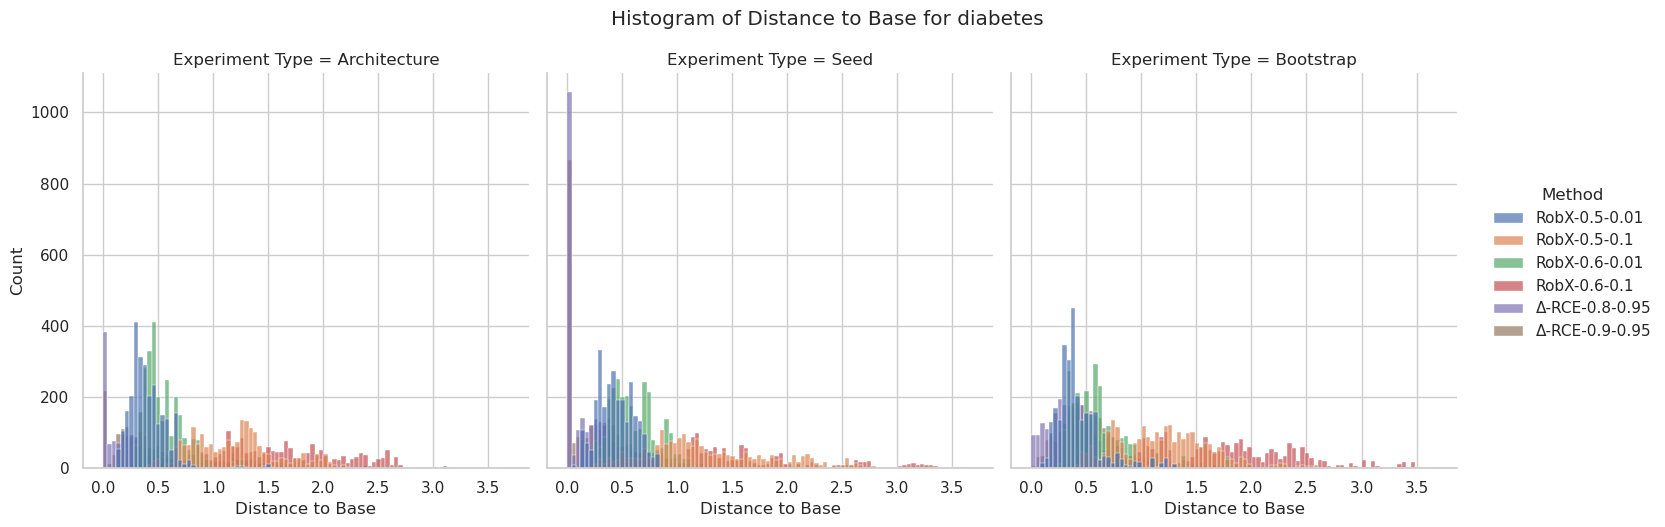

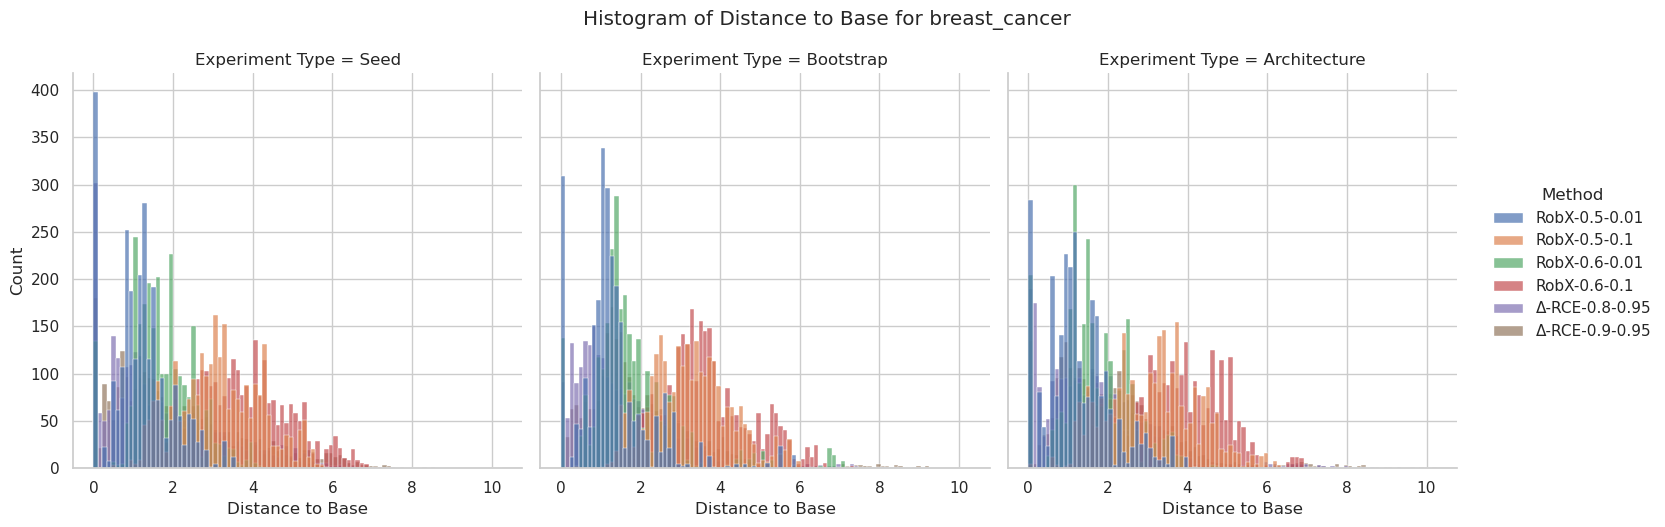

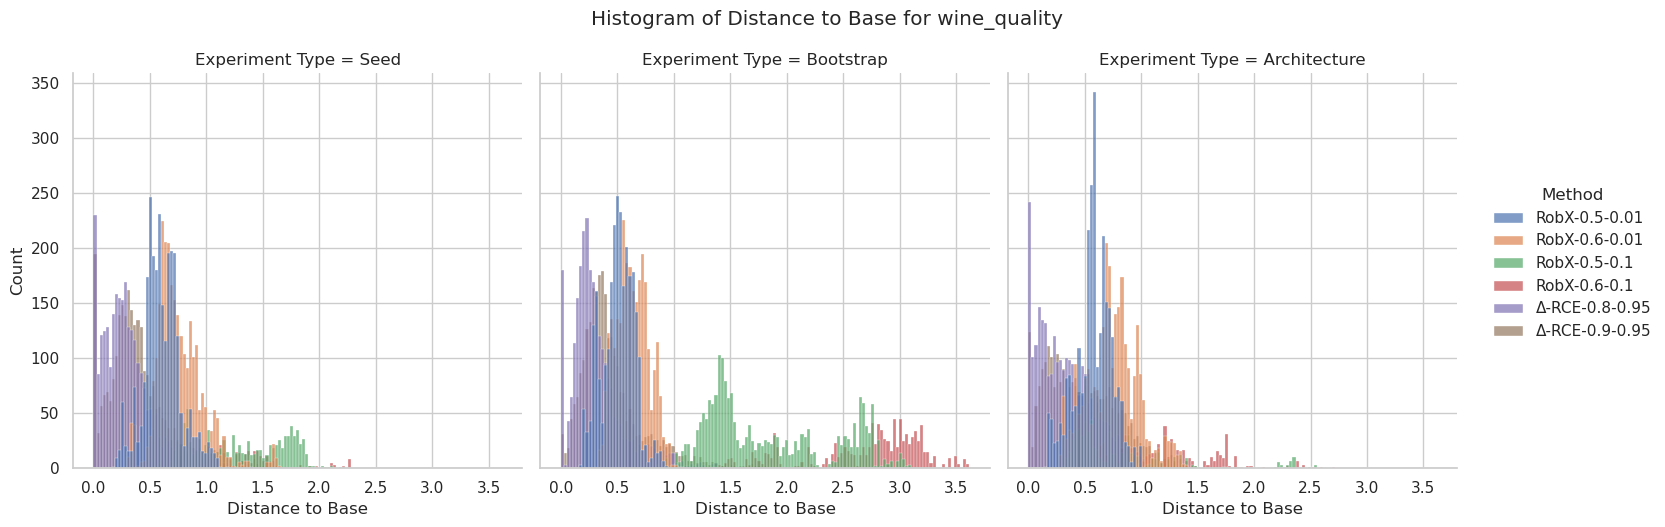

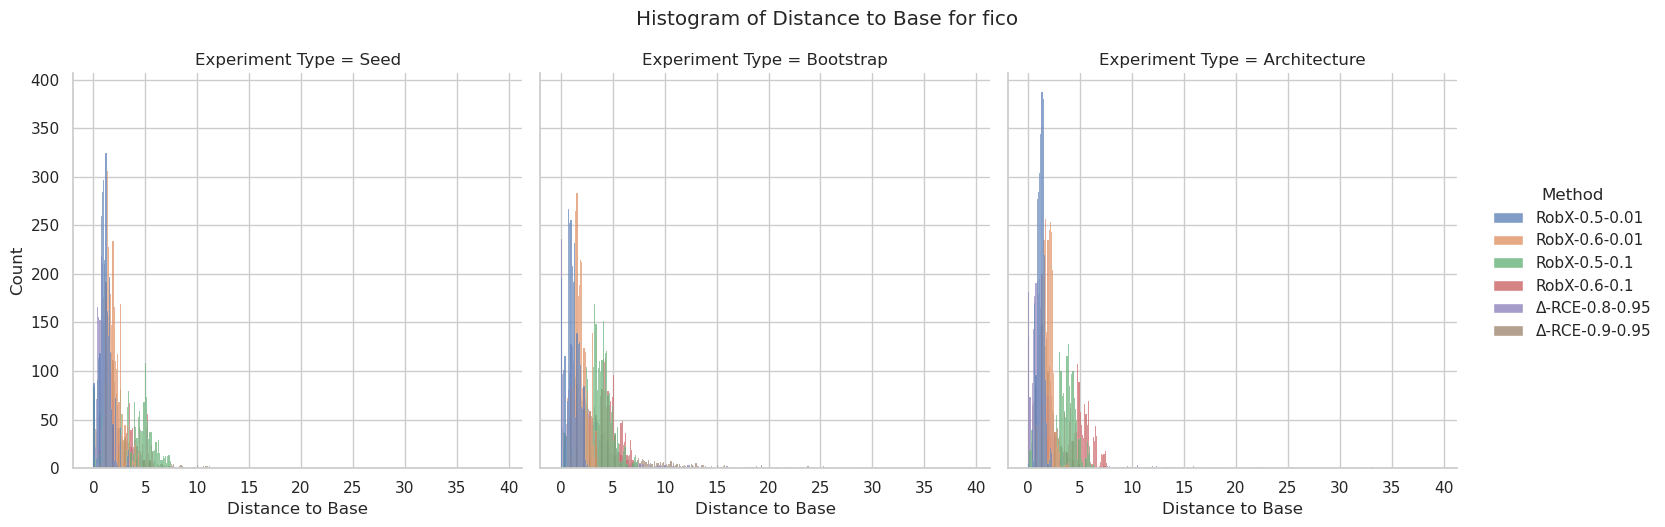

In [25]:

# methods_to_use = ['RobX-0.5-0.01','RobX-0.5-0.1', '\u0394-RCE-0.8-0.95', '\u0394-RCE-0.9-0.95', 'GrowingSpheres', 'Dice']
methods_to_use = ['RobX-0.5-0.01','RobX-0.5-0.1', 'RobX-0.6-0.01','RobX-0.6-0.1', '\u0394-RCE-0.8-0.95', '\u0394-RCE-0.9-0.95']

tmp_rce = nn_gs_df.copy().dropna()
tmp_rce['Method'] = '\u0394-RCE' + '-' + tmp_rce['delta_robustness'].astype(str) + '-' + tmp_rce['beta_confidence'].astype(str)

tmp_robx = robx_nn_gs_df.copy().dropna()
tmp_robx['Method'] = 'RobX' + '-' + tmp_robx['tau'].astype(str) + '-' + tmp_robx['variance'].astype(str)

tmp = pd.concat([tmp_robx, tmp_rce], axis=0, ignore_index=True)

columns={
    'robust_counterfactual_validity_model2': 'Empirical Robustness',
    'robust_counterfactual_L1_distance_from_base_cf': 'Distance to Base',
    'robust_counterfactual_proximityL1': 'Proximity L1',
    'robust_counterfactual_plausibility': 'Plausibility',
    'robust_counterfactual_discriminative_power': 'Discriminative Power',
    'dataset_name': 'Dataset',
    'experiment_type': 'Experiment Type',
    'Method': 'Method',
}


column = 'Distance to Base'
color_by = 'Method'


tmp = tmp.rename(columns=columns)
tmp = tmp[list(columns.values())]
tmp = tmp[tmp['Method'].isin(methods_to_use)]



for dataset in tmp['Dataset'].unique():
    _tmp = tmp[tmp['Dataset'] == dataset]
    # tmp = tmp[tmp['Experiment Type'] == experiment_type]
    sns.displot(data=_tmp, x=column, hue=color_by, kind='hist', alpha=0.7, col='Experiment Type')
    plt.suptitle(f'Histogram of {column} for {dataset}', x=0.5, y=1.05)
    plt.savefig(f'{images_dir}/histogram_{column}_{dataset}.png', dpi=300, bbox_inches='tight')



<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[4_1] Ablation (k mlps sweep)</div>

In [26]:
conf_sweep_results_path = results_path + '/confidence'
conf_sweep_raw_df = process_results(conf_sweep_results_path)

Reading results: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


In [27]:
conf_sweep_raw_df['beta_confidence'].value_counts()

0.70    14400
0.80    14400
0.90    14282
0.95    14220
Name: beta_confidence, dtype: int64

In [28]:
conf_sweep_raw_df['delta_robustness'].value_counts()

0.7    19131
0.8    19091
0.9    19080
Name: delta_robustness, dtype: int64

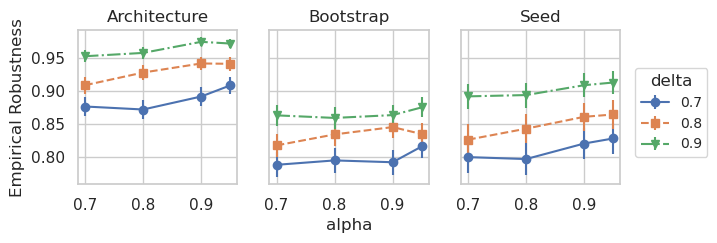

In [29]:
experiments = conf_sweep_raw_df['experiment_type'].unique()

figwidth = 7
fig, axes = plt.subplots(ncols=len(experiments), figsize=(figwidth, 2), sharex=True, sharey=True)

markers = ['o', 's', 'v', 'D']
linestyles = ['-', '--', '-.', ':']

for i, experiment in enumerate(experiments):
    
    ax = axes[i] if len(experiments) > 1 else axes
    
    tmp_conf_df = conf_sweep_raw_df.copy()
    tmp_conf_df = tmp_conf_df[tmp_conf_df['experiment_type'] == experiment]
    
    for j, delta in enumerate(tmp_conf_df['delta_robustness'].unique()):
        tmp_delta_df = tmp_conf_df[tmp_conf_df['delta_robustness'] == delta]
        # sns.lineplot(data=tmp_delta_df, x='beta_confidence', y='robust_counterfactual_validity_model2', ax=ax, label=f'delta={delta}')
        
        data = tmp_delta_df.groupby('beta_confidence')['robust_counterfactual_validity_model2'].mean()
        std = tmp_delta_df.groupby('beta_confidence')['robust_counterfactual_validity_model2'].std()
        cnt = tmp_delta_df.groupby('beta_confidence')['robust_counterfactual_validity_model2'].count()
        
        ax.errorbar(
            data.index, 
            data, 
            yerr=1.96 * std / np.sqrt(cnt),
            label=f'{delta}',
            marker = markers[j],
            linestyle = linestyles[j]
        )
        
    ax.set_title(experiment)
    if i == 1:
        ax.set_xlabel('alpha')
    if i == 0:
        ax.set_ylabel('Empirical Robustness')

plt.legend(title='delta', bbox_to_anchor=(1.05, 0.8), loc='upper left', ncol=1, fontsize=10)
    
plt.savefig(f'{images_dir}/4_1_empirical_robustness_vs_beta_confidence_and_delta.png', dpi=300, bbox_inches='tight')
    
   

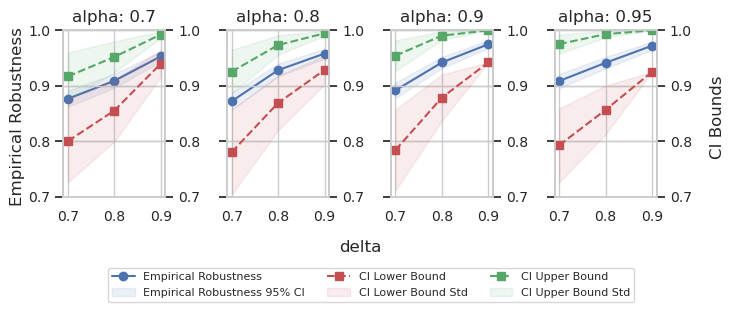

In [30]:
# Use only matplotlib 
# x-axis: delta_robsutness
# y-axis: empirical robustness
# twin y-axis: CI lower and upper bounds
# row: dataset
# col: experiment type

_tmp_df = conf_sweep_raw_df.copy()
_tmp_df = _tmp_df[_tmp_df['experiment_type'] == 'Architecture']
method='GrowingSpheres'

conf = sorted(_tmp_df['beta_confidence'].unique().tolist())
delta_robustness = _tmp_df['delta_robustness'].unique().tolist()
delta_robustness.sort()
# Set fontsize to 11
plt.close()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(7, 2.5), sharex=True, sharey=True)
axes = axes.flatten()


for i, c in enumerate(conf):
    _df = _tmp_df[(_tmp_df['beta_confidence'] == c)]
    
    data = _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].mean()
    ax = axes[i]
    ax.plot(delta_robustness, data, marker='o', linestyle='-', color='b', label='Empirical Robustness')
    emprob_ci = 1.96 * _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].std() / np.sqrt(_df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].count())
    ax.fill_between(delta_robustness, data - emprob_ci, data + emprob_ci, color='b', alpha=0.1, label='Empirical Robustness 95% CI')
    
    ax.set_title(f'alpha: {c}')
    
    data_lower = _df.groupby('delta_robustness')['lower_bound_beta'].mean()
    data_upper = _df.groupby('delta_robustness')['upper_bound_beta'].mean()
    
    ax2 = ax.twinx()
    
    ax2.plot(delta_robustness, data_lower, marker='s', linestyle='--', color='r', label='CI Lower Bound')
    # add yerr for lower bound
    lb_std = _df.groupby('delta_robustness')['lower_bound_beta'].std()
    ax2.fill_between(delta_robustness, data_lower - lb_std, data_lower + lb_std, color='r', alpha=0.1, label='CI Lower Bound Std')


    ax2.plot(delta_robustness, data_upper, marker='s', linestyle='--', color='g', label='CI Upper Bound')
    # add yerr
    ub_std = _df.groupby('delta_robustness')['upper_bound_beta'].std()
    ax2.fill_between(delta_robustness, data_upper - ub_std, data_upper + ub_std, color='g', alpha=0.1, label='CI Upper Bound Std')
    

    l = 0.7
    ax.set_ylim(l, 1)
    ax2.set_ylim(l, 1)
    ax.set_xticks([0.7, 0.8, 0.9])
    ax.set_yticks([0.7, 0.8, 0.9, 1])
    ax2.set_yticks([0.7, 0.8, 0.9, 1])
        
    # Decrease font size of the labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    # Turn off label ticks for ax2 on the plots that are not on the right
    if j != len(experiment_types) - 1:
        ax2.set_yticklabels([])
        
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    handles_combined = handles + handles2
    labels_combined = labels + labels2


# Add one xlabel for all the plots
fig.text(0.5, -0.04, 'delta', ha='center')
fig.text(0.00, 0.5, 'Empirical Robustness', va='center', rotation='vertical')
fig.text(1.0, 0.5, 'CI Bounds', va='center', rotation='vertical')

fig.legend(bbox_to_anchor=(0.9, -0.08), handles=handles_combined, labels=labels_combined, ncol=3, fontsize=8)
   
plt.tight_layout()
plt.savefig(f'{images_dir}/4_1_empirical_robustness_ci_bounds_vs_confidence.png', dpi=300, bbox_inches='tight')

plt.show()


<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[4_2] Ablation (k)</div>

In [31]:
k_sweep_results_path = results_path + '/k'
k_raw_df = process_results(k_sweep_results_path)

Reading results: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


In [32]:
k_raw_df['delta_robustness'].value_counts()

0.7    26263
0.8    26220
0.9    26220
Name: delta_robustness, dtype: int64

In [33]:
k_raw_df['k_mlps_in_B'].value_counts()

8     16200
16    16200
24    10801
48    10800
40    10800
32    10800
56     3102
Name: k_mlps_in_B, dtype: int64

In [45]:
# Drop where k=56 as this run crashed
k_raw_df = k_raw_df[k_raw_df['k_mlps_in_B'] != 56]

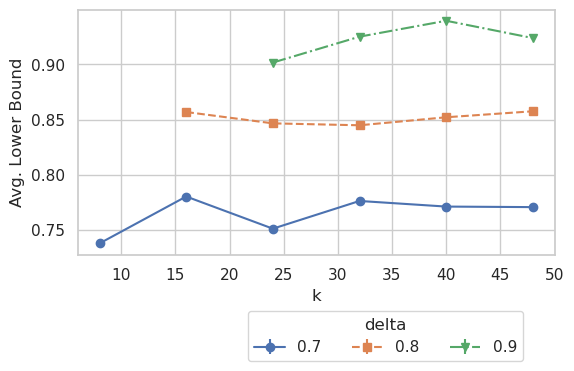

In [46]:
fig, axes = plt.subplots(figsize=(6, 4))

markers = ['o', 's', 'v']
linestyles = ['-', '--', '-.']

for i, delta in enumerate(k_raw_df['delta_robustness'].unique()):
    _df = k_raw_df[k_raw_df['delta_robustness'] == delta]
    data = _df.groupby('k_mlps_in_B')['lower_bound_beta'].mean()
    std = _df.groupby('k_mlps_in_B')['lower_bound_beta'].std()
    cnt = _df.groupby('k_mlps_in_B')['lower_bound_beta'].count()
    
    axes.errorbar(
        data.index, 
        data, 
        yerr=1.96 * std / np.sqrt(cnt),
        label=f'{delta}',
        marker = markers[i],
        linestyle = linestyles[i]
    )

plt.legend(title='delta', bbox_to_anchor=(0.95, -0.2), ncol=5)
plt.xlabel('k')
plt.ylabel('Avg. Lower Bound')
plt.tight_layout()

plt.savefig(f'{images_dir}/4_2_lb_beta_vs_k_mlps.png', dpi=300, bbox_inches='tight')

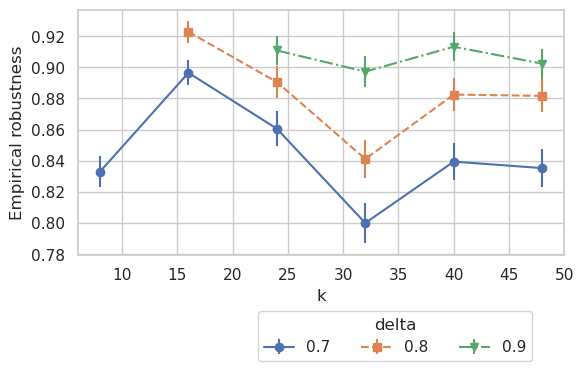

In [47]:
fig, axes = plt.subplots(figsize=(6, 4))

markers = ['o', 's', 'v']
linestyles = ['-', '--', '-.']

for i, delta in enumerate(k_raw_df['delta_robustness'].unique()):
    _df = k_raw_df[k_raw_df['delta_robustness'] == delta]
    data = _df.groupby('k_mlps_in_B')['robust_counterfactual_validity_model2'].mean()
    std = _df.groupby('k_mlps_in_B')['robust_counterfactual_validity_model2'].std()
    cnt = _df.groupby('k_mlps_in_B')['robust_counterfactual_validity_model2'].count()
    
    axes.errorbar(
        data.index, 
        data, 
        yerr=1.96 * std / np.sqrt(cnt),
        label=f'{delta}',
        marker = markers[i],
        linestyle = linestyles[i]
    )

plt.legend(title='delta', bbox_to_anchor=(0.95, -0.2), ncol=5)
plt.xlabel('k')
plt.ylabel('Empirical robustness')
plt.tight_layout()

plt.savefig(f'{images_dir}/4_2_ER_vs_k_mlps.png', dpi=300, bbox_inches='tight')

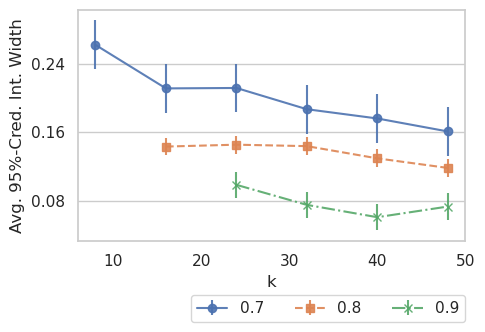

In [48]:
from matplotlib.ticker import FormatStrFormatter

_tmp_df = k_raw_df.copy()
_tmp_df = _tmp_df[_tmp_df['experiment_type'] == 'Architecture']

fig, ax = plt.subplots(figsize=(5, 3))

_tmp_df['lb-ub'] = _tmp_df['upper_bound_beta'] - _tmp_df['lower_bound_beta']
delts = _tmp_df['delta_robustness'].unique()
ks = sorted(_tmp_df['k_mlps_in_B'].unique())
av_ci_width = _tmp_df.groupby(['k_mlps_in_B', 'delta_robustness'])['lb-ub'].mean().reset_index()

markers = ['o', 's', 'x', 'd', '^']
linestyles = ['-', '--', '-.', ':', '-']

for i, delta in enumerate(delts):
    data = av_ci_width[av_ci_width['delta_robustness'] == delta]
    plt.errorbar(data['k_mlps_in_B'], 
                 data['lb-ub'], 
                 marker=markers[i],
                 linestyle=linestyles[i],
                 label=f'{delta}', 
                 yerr=1.96 * data['lb-ub'].std() / np.sqrt(data['lb-ub'].count()),
                 alpha=0.9
    )

# format y-axis to round to 2 decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# leave only 4 ticks on the y-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

# Remove vertical gridlines
ax.grid(axis='x')

plt.legend(bbox_to_anchor=(1.02, -0.2), ncol=5)
plt.xlabel('k')
plt.ylabel('Avg. 95%-Cred. Int. Width')
# plt.tight_layout()

plt.savefig(f'{images_dir}/4_2_ci_width_vs_k_mlps.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_110164/2229295343.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


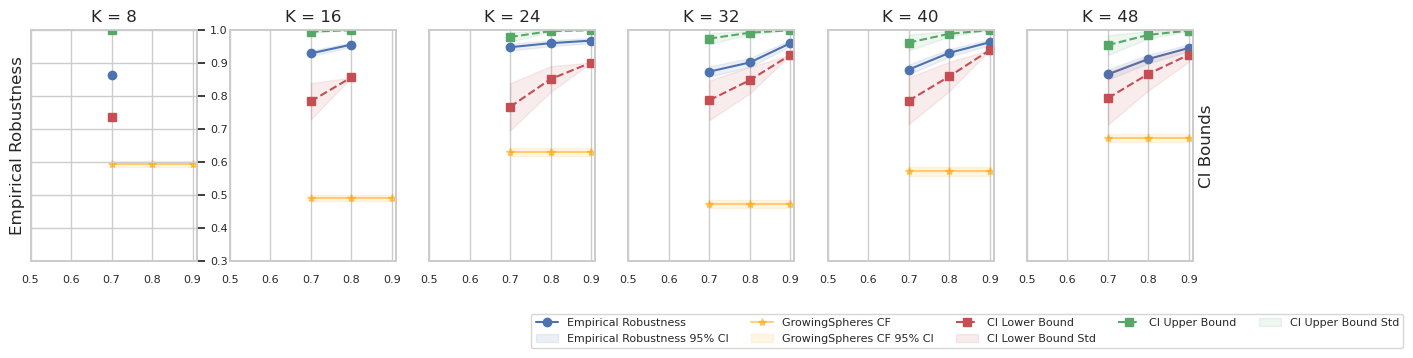

In [71]:
# Use only matplotlib 
# x-axis: delta_robsutness
# y-axis: empirical robustness
# twin y-axis: CI lower and upper bounds
# row: dataset
# col: experiment type

_tmp_df = k_raw_df.copy()
_tmp_df = _tmp_df[_tmp_df['experiment_type'] == 'Architecture']
method='GrowingSpheres'

ks = sorted(_tmp_df['k_mlps_in_B'].unique().tolist())
delta_robustness = _tmp_df['delta_robustness'].unique().tolist()
delta_robustness.sort()
# Set fontsize to 11

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 3), sharex=True, sharey=True)
axes = axes.flatten()


for i, k in enumerate(ks):
    _df = _tmp_df[(_tmp_df['k_mlps_in_B'] == k)]
    
    data = _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].mean()
    ax = axes[i]
    ax.plot(delta_robustness, data, marker='o', linestyle='-', color='b', label='Empirical Robustness')
    emprob_ci = 1.96 * _df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].std() / np.sqrt(_df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].count())
    ax.fill_between(delta_robustness, data - emprob_ci, data + emprob_ci, color='b', alpha=0.1, label='Empirical Robustness 95% CI')
    
    ax.set_title(f'K = {k}')
    
    if i == 0:
        ax.set_ylabel('Empirical Robustness')
    
    
    data_lower = _df.groupby('delta_robustness')['lower_bound_beta'].mean()
    data_upper = _df.groupby('delta_robustness')['upper_bound_beta'].mean()
    
    ax2 = ax.twinx()
    
    ax2.plot(delta_robustness, data_lower, marker='s', linestyle='--', color='r', label='CI Lower Bound')
    # add yerr for lower bound
    lb_std = _df.groupby('delta_robustness')['lower_bound_beta'].std()
    ax2.fill_between(delta_robustness, data_lower - lb_std, data_lower + lb_std, color='r', alpha=0.1, label='CI Lower Bound Std')


    
    ax2.plot(delta_robustness, data_upper, marker='s', linestyle='--', color='g', label='CI Upper Bound')
    # add yerr
    ub_std = _df.groupby('delta_robustness')['upper_bound_beta'].std()
    ax2.fill_between(delta_robustness, data_upper - ub_std, data_upper + ub_std, color='g', alpha=0.1, label='CI Upper Bound Std')
    
    
    if i == len(ks) - 1:
        ax2.set_ylabel('CI Bounds')
    
    
    #Plot baseline
    for m, color in zip(['GrowingSpheres'], ['orange']):
        __df = _df[_df['base_cf_method'] == m]
        base = __df['base_counterfactual_validity_model2'].mean()
        base_std = __df['base_counterfactual_validity_model2'].std()
        base_ci = 1.96 * base_std / np.sqrt(__df['base_counterfactual_validity_model2'].count())
        ax.plot(delta_robustness, [base] * len(delta_robustness), color=color, linestyle='-', label=f'{m} CF', marker='*', alpha=0.5)
        ax.fill_between(delta_robustness, base - base_ci, base + base_ci, color=color, alpha=0.1, label=f'{m} CF 95% CI')
    
    l = 0.3
    ax.set_ylim(l, 1)
    ax2.set_ylim(l, 1)
    ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9])
    # Make x-axis labels more coarse i.e. only show rounded to tenths

    # ax_lim = ax.get_xlim()
    # ax.set_xticks(np.arange(ax_lim[0], ax_lim[1], 0.1).round(1))
    
    if i == 4:
        ax_legend_handles, ax_legend_labels = ax.get_legend_handles_labels()
        ax2_legend_handles, ax2_legend_labels = ax2.get_legend_handles_labels()
        
        ax.legend(ax_legend_handles + ax2_legend_handles, 
                    ax_legend_labels + ax2_legend_labels, 
                    ncol=5, 
                    loc='lower right',
                    bbox_to_anchor=(3.5, -0.4),
                    fontsize=8
        )
        
        
    # Decrease font size of the labels
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    
    # Turn off label ticks for ax2 on the plots that are not on the right
    
    if i != 0:
        ax2.set_yticklabels([])
        ax2.set_yticks([])
        ax.set_yticks([])
        ax.set_yticklabels([])
    



dataset =  _tmp_df['dataset_name'].unique()[0]
experiment_type = _tmp_df['experiment_type'].unique()[0]
# plt.suptitle(f'Empirical Robustness vs K MLPs in B (Dataset: {dataset}, Experiment Type: {experiment_type})')        
plt.savefig(f'{images_dir}/4_2_empirical_robustness_ci_bounds_vs_k.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[4_3] Ablation (generalizations)</div>

In [37]:
generalization_results_path = results_path + '/generalization'
gen_raw_df = process_results(generalization_results_path)

Reading results: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


In [38]:
gen_raw_df['experiment_type'].value_counts()

Architecture    10301
Name: experiment_type, dtype: int64

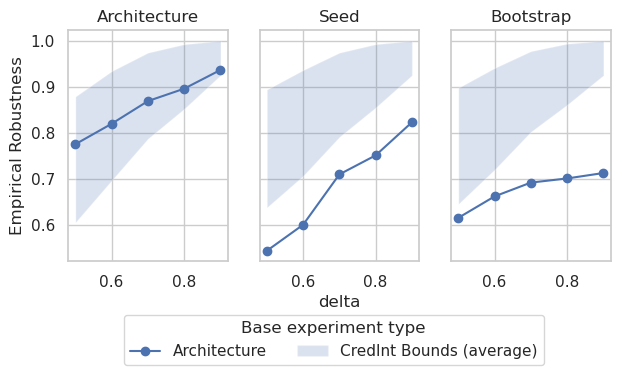

In [39]:
generalizations = gen_raw_df['experiment_generalization_type'].unique()
experiments = gen_raw_df['experiment_type'].unique()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(7, 3), sharex=True, sharey=True)
axes = axes.flatten()
for i, gen in enumerate(generalizations):
    for j, experiment in enumerate(experiments):
        tmp_gen_df = gen_raw_df.copy()
        tmp_gen_df = tmp_gen_df[(tmp_gen_df['experiment_type'] == experiment) & (tmp_gen_df['experiment_generalization_type'] == gen)]

        lbs = tmp_gen_df['lower_bound_beta']
        ubs = tmp_gen_df['upper_bound_beta']
        
        tmp_grp = tmp_gen_df.groupby('delta_robustness')['robust_counterfactual_validity_model2'].mean()

        axes[i].plot(tmp_grp.index, tmp_grp, marker='o', linestyle='-', label=experiment)
        
        tmp_grp_lower = tmp_gen_df.groupby('delta_robustness')['lower_bound_beta'].mean()
        tmp_grp_upper = tmp_gen_df.groupby('delta_robustness')['upper_bound_beta'].mean()
        
        axes[i].fill_between(tmp_grp.index, tmp_grp_lower, tmp_grp_upper, alpha=0.2, label='CredInt Bounds (average)')
        
        axes[i].set_title(gen)
        if i == 1:
            axes[i].set_xlabel('delta')
        
        if i == 0:
            axes[i].set_ylabel('Empirical Robustness')
            
        if i == 1:
            axes[i].legend(title='Base experiment type', loc='upper left', ncol=2, bbox_to_anchor=(-0.9, -0.2))
        
            

# plt.tight_layout()

plt.savefig(f'{images_dir}/4_3_empirical_robustness_vs_delta_generalization.png', dpi=300, bbox_inches='tight')
        

<div style="background-color: #AA0000; color: white; text-align: center; font-weight: bold">[5] Time</div>

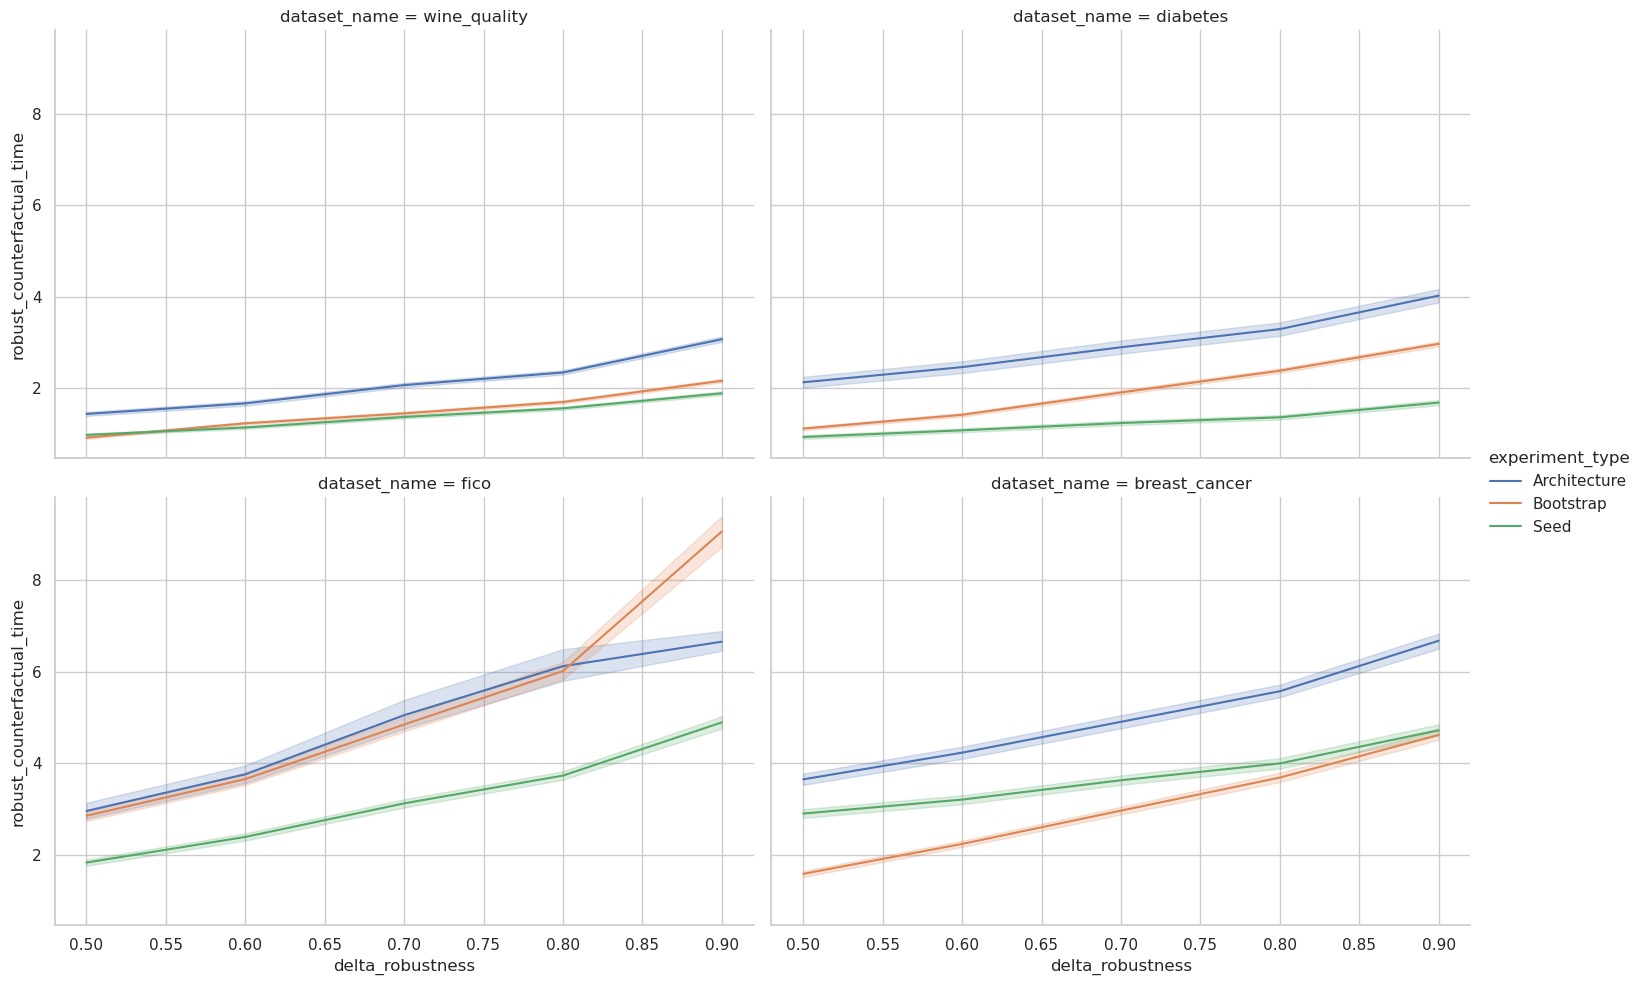

In [40]:
sns.relplot(data=nn_gs_df, x='delta_robustness', y='robust_counterfactual_time', hue='experiment_type', col='dataset_name', kind='line', height=5, aspect=1.5, col_wrap=2)
# plt.xlabel('Delta Robustness')
# plt.ylabel('Robust CF generation time (s)')
plt.savefig(f'{images_dir}/5_1_robust_cf_generation_time_delta.png', dpi=300, bbox_inches='tight')

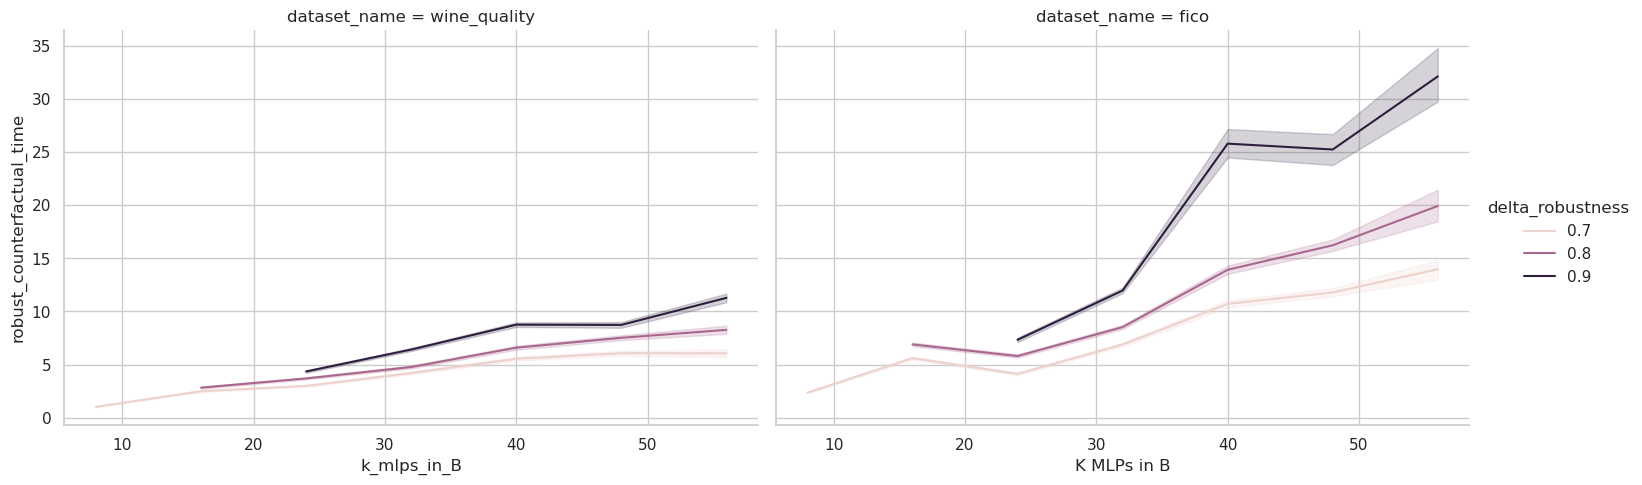

In [41]:
sns.relplot(data=k_raw_df, x='k_mlps_in_B', y='robust_counterfactual_time', hue='delta_robustness', col='dataset_name', kind='line', height=5, aspect=1.5)
plt.xlabel('K MLPs in B')
plt.ylabel('Robust CF generation time (s)')
plt.savefig(f'{images_dir}/5_2_robust_cf_generation_time_k.png', dpi=300, bbox_inches='tight')

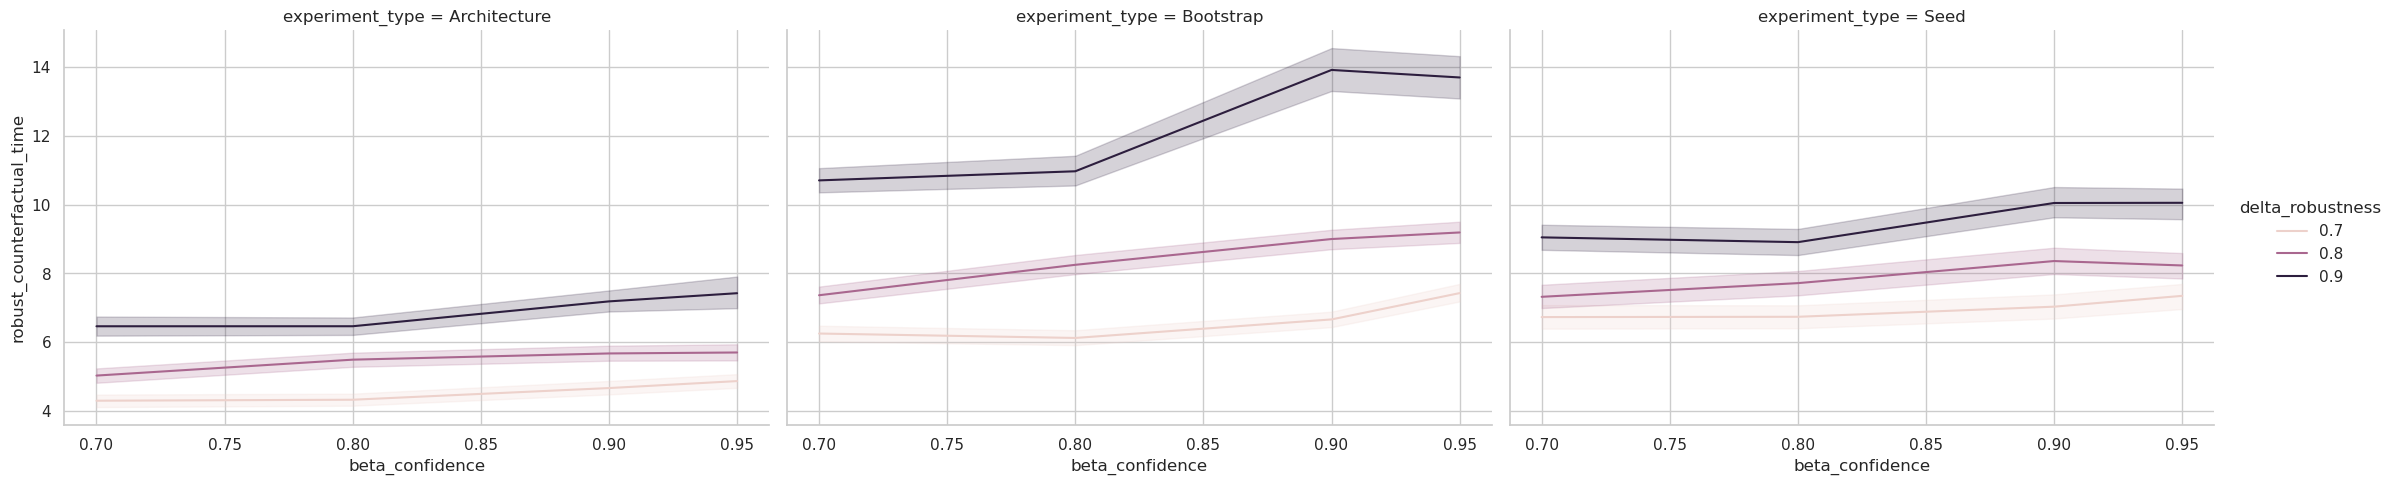

In [42]:
sns.relplot(data=conf_sweep_raw_df, x='beta_confidence', y='robust_counterfactual_time', hue='delta_robustness', col='experiment_type', kind='line', height=5, aspect=1.5)
plt.savefig(f'{images_dir}/5_3_robust_cf_generation_time_beta_confidence.png', dpi=300, bbox_inches='tight')

In [43]:
# Create a scatterplot time vs empirical robustness
cutoff_up = 0.8
cutoff_low = 0.2
exp = 'Seed'

# Print average time for each experiment type
print('BetaROB Time')
tmp_beta = raw_df[raw_df['experiment_type'] == exp] 
quantile80 = tmp_beta['robust_counterfactual_time'].quantile(cutoff_up)
quantile20 = tmp_beta['robust_counterfactual_time'].quantile(cutoff_low)
tmp_beta = tmp_beta[tmp_beta['robust_counterfactual_time'] < quantile80]
tmp_beta = tmp_beta[tmp_beta['robust_counterfactual_time'] > quantile20]
print(tmp_beta.groupby(['experiment_type', 'dataset_name'])['robust_counterfactual_time'].mean().sort_index())

print('RobX Time')
tmp_robx = robx_raw_df[robx_raw_df['experiment_type'] == exp]
quantile80 = tmp_robx['robust_counterfactual_time'].quantile(cutoff_up)
quantile20 = tmp_robx['robust_counterfactual_time'].quantile(cutoff_low)
tmp_robx = tmp_robx[tmp_robx['robust_counterfactual_time'] < quantile80]
tmp_robx = tmp_robx[tmp_robx['robust_counterfactual_time'] > quantile20]
print(tmp_robx.groupby(['experiment_type', 'dataset_name'])['robust_counterfactual_time'].mean().sort_index())

print('Base CF Time')
tmp_base = raw_df[raw_df['experiment_type'] == exp]
quntile80 = tmp_base['base_counterfactual_time'].quantile(cutoff_up)
quantile20 = tmp_base['base_counterfactual_time'].quantile(cutoff_low)
tmp_base = tmp_base[tmp_base['base_counterfactual_time'] < quantile80]
tmp_base = tmp_base[tmp_base['base_counterfactual_time'] > quantile20]
print(tmp_base.groupby(['experiment_type', 'dataset_name'])['base_counterfactual_time'].mean().sort_index())

BetaROB Time
experiment_type  dataset_name 
Seed             breast_cancer    2.178209
                 diabetes         1.307726
                 fico             2.222163
                 wine_quality     1.326638
Name: robust_counterfactual_time, dtype: float64
RobX Time
experiment_type  dataset_name 
Seed             breast_cancer    0.572322
                 diabetes         0.278550
                 fico             0.740911
                 wine_quality     0.646489
Name: robust_counterfactual_time, dtype: float64
Base CF Time
experiment_type  dataset_name 
Seed             breast_cancer    0.099611
                 diabetes         0.047365
                 fico             0.077116
                 wine_quality     0.082889
Name: base_counterfactual_time, dtype: float64


In [26]:
columns_to_keep = [
    # 'dataset_name',
    # 'experiment_type',
    # 'method_name',
    # 'base_counterfactual_validity_model2',
    # 'base_counterfactual_L1_distance_from_base_cf',
    'base_counterfactual_proximityL1',
    'base_counterfactual_proximityL2',
    'base_counterfactual_plausibility',
    'base_counterfactual_discriminative_power',
    'base_counterfactual_time'
]

grpd = supp_df.groupby(['base_cf_method', 'dataset_name', 'experiment_type'])['base_counterfactual_validity_model2'].mean()
# grpd.columns = ['Robustness', 'Prox L1', 'Prox L2', 'Plausibility', 'Discriminative Power', 'Time']
grpd.round(3)

base_cf_method  dataset_name  experiment_type
FACE            diabetes      Architecture       0.819
                              Bootstrap          0.744
                              Seed               0.677
                fico          Architecture       0.717
                              Bootstrap          0.681
                              Seed               0.687
RBR             diabetes      Architecture       0.566
                              Bootstrap          0.541
                              Seed               0.558
                fico          Architecture       0.707
                              Bootstrap          0.600
                              Seed               0.580
ROAR            diabetes      Architecture       0.264
                              Bootstrap          0.266
                              Seed               0.243
                fico          Architecture       0.026
                              Bootstrap          0.160
                   

In [27]:


grpd = supp_df.groupby(['base_cf_method', 'dataset_name'])[columns_to_keep].mean()
grpd.columns = ['Prox L1', 'Prox L2', 'Plausibility', 'Discriminative Power', 'Time']
grpd.round(3)

Prox L1  Prox L2  Plausibility  \
base_cf_method dataset_name                                   
FACE           diabetes        0.802    0.371         0.250   
               fico            2.112    0.626         0.446   
RBR            diabetes        0.728    0.341         0.326   
               fico            1.640    0.490         0.469   
ROAR           diabetes        0.852    0.345         0.491   
               fico            0.229    0.049         0.512   

                             Discriminative Power   Time  
base_cf_method dataset_name                               
FACE           diabetes                     0.536  0.050  
               fico                         0.487  0.108  
RBR            diabetes                     0.597  0.275  
               fico                         0.490  0.232  
ROAR           diabetes                     0.785  0.036  
               fico                         0.670  0.025